In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Library

In [2]:
import os, random, time, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap



2025-09-13 06:08:09.542046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757743689.714825      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757743689.764556      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Device Settings

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


# DATA SETTINGS

In [4]:
SEED = 42
BATCH_SIZE_SSL = 64        # for SimCLR pairs
BATCH_SIZE_SUP = 64         # for supervised (linear eval / test)
EPOCHS_SSL = 2000             # SimCLR pretraining epochs
EPOCHS_LINEAR = 2000           # linear eval epochs
TEMPERATURE = 0.5           # NT-Xent temperature
FEATURE_DIM = 512          # ResNet-18 penultimate layer output
PROJ_DIM = 128              # projection head output
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Utils

In [5]:
def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.show()


# SimCLR Transformation

In [6]:
class SimCLRTransform:
    """
    Returns two augmented views for each image.
    """
    def __init__(self, size=224):
        s = 1.0
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        self.train_transform = T.Compose([
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

# For supervised loaders (linear eval / test)
SUPERVISED_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# Contrastive Pair Dataset

In [7]:
class ContrastivePairDataset(Dataset):
    def __init__(self, image_folder: ImageFolder, transform_pair):
        self.imgs = image_folder.imgs
        self.loader = image_folder.loader
        self.transform_pair = transform_pair

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        path, _ = self.imgs[idx]
        img = self.loader(path)
        if not isinstance(img, Image.Image):
            img = Image.open(path).convert("RGB")
        v1, v2 = self.transform_pair(img)
        return v1, v2


# Data Load & Split (50-50)

In [8]:
full_dataset_supervised = ImageFolder(root=DATA_DIR, transform=SUPERVISED_TRANSFORM)
CLASS_TO_IDX = full_dataset_supervised.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

n_total = len(full_dataset_supervised)
n_train_ssl = int(0.5 * n_total)
n_test = n_total - n_train_ssl
ssl_train_sup, test_sup = random_split(full_dataset_supervised, [n_train_ssl, n_test], generator=torch.Generator().manual_seed(SEED))

# SSL Contrastive dataset uses the same images but returns pairs
ssl_train_contrast = ContrastivePairDataset(
    ImageFolder(root=DATA_DIR),  # raw loader
    transform_pair=SimCLRTransform(size=IMG_SIZE)
)

ssl_train_indices = ssl_train_sup.indices if hasattr(ssl_train_sup, 'indices') else list(range(n_train_ssl))
ssl_train_subset = Subset(ssl_train_contrast, ssl_train_indices)

ssl_train_loader = DataLoader(ssl_train_subset, batch_size=BATCH_SIZE_SSL, shuffle=True, num_workers=2, drop_last=True)

# Supervised loaders for downstream / test
train_sup_loader = DataLoader(Subset(full_dataset_supervised, ssl_train_indices),
                              batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader = DataLoader(test_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | SSL Train: {len(ssl_train_subset)} | Test: {len(test_sup)}")

# For downstream we also want a val split from the SSL-train portion
val_ratio = 0.2
n_train_down = int((1 - val_ratio) * len(ssl_train_indices))
n_val_down = len(ssl_train_indices) - n_train_down
train_down_indices, val_down_indices = random_split(ssl_train_indices, [n_train_down, n_val_down],
                                                    generator=torch.Generator().manual_seed(SEED))
train_down_loader = DataLoader(Subset(full_dataset_supervised, train_down_indices),
                               batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
val_down_loader = DataLoader(Subset(full_dataset_supervised, val_down_indices),
                             batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | SSL Train: 1596 | Test: 1596


# SimCLR setup

In [9]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=FEATURE_DIM, proj_dim=PROJ_DIM, hidden_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        return self.net(x)

class SimCLR(nn.Module):
    def __init__(self, proj_dim=PROJ_DIM):
        super().__init__()
        backbone = models.resnet18(weights=None)  # self-supervised from scratch
        backbone.fc = nn.Identity()               # take 512-d features
        self.encoder = backbone
        self.projector = ProjectionHead(in_dim=FEATURE_DIM, proj_dim=proj_dim)

    def forward(self, x):
        h = self.encoder(x)            # [B, 512]
        z = self.projector(h)          # [B, proj_dim]
        z = F.normalize(z, dim=1)
        return h, z

# NT-Xent (InfoNCE) loss
def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    z_i, z_j: [B, D] normalized
    Returns: scalar loss
    """
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2B, D]
    sim = torch.matmul(z, z.T)        # [2B, 2B], cosine since z normalized

    # remove self-similarity
    mask = torch.eye(2*batch_size, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -9e15)

    # positives: diagonal across halves
    positives = torch.cat([torch.arange(batch_size, 2*batch_size),
                           torch.arange(0, batch_size)]).to(z.device)
    numerator = torch.exp(sim[torch.arange(2*batch_size), positives] / temperature)

    denominator = torch.sum(torch.exp(sim / temperature), dim=1)
    loss = -torch.log(numerator / denominator).mean()
    return loss


In [10]:
simclr = SimCLR(proj_dim=PROJ_DIM).to(DEVICE)
opt_ssl = torch.optim.Adam(simclr.parameters(), lr=LR_SSL)

ssl_loss_history = []

print("Starting SimCLR pretraining...")
for epoch in range(1, EPOCHS_SSL + 1):
    simclr.train()
    running = 0.0
    for v1, v2 in tqdm(ssl_train_loader, desc=f"SSL Epoch {epoch}/{EPOCHS_SSL}"):
        v1, v2 = v1.to(DEVICE), v2.to(DEVICE)
        _, z1 = simclr(v1)
        _, z2 = simclr(v2)
        loss = nt_xent_loss(z1, z2, temperature=TEMPERATURE)
        opt_ssl.zero_grad()
        loss.backward()
        opt_ssl.step()
        running += loss.item() * v1.size(0)
    epoch_loss = running / (len(ssl_train_loader.dataset))
    ssl_loss_history.append(epoch_loss)
    print(f"SSL Epoch {epoch}: loss={epoch_loss:.4f}")

# Save encoder weights
torch.save(simclr.encoder.state_dict(), os.path.join(SAVE_DIR, "simclr_resnet18_encoder.pth"))
print("Saved SimCLR encoder to:", os.path.join(SAVE_DIR, "simclr_resnet18_encoder.pth"))


Starting SimCLR pretraining...


SSL Epoch 1/2000: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]


SSL Epoch 1: loss=4.5357


SSL Epoch 2/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 2: loss=4.4766


SSL Epoch 3/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 3: loss=4.3850


SSL Epoch 4/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 4: loss=4.3506


SSL Epoch 5/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 5: loss=4.3377


SSL Epoch 6/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 6: loss=4.3079


SSL Epoch 7/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 7: loss=4.2145


SSL Epoch 8/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 8: loss=4.2231


SSL Epoch 9/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 9: loss=4.1290


SSL Epoch 10/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 10: loss=4.2341


SSL Epoch 11/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 11: loss=4.2130


SSL Epoch 12/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 12: loss=4.1377


SSL Epoch 13/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 13: loss=4.0879


SSL Epoch 14/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 14: loss=4.0781


SSL Epoch 15/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 15: loss=4.0940


SSL Epoch 16/2000: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


SSL Epoch 16: loss=4.1158


SSL Epoch 17/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 17: loss=4.0541


SSL Epoch 18/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 18: loss=4.0288


SSL Epoch 19/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 19: loss=4.0093


SSL Epoch 20/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 20: loss=4.0302


SSL Epoch 21/2000: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


SSL Epoch 21: loss=3.9831


SSL Epoch 22/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 22: loss=3.9305


SSL Epoch 23/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 23: loss=3.9515


SSL Epoch 24/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 24: loss=3.9018


SSL Epoch 25/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 25: loss=3.9093


SSL Epoch 26/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 26: loss=3.9038


SSL Epoch 27/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 27: loss=3.8322


SSL Epoch 28/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 28: loss=3.8056


SSL Epoch 29/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 29: loss=3.8431


SSL Epoch 30/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 30: loss=3.7888


SSL Epoch 31/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


SSL Epoch 31: loss=3.8125


SSL Epoch 32/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 32: loss=3.7824


SSL Epoch 33/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


SSL Epoch 33: loss=3.7527


SSL Epoch 34/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 34: loss=3.7285


SSL Epoch 35/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 35: loss=3.7203


SSL Epoch 36/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 36: loss=3.6756


SSL Epoch 37/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 37: loss=3.7107


SSL Epoch 38/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 38: loss=3.6991


SSL Epoch 39/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 39: loss=3.6656


SSL Epoch 40/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 40: loss=3.6446


SSL Epoch 41/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 41: loss=3.6794


SSL Epoch 42/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 42: loss=3.6554


SSL Epoch 43/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 43: loss=3.6375


SSL Epoch 44/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 44: loss=3.6137


SSL Epoch 45/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 45: loss=3.6177


SSL Epoch 46/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 46: loss=3.6186


SSL Epoch 47/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 47: loss=3.5893


SSL Epoch 48/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 48: loss=3.5892


SSL Epoch 49/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 49: loss=3.5853


SSL Epoch 50/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 50: loss=3.5668


SSL Epoch 51/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 51: loss=3.5567


SSL Epoch 52/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 52: loss=3.5439


SSL Epoch 53/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 53: loss=3.5696


SSL Epoch 54/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 54: loss=3.5631


SSL Epoch 55/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 55: loss=3.5545


SSL Epoch 56/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 56: loss=3.5166


SSL Epoch 57/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 57: loss=3.5185


SSL Epoch 58/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 58: loss=3.4882


SSL Epoch 59/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 59: loss=3.5068


SSL Epoch 60/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 60: loss=3.5119


SSL Epoch 61/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 61: loss=3.4893


SSL Epoch 62/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 62: loss=3.4677


SSL Epoch 63/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 63: loss=3.4900


SSL Epoch 64/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 64: loss=3.4651


SSL Epoch 65/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 65: loss=3.4441


SSL Epoch 66/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 66: loss=3.4364


SSL Epoch 67/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 67: loss=3.4478


SSL Epoch 68/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 68: loss=3.4371


SSL Epoch 69/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 69: loss=3.4178


SSL Epoch 70/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 70: loss=3.4193


SSL Epoch 71/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 71: loss=3.4223


SSL Epoch 72/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 72: loss=3.4130


SSL Epoch 73/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 73: loss=3.4119


SSL Epoch 74/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 74: loss=3.4140


SSL Epoch 75/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 75: loss=3.4424


SSL Epoch 76/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 76: loss=3.4056


SSL Epoch 77/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 77: loss=3.3961


SSL Epoch 78/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 78: loss=3.4140


SSL Epoch 79/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 79: loss=3.3913


SSL Epoch 80/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 80: loss=3.4294


SSL Epoch 81/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 81: loss=3.4202


SSL Epoch 82/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 82: loss=3.4003


SSL Epoch 83/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 83: loss=3.3758


SSL Epoch 84/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 84: loss=3.3747


SSL Epoch 85/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 85: loss=3.3804


SSL Epoch 86/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 86: loss=3.3821


SSL Epoch 87/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 87: loss=3.3868


SSL Epoch 88/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 88: loss=3.3602


SSL Epoch 89/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 89: loss=3.3716


SSL Epoch 90/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 90: loss=3.3680


SSL Epoch 91/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 91: loss=3.3617


SSL Epoch 92/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 92: loss=3.3936


SSL Epoch 93/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 93: loss=3.3575


SSL Epoch 94/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 94: loss=3.3553


SSL Epoch 95/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 95: loss=3.3572


SSL Epoch 96/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 96: loss=3.3611


SSL Epoch 97/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 97: loss=3.3372


SSL Epoch 98/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 98: loss=3.3442


SSL Epoch 99/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 99: loss=3.3481


SSL Epoch 100/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 100: loss=3.3336


SSL Epoch 101/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 101: loss=3.3203


SSL Epoch 102/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 102: loss=3.3222


SSL Epoch 103/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 103: loss=3.3493


SSL Epoch 104/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 104: loss=3.3316


SSL Epoch 105/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 105: loss=3.3148


SSL Epoch 106/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 106: loss=3.3237


SSL Epoch 107/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 107: loss=3.3069


SSL Epoch 108/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 108: loss=3.3087


SSL Epoch 109/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 109: loss=3.3129


SSL Epoch 110/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 110: loss=3.3157


SSL Epoch 111/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 111: loss=3.2912


SSL Epoch 112/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 112: loss=3.3191


SSL Epoch 113/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 113: loss=3.3180


SSL Epoch 114/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 114: loss=3.2851


SSL Epoch 115/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 115: loss=3.2831


SSL Epoch 116/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 116: loss=3.3126


SSL Epoch 117/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 117: loss=3.2982


SSL Epoch 118/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 118: loss=3.3236


SSL Epoch 119/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 119: loss=3.3027


SSL Epoch 120/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 120: loss=3.2933


SSL Epoch 121/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 121: loss=3.2827


SSL Epoch 122/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 122: loss=3.2787


SSL Epoch 123/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 123: loss=3.3117


SSL Epoch 124/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 124: loss=3.2761


SSL Epoch 125/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 125: loss=3.2736


SSL Epoch 126/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 126: loss=3.2699


SSL Epoch 127/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 127: loss=3.2780


SSL Epoch 128/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 128: loss=3.2836


SSL Epoch 129/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 129: loss=3.2624


SSL Epoch 130/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 130: loss=3.2815


SSL Epoch 131/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 131: loss=3.2632


SSL Epoch 132/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 132: loss=3.2581


SSL Epoch 133/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 133: loss=3.2694


SSL Epoch 134/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 134: loss=3.2826


SSL Epoch 135/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 135: loss=3.2532


SSL Epoch 136/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 136: loss=3.2639


SSL Epoch 137/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 137: loss=3.2550


SSL Epoch 138/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 138: loss=3.2611


SSL Epoch 139/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 139: loss=3.2543


SSL Epoch 140/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 140: loss=3.2421


SSL Epoch 141/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 141: loss=3.2550


SSL Epoch 142/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 142: loss=3.2478


SSL Epoch 143/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 143: loss=3.2257


SSL Epoch 144/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 144: loss=3.2480


SSL Epoch 145/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 145: loss=3.2236


SSL Epoch 146/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 146: loss=3.2638


SSL Epoch 147/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 147: loss=3.2667


SSL Epoch 148/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 148: loss=3.2521


SSL Epoch 149/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 149: loss=3.2110


SSL Epoch 150/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 150: loss=3.2339


SSL Epoch 151/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 151: loss=3.2424


SSL Epoch 152/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 152: loss=3.2289


SSL Epoch 153/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 153: loss=3.2264


SSL Epoch 154/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 154: loss=3.2224


SSL Epoch 155/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 155: loss=3.2378


SSL Epoch 156/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 156: loss=3.2292


SSL Epoch 157/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 157: loss=3.2291


SSL Epoch 158/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 158: loss=3.2330


SSL Epoch 159/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 159: loss=3.2184


SSL Epoch 160/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 160: loss=3.2117


SSL Epoch 161/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 161: loss=3.2183


SSL Epoch 162/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 162: loss=3.2204


SSL Epoch 163/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 163: loss=3.2048


SSL Epoch 164/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 164: loss=3.2034


SSL Epoch 165/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 165: loss=3.1918


SSL Epoch 166/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 166: loss=3.2079


SSL Epoch 167/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 167: loss=3.1879


SSL Epoch 168/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 168: loss=3.2027


SSL Epoch 169/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 169: loss=3.2120


SSL Epoch 170/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 170: loss=3.1929


SSL Epoch 171/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 171: loss=3.2062


SSL Epoch 172/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 172: loss=3.2056


SSL Epoch 173/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 173: loss=3.2043


SSL Epoch 174/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 174: loss=3.1967


SSL Epoch 175/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 175: loss=3.2176


SSL Epoch 176/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 176: loss=3.1851


SSL Epoch 177/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 177: loss=3.1974


SSL Epoch 178/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 178: loss=3.1896


SSL Epoch 179/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 179: loss=3.1952


SSL Epoch 180/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 180: loss=3.1864


SSL Epoch 181/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 181: loss=3.1882


SSL Epoch 182/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 182: loss=3.1873


SSL Epoch 183/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 183: loss=3.1657


SSL Epoch 184/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 184: loss=3.1784


SSL Epoch 185/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 185: loss=3.1753


SSL Epoch 186/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 186: loss=3.1827


SSL Epoch 187/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 187: loss=3.1572


SSL Epoch 188/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 188: loss=3.1727


SSL Epoch 189/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 189: loss=3.1679


SSL Epoch 190/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 190: loss=3.1595


SSL Epoch 191/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 191: loss=3.1739


SSL Epoch 192/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 192: loss=3.1754


SSL Epoch 193/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 193: loss=3.1724


SSL Epoch 194/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 194: loss=3.1617


SSL Epoch 195/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 195: loss=3.1675


SSL Epoch 196/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 196: loss=3.1740


SSL Epoch 197/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 197: loss=3.1715


SSL Epoch 198/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 198: loss=3.1689


SSL Epoch 199/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 199: loss=3.1680


SSL Epoch 200/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 200: loss=3.1741


SSL Epoch 201/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 201: loss=3.1783


SSL Epoch 202/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 202: loss=3.1704


SSL Epoch 203/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 203: loss=3.1625


SSL Epoch 204/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 204: loss=3.1645


SSL Epoch 205/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 205: loss=3.1582


SSL Epoch 206/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 206: loss=3.1690


SSL Epoch 207/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 207: loss=3.1608


SSL Epoch 208/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 208: loss=3.1550


SSL Epoch 209/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 209: loss=3.1460


SSL Epoch 210/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 210: loss=3.1496


SSL Epoch 211/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 211: loss=3.1457


SSL Epoch 212/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 212: loss=3.1573


SSL Epoch 213/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 213: loss=3.1408


SSL Epoch 214/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 214: loss=3.1486


SSL Epoch 215/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 215: loss=3.1531


SSL Epoch 216/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 216: loss=3.1589


SSL Epoch 217/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 217: loss=3.1393


SSL Epoch 218/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 218: loss=3.1446


SSL Epoch 219/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 219: loss=3.1402


SSL Epoch 220/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 220: loss=3.1413


SSL Epoch 221/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 221: loss=3.1520


SSL Epoch 222/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 222: loss=3.1431


SSL Epoch 223/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 223: loss=3.1477


SSL Epoch 224/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 224: loss=3.1325


SSL Epoch 225/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 225: loss=3.1315


SSL Epoch 226/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 226: loss=3.1211


SSL Epoch 227/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 227: loss=3.1366


SSL Epoch 228/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 228: loss=3.1532


SSL Epoch 229/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 229: loss=3.1453


SSL Epoch 230/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 230: loss=3.1323


SSL Epoch 231/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 231: loss=3.1196


SSL Epoch 232/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 232: loss=3.1292


SSL Epoch 233/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 233: loss=3.1139


SSL Epoch 234/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 234: loss=3.1357


SSL Epoch 235/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 235: loss=3.1340


SSL Epoch 236/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 236: loss=3.1201


SSL Epoch 237/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 237: loss=3.1048


SSL Epoch 238/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 238: loss=3.1123


SSL Epoch 239/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 239: loss=3.1349


SSL Epoch 240/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 240: loss=3.1347


SSL Epoch 241/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 241: loss=3.1224


SSL Epoch 242/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 242: loss=3.1250


SSL Epoch 243/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 243: loss=3.1153


SSL Epoch 244/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 244: loss=3.1145


SSL Epoch 245/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 245: loss=3.1152


SSL Epoch 246/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 246: loss=3.1252


SSL Epoch 247/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 247: loss=3.1249


SSL Epoch 248/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 248: loss=3.1488


SSL Epoch 249/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 249: loss=3.1387


SSL Epoch 250/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 250: loss=3.1037


SSL Epoch 251/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 251: loss=3.1137


SSL Epoch 252/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 252: loss=3.1062


SSL Epoch 253/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 253: loss=3.1245


SSL Epoch 254/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 254: loss=3.1106


SSL Epoch 255/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 255: loss=3.1129


SSL Epoch 256/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 256: loss=3.1097


SSL Epoch 257/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 257: loss=3.1055


SSL Epoch 258/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 258: loss=3.1143


SSL Epoch 259/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


SSL Epoch 259: loss=3.0927


SSL Epoch 260/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 260: loss=3.1128


SSL Epoch 261/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 261: loss=3.1035


SSL Epoch 262/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 262: loss=3.1027


SSL Epoch 263/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 263: loss=3.1174


SSL Epoch 264/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 264: loss=3.1092


SSL Epoch 265/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 265: loss=3.1006


SSL Epoch 266/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 266: loss=3.1025


SSL Epoch 267/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 267: loss=3.1118


SSL Epoch 268/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 268: loss=3.0882


SSL Epoch 269/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 269: loss=3.0968


SSL Epoch 270/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 270: loss=3.0980


SSL Epoch 271/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 271: loss=3.1064


SSL Epoch 272/2000: 100%|██████████| 24/24 [00:18<00:00,  1.26it/s]


SSL Epoch 272: loss=3.0984


SSL Epoch 273/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 273: loss=3.1059


SSL Epoch 274/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 274: loss=3.1062


SSL Epoch 275/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 275: loss=3.1124


SSL Epoch 276/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 276: loss=3.0925


SSL Epoch 277/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 277: loss=3.0841


SSL Epoch 278/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 278: loss=3.0818


SSL Epoch 279/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 279: loss=3.0976


SSL Epoch 280/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 280: loss=3.0907


SSL Epoch 281/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 281: loss=3.0881


SSL Epoch 282/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 282: loss=3.0763


SSL Epoch 283/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 283: loss=3.0950


SSL Epoch 284/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 284: loss=3.1041


SSL Epoch 285/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 285: loss=3.0948


SSL Epoch 286/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 286: loss=3.0779


SSL Epoch 287/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 287: loss=3.0917


SSL Epoch 288/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 288: loss=3.0817


SSL Epoch 289/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 289: loss=3.0926


SSL Epoch 290/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 290: loss=3.0706


SSL Epoch 291/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 291: loss=3.0690


SSL Epoch 292/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 292: loss=3.0774


SSL Epoch 293/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 293: loss=3.0781


SSL Epoch 294/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 294: loss=3.0663


SSL Epoch 295/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 295: loss=3.0707


SSL Epoch 296/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 296: loss=3.0701


SSL Epoch 297/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 297: loss=3.0785


SSL Epoch 298/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 298: loss=3.0806


SSL Epoch 299/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 299: loss=3.0743


SSL Epoch 300/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 300: loss=3.0749


SSL Epoch 301/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 301: loss=3.0746


SSL Epoch 302/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 302: loss=3.0552


SSL Epoch 303/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 303: loss=3.0673


SSL Epoch 304/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 304: loss=3.0681


SSL Epoch 305/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 305: loss=3.0797


SSL Epoch 306/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 306: loss=3.0623


SSL Epoch 307/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 307: loss=3.0675


SSL Epoch 308/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 308: loss=3.0583


SSL Epoch 309/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 309: loss=3.0661


SSL Epoch 310/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 310: loss=3.0628


SSL Epoch 311/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 311: loss=3.0578


SSL Epoch 312/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 312: loss=3.0638


SSL Epoch 313/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 313: loss=3.0686


SSL Epoch 314/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 314: loss=3.0689


SSL Epoch 315/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 315: loss=3.0620


SSL Epoch 316/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 316: loss=3.0568


SSL Epoch 317/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 317: loss=3.0582


SSL Epoch 318/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 318: loss=3.0681


SSL Epoch 319/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 319: loss=3.0533


SSL Epoch 320/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 320: loss=3.0447


SSL Epoch 321/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 321: loss=3.0583


SSL Epoch 322/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 322: loss=3.0625


SSL Epoch 323/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 323: loss=3.0758


SSL Epoch 324/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 324: loss=3.0695


SSL Epoch 325/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 325: loss=3.0566


SSL Epoch 326/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 326: loss=3.0465


SSL Epoch 327/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 327: loss=3.0496


SSL Epoch 328/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 328: loss=3.0472


SSL Epoch 329/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 329: loss=3.0564


SSL Epoch 330/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 330: loss=3.0466


SSL Epoch 331/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 331: loss=3.0533


SSL Epoch 332/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 332: loss=3.0587


SSL Epoch 333/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 333: loss=3.0509


SSL Epoch 334/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 334: loss=3.0420


SSL Epoch 335/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 335: loss=3.0384


SSL Epoch 336/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 336: loss=3.0491


SSL Epoch 337/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 337: loss=3.0457


SSL Epoch 338/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 338: loss=3.0416


SSL Epoch 339/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 339: loss=3.0311


SSL Epoch 340/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 340: loss=3.0339


SSL Epoch 341/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 341: loss=3.0499


SSL Epoch 342/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 342: loss=3.0380


SSL Epoch 343/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 343: loss=3.0460


SSL Epoch 344/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 344: loss=3.0660


SSL Epoch 345/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 345: loss=3.0410


SSL Epoch 346/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 346: loss=3.0466


SSL Epoch 347/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 347: loss=3.0426


SSL Epoch 348/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 348: loss=3.0377


SSL Epoch 349/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 349: loss=3.0400


SSL Epoch 350/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 350: loss=3.0512


SSL Epoch 351/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 351: loss=3.0383


SSL Epoch 352/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 352: loss=3.0381


SSL Epoch 353/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 353: loss=3.0436


SSL Epoch 354/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 354: loss=3.0371


SSL Epoch 355/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 355: loss=3.0507


SSL Epoch 356/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 356: loss=3.0301


SSL Epoch 357/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 357: loss=3.0310


SSL Epoch 358/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 358: loss=3.0342


SSL Epoch 359/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 359: loss=3.0407


SSL Epoch 360/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 360: loss=3.0218


SSL Epoch 361/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 361: loss=3.0454


SSL Epoch 362/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 362: loss=3.0428


SSL Epoch 363/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 363: loss=3.0332


SSL Epoch 364/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 364: loss=3.0355


SSL Epoch 365/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 365: loss=3.0434


SSL Epoch 366/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 366: loss=3.0514


SSL Epoch 367/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 367: loss=3.0317


SSL Epoch 368/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 368: loss=3.0263


SSL Epoch 369/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 369: loss=3.0149


SSL Epoch 370/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 370: loss=3.0357


SSL Epoch 371/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 371: loss=3.0172


SSL Epoch 372/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 372: loss=3.0208


SSL Epoch 373/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 373: loss=3.0360


SSL Epoch 374/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 374: loss=3.0342


SSL Epoch 375/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 375: loss=3.0174


SSL Epoch 376/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 376: loss=3.0179


SSL Epoch 377/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 377: loss=3.0134


SSL Epoch 378/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 378: loss=3.0079


SSL Epoch 379/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 379: loss=3.0297


SSL Epoch 380/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 380: loss=3.0254


SSL Epoch 381/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 381: loss=3.0216


SSL Epoch 382/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 382: loss=3.0374


SSL Epoch 383/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 383: loss=3.0198


SSL Epoch 384/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 384: loss=3.0221


SSL Epoch 385/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 385: loss=3.0249


SSL Epoch 386/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 386: loss=3.0108


SSL Epoch 387/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 387: loss=3.0318


SSL Epoch 388/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 388: loss=3.0229


SSL Epoch 389/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 389: loss=3.0317


SSL Epoch 390/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 390: loss=3.0085


SSL Epoch 391/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 391: loss=3.0366


SSL Epoch 392/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 392: loss=3.0248


SSL Epoch 393/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 393: loss=3.0093


SSL Epoch 394/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 394: loss=3.0171


SSL Epoch 395/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 395: loss=3.0356


SSL Epoch 396/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 396: loss=3.0244


SSL Epoch 397/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 397: loss=3.0212


SSL Epoch 398/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 398: loss=3.0257


SSL Epoch 399/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 399: loss=3.0236


SSL Epoch 400/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 400: loss=3.0182


SSL Epoch 401/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 401: loss=3.0051


SSL Epoch 402/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 402: loss=3.0155


SSL Epoch 403/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 403: loss=3.0107


SSL Epoch 404/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 404: loss=3.0028


SSL Epoch 405/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 405: loss=2.9996


SSL Epoch 406/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 406: loss=2.9924


SSL Epoch 407/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 407: loss=3.0044


SSL Epoch 408/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 408: loss=3.0048


SSL Epoch 409/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 409: loss=3.0157


SSL Epoch 410/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 410: loss=3.0183


SSL Epoch 411/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 411: loss=3.0022


SSL Epoch 412/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 412: loss=3.0001


SSL Epoch 413/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 413: loss=3.0100


SSL Epoch 414/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 414: loss=3.0144


SSL Epoch 415/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 415: loss=3.0070


SSL Epoch 416/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 416: loss=3.0009


SSL Epoch 417/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 417: loss=2.9953


SSL Epoch 418/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 418: loss=3.0169


SSL Epoch 419/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 419: loss=3.0010


SSL Epoch 420/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 420: loss=3.0144


SSL Epoch 421/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 421: loss=2.9995


SSL Epoch 422/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 422: loss=3.0105


SSL Epoch 423/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 423: loss=3.0217


SSL Epoch 424/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 424: loss=3.0061


SSL Epoch 425/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 425: loss=3.0092


SSL Epoch 426/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 426: loss=3.0135


SSL Epoch 427/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 427: loss=3.0117


SSL Epoch 428/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 428: loss=3.0071


SSL Epoch 429/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 429: loss=3.0070


SSL Epoch 430/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 430: loss=2.9939


SSL Epoch 431/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 431: loss=3.0084


SSL Epoch 432/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 432: loss=3.0076


SSL Epoch 433/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 433: loss=3.0051


SSL Epoch 434/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 434: loss=3.0005


SSL Epoch 435/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 435: loss=2.9995


SSL Epoch 436/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 436: loss=2.9943


SSL Epoch 437/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 437: loss=3.0119


SSL Epoch 438/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 438: loss=2.9952


SSL Epoch 439/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 439: loss=2.9921


SSL Epoch 440/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 440: loss=2.9959


SSL Epoch 441/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 441: loss=2.9956


SSL Epoch 442/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 442: loss=2.9933


SSL Epoch 443/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 443: loss=3.0059


SSL Epoch 444/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 444: loss=2.9976


SSL Epoch 445/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 445: loss=2.9926


SSL Epoch 446/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 446: loss=2.9992


SSL Epoch 447/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 447: loss=3.0103


SSL Epoch 448/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 448: loss=3.0068


SSL Epoch 449/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 449: loss=3.0184


SSL Epoch 450/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 450: loss=2.9991


SSL Epoch 451/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 451: loss=3.0047


SSL Epoch 452/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 452: loss=3.0041


SSL Epoch 453/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 453: loss=2.9884


SSL Epoch 454/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 454: loss=2.9815


SSL Epoch 455/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 455: loss=3.0037


SSL Epoch 456/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 456: loss=2.9928


SSL Epoch 457/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 457: loss=2.9965


SSL Epoch 458/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 458: loss=2.9975


SSL Epoch 459/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 459: loss=2.9914


SSL Epoch 460/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 460: loss=2.9835


SSL Epoch 461/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 461: loss=2.9902


SSL Epoch 462/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 462: loss=2.9931


SSL Epoch 463/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 463: loss=2.9833


SSL Epoch 464/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 464: loss=3.0009


SSL Epoch 465/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 465: loss=2.9964


SSL Epoch 466/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 466: loss=3.0055


SSL Epoch 467/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 467: loss=3.0100


SSL Epoch 468/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 468: loss=2.9735


SSL Epoch 469/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 469: loss=2.9928


SSL Epoch 470/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 470: loss=2.9924


SSL Epoch 471/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 471: loss=2.9857


SSL Epoch 472/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 472: loss=2.9931


SSL Epoch 473/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 473: loss=2.9791


SSL Epoch 474/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 474: loss=2.9914


SSL Epoch 475/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 475: loss=2.9741


SSL Epoch 476/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 476: loss=2.9976


SSL Epoch 477/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 477: loss=2.9915


SSL Epoch 478/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 478: loss=2.9935


SSL Epoch 479/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 479: loss=2.9951


SSL Epoch 480/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 480: loss=2.9855


SSL Epoch 481/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 481: loss=2.9961


SSL Epoch 482/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 482: loss=3.0087


SSL Epoch 483/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 483: loss=2.9868


SSL Epoch 484/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 484: loss=2.9849


SSL Epoch 485/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 485: loss=2.9765


SSL Epoch 486/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 486: loss=2.9737


SSL Epoch 487/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 487: loss=2.9919


SSL Epoch 488/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 488: loss=2.9790


SSL Epoch 489/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 489: loss=2.9820


SSL Epoch 490/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 490: loss=2.9849


SSL Epoch 491/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 491: loss=3.0074


SSL Epoch 492/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 492: loss=2.9716


SSL Epoch 493/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 493: loss=2.9685


SSL Epoch 494/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 494: loss=2.9997


SSL Epoch 495/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 495: loss=2.9780


SSL Epoch 496/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 496: loss=2.9805


SSL Epoch 497/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 497: loss=2.9813


SSL Epoch 498/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 498: loss=2.9748


SSL Epoch 499/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 499: loss=2.9825


SSL Epoch 500/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 500: loss=2.9810


SSL Epoch 501/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 501: loss=2.9870


SSL Epoch 502/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 502: loss=2.9751


SSL Epoch 503/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 503: loss=2.9729


SSL Epoch 504/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 504: loss=2.9787


SSL Epoch 505/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 505: loss=2.9988


SSL Epoch 506/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 506: loss=2.9630


SSL Epoch 507/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 507: loss=2.9729


SSL Epoch 508/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 508: loss=2.9913


SSL Epoch 509/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 509: loss=2.9663


SSL Epoch 510/2000: 100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


SSL Epoch 510: loss=2.9680


SSL Epoch 511/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 511: loss=2.9820


SSL Epoch 512/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 512: loss=2.9793


SSL Epoch 513/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 513: loss=2.9774


SSL Epoch 514/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 514: loss=2.9794


SSL Epoch 515/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 515: loss=2.9746


SSL Epoch 516/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 516: loss=2.9773


SSL Epoch 517/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 517: loss=2.9703


SSL Epoch 518/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 518: loss=2.9744


SSL Epoch 519/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 519: loss=2.9740


SSL Epoch 520/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 520: loss=2.9763


SSL Epoch 521/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 521: loss=2.9905


SSL Epoch 522/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 522: loss=2.9913


SSL Epoch 523/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 523: loss=2.9727


SSL Epoch 524/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 524: loss=2.9654


SSL Epoch 525/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 525: loss=2.9561


SSL Epoch 526/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 526: loss=2.9582


SSL Epoch 527/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 527: loss=2.9749


SSL Epoch 528/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 528: loss=2.9816


SSL Epoch 529/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 529: loss=2.9695


SSL Epoch 530/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 530: loss=2.9562


SSL Epoch 531/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 531: loss=2.9533


SSL Epoch 532/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 532: loss=2.9724


SSL Epoch 533/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 533: loss=2.9669


SSL Epoch 534/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 534: loss=2.9735


SSL Epoch 535/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 535: loss=2.9694


SSL Epoch 536/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 536: loss=2.9896


SSL Epoch 537/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 537: loss=3.0045


SSL Epoch 538/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 538: loss=2.9911


SSL Epoch 539/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 539: loss=2.9915


SSL Epoch 540/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 540: loss=2.9815


SSL Epoch 541/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 541: loss=3.0184


SSL Epoch 542/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 542: loss=3.0150


SSL Epoch 543/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 543: loss=2.9968


SSL Epoch 544/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 544: loss=2.9908


SSL Epoch 545/2000: 100%|██████████| 24/24 [00:20<00:00,  1.20it/s]


SSL Epoch 545: loss=2.9873


SSL Epoch 546/2000: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


SSL Epoch 546: loss=2.9625


SSL Epoch 547/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 547: loss=2.9710


SSL Epoch 548/2000: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


SSL Epoch 548: loss=2.9684


SSL Epoch 549/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 549: loss=2.9793


SSL Epoch 550/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 550: loss=2.9711


SSL Epoch 551/2000: 100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


SSL Epoch 551: loss=2.9690


SSL Epoch 552/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 552: loss=2.9690


SSL Epoch 553/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 553: loss=2.9790


SSL Epoch 554/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 554: loss=2.9736


SSL Epoch 555/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 555: loss=2.9623


SSL Epoch 556/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 556: loss=2.9555


SSL Epoch 557/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 557: loss=2.9606


SSL Epoch 558/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 558: loss=2.9686


SSL Epoch 559/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 559: loss=2.9613


SSL Epoch 560/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 560: loss=2.9615


SSL Epoch 561/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 561: loss=2.9596


SSL Epoch 562/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 562: loss=2.9592


SSL Epoch 563/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 563: loss=2.9437


SSL Epoch 564/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 564: loss=2.9597


SSL Epoch 565/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 565: loss=2.9600


SSL Epoch 566/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 566: loss=2.9584


SSL Epoch 567/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 567: loss=2.9623


SSL Epoch 568/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 568: loss=2.9854


SSL Epoch 569/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 569: loss=2.9639


SSL Epoch 570/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 570: loss=2.9508


SSL Epoch 571/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 571: loss=2.9536


SSL Epoch 572/2000: 100%|██████████| 24/24 [00:18<00:00,  1.26it/s]


SSL Epoch 572: loss=2.9628


SSL Epoch 573/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 573: loss=2.9669


SSL Epoch 574/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 574: loss=2.9675


SSL Epoch 575/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 575: loss=2.9553


SSL Epoch 576/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 576: loss=2.9494


SSL Epoch 577/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 577: loss=2.9595


SSL Epoch 578/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 578: loss=2.9494


SSL Epoch 579/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 579: loss=2.9394


SSL Epoch 580/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 580: loss=2.9736


SSL Epoch 581/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 581: loss=2.9643


SSL Epoch 582/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 582: loss=2.9774


SSL Epoch 583/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 583: loss=2.9772


SSL Epoch 584/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 584: loss=2.9579


SSL Epoch 585/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 585: loss=2.9625


SSL Epoch 586/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 586: loss=2.9628


SSL Epoch 587/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 587: loss=2.9554


SSL Epoch 588/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 588: loss=2.9698


SSL Epoch 589/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 589: loss=2.9820


SSL Epoch 590/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 590: loss=2.9814


SSL Epoch 591/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 591: loss=2.9632


SSL Epoch 592/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 592: loss=2.9777


SSL Epoch 593/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 593: loss=2.9664


SSL Epoch 594/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 594: loss=2.9561


SSL Epoch 595/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 595: loss=2.9574


SSL Epoch 596/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 596: loss=2.9500


SSL Epoch 597/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 597: loss=2.9451


SSL Epoch 598/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 598: loss=2.9662


SSL Epoch 599/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 599: loss=2.9637


SSL Epoch 600/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 600: loss=2.9540


SSL Epoch 601/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 601: loss=2.9490


SSL Epoch 602/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 602: loss=2.9423


SSL Epoch 603/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 603: loss=2.9491


SSL Epoch 604/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 604: loss=2.9582


SSL Epoch 605/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 605: loss=2.9720


SSL Epoch 606/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 606: loss=2.9661


SSL Epoch 607/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 607: loss=2.9665


SSL Epoch 608/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 608: loss=2.9587


SSL Epoch 609/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 609: loss=2.9662


SSL Epoch 610/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 610: loss=2.9514


SSL Epoch 611/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 611: loss=2.9570


SSL Epoch 612/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 612: loss=2.9444


SSL Epoch 613/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 613: loss=2.9571


SSL Epoch 614/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 614: loss=2.9519


SSL Epoch 615/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 615: loss=2.9471


SSL Epoch 616/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 616: loss=2.9550


SSL Epoch 617/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 617: loss=2.9451


SSL Epoch 618/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 618: loss=2.9473


SSL Epoch 619/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 619: loss=2.9506


SSL Epoch 620/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 620: loss=2.9588


SSL Epoch 621/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 621: loss=2.9598


SSL Epoch 622/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 622: loss=2.9587


SSL Epoch 623/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 623: loss=2.9446


SSL Epoch 624/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 624: loss=2.9429


SSL Epoch 625/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 625: loss=2.9477


SSL Epoch 626/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 626: loss=2.9527


SSL Epoch 627/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 627: loss=2.9570


SSL Epoch 628/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 628: loss=2.9448


SSL Epoch 629/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 629: loss=2.9497


SSL Epoch 630/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 630: loss=2.9436


SSL Epoch 631/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 631: loss=2.9439


SSL Epoch 632/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 632: loss=2.9407


SSL Epoch 633/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 633: loss=2.9577


SSL Epoch 634/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 634: loss=2.9523


SSL Epoch 635/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 635: loss=2.9500


SSL Epoch 636/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 636: loss=2.9510


SSL Epoch 637/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 637: loss=2.9380


SSL Epoch 638/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 638: loss=2.9339


SSL Epoch 639/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 639: loss=2.9471


SSL Epoch 640/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 640: loss=2.9633


SSL Epoch 641/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 641: loss=2.9597


SSL Epoch 642/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 642: loss=2.9547


SSL Epoch 643/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 643: loss=2.9627


SSL Epoch 644/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 644: loss=2.9490


SSL Epoch 645/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 645: loss=2.9565


SSL Epoch 646/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 646: loss=2.9485


SSL Epoch 647/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 647: loss=2.9487


SSL Epoch 648/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 648: loss=2.9422


SSL Epoch 649/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 649: loss=2.9405


SSL Epoch 650/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 650: loss=2.9764


SSL Epoch 651/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 651: loss=2.9490


SSL Epoch 652/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 652: loss=2.9412


SSL Epoch 653/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 653: loss=2.9345


SSL Epoch 654/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 654: loss=2.9341


SSL Epoch 655/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 655: loss=2.9423


SSL Epoch 656/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 656: loss=2.9444


SSL Epoch 657/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 657: loss=2.9420


SSL Epoch 658/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 658: loss=2.9585


SSL Epoch 659/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 659: loss=2.9495


SSL Epoch 660/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 660: loss=2.9355


SSL Epoch 661/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 661: loss=2.9571


SSL Epoch 662/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 662: loss=2.9539


SSL Epoch 663/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 663: loss=2.9514


SSL Epoch 664/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 664: loss=2.9355


SSL Epoch 665/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 665: loss=2.9379


SSL Epoch 666/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 666: loss=2.9442


SSL Epoch 667/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 667: loss=2.9514


SSL Epoch 668/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 668: loss=2.9541


SSL Epoch 669/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 669: loss=2.9413


SSL Epoch 670/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 670: loss=2.9471


SSL Epoch 671/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 671: loss=2.9304


SSL Epoch 672/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 672: loss=2.9372


SSL Epoch 673/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 673: loss=2.9404


SSL Epoch 674/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 674: loss=2.9489


SSL Epoch 675/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 675: loss=2.9378


SSL Epoch 676/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 676: loss=2.9500


SSL Epoch 677/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 677: loss=2.9682


SSL Epoch 678/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 678: loss=2.9864


SSL Epoch 679/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 679: loss=2.9757


SSL Epoch 680/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 680: loss=2.9502


SSL Epoch 681/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 681: loss=2.9446


SSL Epoch 682/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 682: loss=2.9523


SSL Epoch 683/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 683: loss=2.9481


SSL Epoch 684/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 684: loss=2.9410


SSL Epoch 685/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 685: loss=2.9556


SSL Epoch 686/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 686: loss=2.9460


SSL Epoch 687/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 687: loss=2.9444


SSL Epoch 688/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 688: loss=2.9514


SSL Epoch 689/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 689: loss=2.9335


SSL Epoch 690/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 690: loss=2.9464


SSL Epoch 691/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 691: loss=2.9508


SSL Epoch 692/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 692: loss=2.9336


SSL Epoch 693/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 693: loss=2.9436


SSL Epoch 694/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 694: loss=2.9409


SSL Epoch 695/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 695: loss=2.9449


SSL Epoch 696/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 696: loss=2.9349


SSL Epoch 697/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 697: loss=2.9380


SSL Epoch 698/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 698: loss=2.9321


SSL Epoch 699/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 699: loss=2.9288


SSL Epoch 700/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 700: loss=2.9418


SSL Epoch 701/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 701: loss=2.9309


SSL Epoch 702/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 702: loss=2.9328


SSL Epoch 703/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 703: loss=2.9201


SSL Epoch 704/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 704: loss=2.9236


SSL Epoch 705/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 705: loss=2.9183


SSL Epoch 706/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 706: loss=2.9356


SSL Epoch 707/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 707: loss=2.9345


SSL Epoch 708/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 708: loss=2.9525


SSL Epoch 709/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 709: loss=2.9366


SSL Epoch 710/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 710: loss=2.9288


SSL Epoch 711/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 711: loss=2.9467


SSL Epoch 712/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 712: loss=2.9466


SSL Epoch 713/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 713: loss=2.9434


SSL Epoch 714/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 714: loss=2.9455


SSL Epoch 715/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 715: loss=2.9467


SSL Epoch 716/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 716: loss=2.9419


SSL Epoch 717/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 717: loss=2.9435


SSL Epoch 718/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 718: loss=3.0731


SSL Epoch 719/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 719: loss=3.0101


SSL Epoch 720/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 720: loss=2.9674


SSL Epoch 721/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 721: loss=2.9744


SSL Epoch 722/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 722: loss=2.9600


SSL Epoch 723/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 723: loss=2.9531


SSL Epoch 724/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 724: loss=2.9472


SSL Epoch 725/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 725: loss=2.9423


SSL Epoch 726/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 726: loss=2.9267


SSL Epoch 727/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 727: loss=2.9333


SSL Epoch 728/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 728: loss=2.9510


SSL Epoch 729/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 729: loss=2.9495


SSL Epoch 730/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 730: loss=2.9473


SSL Epoch 731/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 731: loss=2.9384


SSL Epoch 732/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 732: loss=2.9305


SSL Epoch 733/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 733: loss=2.9526


SSL Epoch 734/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 734: loss=2.9540


SSL Epoch 735/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 735: loss=2.9388


SSL Epoch 736/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 736: loss=2.9415


SSL Epoch 737/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 737: loss=2.9358


SSL Epoch 738/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 738: loss=2.9452


SSL Epoch 739/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 739: loss=2.9527


SSL Epoch 740/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 740: loss=2.9510


SSL Epoch 741/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 741: loss=2.9354


SSL Epoch 742/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 742: loss=2.9471


SSL Epoch 743/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 743: loss=2.9311


SSL Epoch 744/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 744: loss=2.9237


SSL Epoch 745/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 745: loss=2.9380


SSL Epoch 746/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 746: loss=2.9327


SSL Epoch 747/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 747: loss=2.9241


SSL Epoch 748/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 748: loss=2.9240


SSL Epoch 749/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 749: loss=2.9396


SSL Epoch 750/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 750: loss=2.9303


SSL Epoch 751/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 751: loss=2.9434


SSL Epoch 752/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 752: loss=2.9479


SSL Epoch 753/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 753: loss=2.9363


SSL Epoch 754/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 754: loss=2.9414


SSL Epoch 755/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 755: loss=2.9341


SSL Epoch 756/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 756: loss=2.9379


SSL Epoch 757/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 757: loss=2.9518


SSL Epoch 758/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 758: loss=2.9421


SSL Epoch 759/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 759: loss=2.9389


SSL Epoch 760/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 760: loss=2.9399


SSL Epoch 761/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 761: loss=2.9400


SSL Epoch 762/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 762: loss=2.9279


SSL Epoch 763/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 763: loss=2.9153


SSL Epoch 764/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 764: loss=2.9267


SSL Epoch 765/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 765: loss=2.9345


SSL Epoch 766/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 766: loss=2.9379


SSL Epoch 767/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 767: loss=2.9276


SSL Epoch 768/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 768: loss=2.9241


SSL Epoch 769/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 769: loss=2.9292


SSL Epoch 770/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 770: loss=2.9239


SSL Epoch 771/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 771: loss=2.9343


SSL Epoch 772/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 772: loss=2.9342


SSL Epoch 773/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 773: loss=2.9235


SSL Epoch 774/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 774: loss=2.9329


SSL Epoch 775/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 775: loss=2.9237


SSL Epoch 776/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 776: loss=2.9270


SSL Epoch 777/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 777: loss=2.9175


SSL Epoch 778/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 778: loss=2.9368


SSL Epoch 779/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 779: loss=2.9233


SSL Epoch 780/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 780: loss=2.9431


SSL Epoch 781/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 781: loss=2.9334


SSL Epoch 782/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 782: loss=2.9431


SSL Epoch 783/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 783: loss=2.9313


SSL Epoch 784/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 784: loss=2.9227


SSL Epoch 785/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 785: loss=2.9306


SSL Epoch 786/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 786: loss=2.9321


SSL Epoch 787/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 787: loss=2.9280


SSL Epoch 788/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 788: loss=2.9188


SSL Epoch 789/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 789: loss=2.9467


SSL Epoch 790/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 790: loss=2.9914


SSL Epoch 791/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 791: loss=2.9432


SSL Epoch 792/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 792: loss=2.9402


SSL Epoch 793/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 793: loss=2.9383


SSL Epoch 794/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 794: loss=2.9577


SSL Epoch 795/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 795: loss=2.9347


SSL Epoch 796/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 796: loss=2.9348


SSL Epoch 797/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 797: loss=2.9511


SSL Epoch 798/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 798: loss=2.9324


SSL Epoch 799/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 799: loss=2.9262


SSL Epoch 800/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 800: loss=2.9344


SSL Epoch 801/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 801: loss=2.9233


SSL Epoch 802/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 802: loss=2.9288


SSL Epoch 803/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 803: loss=2.9256


SSL Epoch 804/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 804: loss=2.9211


SSL Epoch 805/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 805: loss=2.9181


SSL Epoch 806/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 806: loss=2.9419


SSL Epoch 807/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 807: loss=2.9733


SSL Epoch 808/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 808: loss=2.9570


SSL Epoch 809/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 809: loss=2.9288


SSL Epoch 810/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 810: loss=2.9323


SSL Epoch 811/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 811: loss=2.9371


SSL Epoch 812/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 812: loss=2.9346


SSL Epoch 813/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 813: loss=2.9335


SSL Epoch 814/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 814: loss=3.0426


SSL Epoch 815/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 815: loss=2.9840


SSL Epoch 816/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 816: loss=2.9664


SSL Epoch 817/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 817: loss=2.9485


SSL Epoch 818/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 818: loss=2.9357


SSL Epoch 819/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 819: loss=2.9199


SSL Epoch 820/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 820: loss=2.9218


SSL Epoch 821/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 821: loss=2.9414


SSL Epoch 822/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 822: loss=2.9360


SSL Epoch 823/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 823: loss=2.9320


SSL Epoch 824/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 824: loss=2.9277


SSL Epoch 825/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 825: loss=2.9169


SSL Epoch 826/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 826: loss=2.9361


SSL Epoch 827/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 827: loss=2.9352


SSL Epoch 828/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 828: loss=2.9382


SSL Epoch 829/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 829: loss=2.9308


SSL Epoch 830/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 830: loss=2.9438


SSL Epoch 831/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 831: loss=2.9335


SSL Epoch 832/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 832: loss=2.9159


SSL Epoch 833/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 833: loss=2.9231


SSL Epoch 834/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 834: loss=2.9082


SSL Epoch 835/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 835: loss=2.9206


SSL Epoch 836/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 836: loss=2.9213


SSL Epoch 837/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 837: loss=2.9444


SSL Epoch 838/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 838: loss=2.9359


SSL Epoch 839/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 839: loss=2.9361


SSL Epoch 840/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 840: loss=2.9277


SSL Epoch 841/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 841: loss=2.9266


SSL Epoch 842/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 842: loss=2.9308


SSL Epoch 843/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 843: loss=2.9316


SSL Epoch 844/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 844: loss=2.9241


SSL Epoch 845/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 845: loss=2.9181


SSL Epoch 846/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


SSL Epoch 846: loss=2.9278


SSL Epoch 847/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 847: loss=2.9299


SSL Epoch 848/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 848: loss=2.9233


SSL Epoch 849/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 849: loss=2.9263


SSL Epoch 850/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 850: loss=2.9163


SSL Epoch 851/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 851: loss=2.9201


SSL Epoch 852/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 852: loss=2.9230


SSL Epoch 853/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 853: loss=2.9179


SSL Epoch 854/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 854: loss=2.9182


SSL Epoch 855/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 855: loss=2.9118


SSL Epoch 856/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 856: loss=2.9263


SSL Epoch 857/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 857: loss=2.9175


SSL Epoch 858/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 858: loss=2.9235


SSL Epoch 859/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 859: loss=2.9174


SSL Epoch 860/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 860: loss=2.9318


SSL Epoch 861/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 861: loss=2.9321


SSL Epoch 862/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 862: loss=2.9122


SSL Epoch 863/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 863: loss=2.9133


SSL Epoch 864/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 864: loss=2.9354


SSL Epoch 865/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 865: loss=2.9585


SSL Epoch 866/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 866: loss=2.9351


SSL Epoch 867/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 867: loss=2.9243


SSL Epoch 868/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 868: loss=2.9315


SSL Epoch 869/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 869: loss=2.9424


SSL Epoch 870/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 870: loss=2.9460


SSL Epoch 871/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 871: loss=2.9299


SSL Epoch 872/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 872: loss=2.9200


SSL Epoch 873/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 873: loss=2.9168


SSL Epoch 874/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 874: loss=2.9328


SSL Epoch 875/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 875: loss=2.9229


SSL Epoch 876/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 876: loss=2.9087


SSL Epoch 877/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 877: loss=2.9333


SSL Epoch 878/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 878: loss=2.9192


SSL Epoch 879/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 879: loss=2.9175


SSL Epoch 880/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 880: loss=2.9218


SSL Epoch 881/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 881: loss=2.9204


SSL Epoch 882/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 882: loss=2.9303


SSL Epoch 883/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 883: loss=2.9222


SSL Epoch 884/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 884: loss=2.9458


SSL Epoch 885/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 885: loss=2.9349


SSL Epoch 886/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 886: loss=2.9410


SSL Epoch 887/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 887: loss=2.9287


SSL Epoch 888/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 888: loss=2.9310


SSL Epoch 889/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 889: loss=2.9139


SSL Epoch 890/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 890: loss=2.9050


SSL Epoch 891/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 891: loss=2.9137


SSL Epoch 892/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 892: loss=2.9227


SSL Epoch 893/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 893: loss=2.9294


SSL Epoch 894/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 894: loss=2.9189


SSL Epoch 895/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 895: loss=2.9309


SSL Epoch 896/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 896: loss=2.9181


SSL Epoch 897/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 897: loss=2.9079


SSL Epoch 898/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 898: loss=2.9092


SSL Epoch 899/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 899: loss=2.9134


SSL Epoch 900/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 900: loss=2.9280


SSL Epoch 901/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 901: loss=2.9250


SSL Epoch 902/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 902: loss=2.9237


SSL Epoch 903/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 903: loss=2.9209


SSL Epoch 904/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 904: loss=2.9273


SSL Epoch 905/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 905: loss=2.9067


SSL Epoch 906/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 906: loss=2.9077


SSL Epoch 907/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 907: loss=2.9168


SSL Epoch 908/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 908: loss=2.9194


SSL Epoch 909/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 909: loss=2.9250


SSL Epoch 910/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 910: loss=2.9297


SSL Epoch 911/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 911: loss=2.9330


SSL Epoch 912/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 912: loss=2.9174


SSL Epoch 913/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 913: loss=2.9178


SSL Epoch 914/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 914: loss=2.9056


SSL Epoch 915/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 915: loss=2.9074


SSL Epoch 916/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 916: loss=2.9180


SSL Epoch 917/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 917: loss=2.9470


SSL Epoch 918/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 918: loss=2.9300


SSL Epoch 919/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 919: loss=2.9279


SSL Epoch 920/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 920: loss=2.9277


SSL Epoch 921/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 921: loss=2.9123


SSL Epoch 922/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 922: loss=2.9253


SSL Epoch 923/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 923: loss=2.9121


SSL Epoch 924/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 924: loss=2.9107


SSL Epoch 925/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 925: loss=2.9160


SSL Epoch 926/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 926: loss=2.9280


SSL Epoch 927/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 927: loss=2.9299


SSL Epoch 928/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 928: loss=2.9178


SSL Epoch 929/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 929: loss=2.9239


SSL Epoch 930/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 930: loss=2.9141


SSL Epoch 931/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 931: loss=2.8968


SSL Epoch 932/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 932: loss=2.9114


SSL Epoch 933/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 933: loss=2.9201


SSL Epoch 934/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 934: loss=2.9060


SSL Epoch 935/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 935: loss=2.9211


SSL Epoch 936/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 936: loss=2.9176


SSL Epoch 937/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 937: loss=2.9063


SSL Epoch 938/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 938: loss=2.9248


SSL Epoch 939/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 939: loss=2.9239


SSL Epoch 940/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 940: loss=2.9292


SSL Epoch 941/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 941: loss=2.9279


SSL Epoch 942/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 942: loss=2.9048


SSL Epoch 943/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 943: loss=2.9036


SSL Epoch 944/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 944: loss=2.9039


SSL Epoch 945/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 945: loss=2.9159


SSL Epoch 946/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 946: loss=2.9328


SSL Epoch 947/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


SSL Epoch 947: loss=2.9151


SSL Epoch 948/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 948: loss=2.9333


SSL Epoch 949/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 949: loss=2.9260


SSL Epoch 950/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 950: loss=2.9319


SSL Epoch 951/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 951: loss=2.9097


SSL Epoch 952/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 952: loss=2.9083


SSL Epoch 953/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 953: loss=2.9141


SSL Epoch 954/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 954: loss=2.9172


SSL Epoch 955/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 955: loss=2.9123


SSL Epoch 956/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 956: loss=2.9196


SSL Epoch 957/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 957: loss=2.9054


SSL Epoch 958/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 958: loss=2.9085


SSL Epoch 959/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 959: loss=2.9043


SSL Epoch 960/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 960: loss=2.9074


SSL Epoch 961/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 961: loss=2.9050


SSL Epoch 962/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 962: loss=2.9212


SSL Epoch 963/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 963: loss=2.9174


SSL Epoch 964/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 964: loss=2.9159


SSL Epoch 965/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 965: loss=2.9088


SSL Epoch 966/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 966: loss=2.9120


SSL Epoch 967/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 967: loss=2.9142


SSL Epoch 968/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 968: loss=2.9238


SSL Epoch 969/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 969: loss=2.9363


SSL Epoch 970/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 970: loss=2.9339


SSL Epoch 971/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 971: loss=2.9309


SSL Epoch 972/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 972: loss=2.9102


SSL Epoch 973/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 973: loss=2.9301


SSL Epoch 974/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 974: loss=2.9237


SSL Epoch 975/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 975: loss=2.9066


SSL Epoch 976/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 976: loss=2.9111


SSL Epoch 977/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 977: loss=2.9066


SSL Epoch 978/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 978: loss=2.9281


SSL Epoch 979/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 979: loss=2.9079


SSL Epoch 980/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 980: loss=2.9048


SSL Epoch 981/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 981: loss=2.9255


SSL Epoch 982/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 982: loss=2.9236


SSL Epoch 983/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 983: loss=2.9287


SSL Epoch 984/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 984: loss=2.9163


SSL Epoch 985/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 985: loss=2.9066


SSL Epoch 986/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 986: loss=2.9135


SSL Epoch 987/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 987: loss=2.9221


SSL Epoch 988/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 988: loss=2.9075


SSL Epoch 989/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 989: loss=2.9072


SSL Epoch 990/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 990: loss=2.9045


SSL Epoch 991/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 991: loss=2.9050


SSL Epoch 992/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 992: loss=2.9005


SSL Epoch 993/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 993: loss=2.8979


SSL Epoch 994/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 994: loss=2.9217


SSL Epoch 995/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 995: loss=2.9264


SSL Epoch 996/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 996: loss=2.9047


SSL Epoch 997/2000: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


SSL Epoch 997: loss=2.9024


SSL Epoch 998/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 998: loss=2.8962


SSL Epoch 999/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 999: loss=2.9097


SSL Epoch 1000/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1000: loss=2.8963


SSL Epoch 1001/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1001: loss=2.9262


SSL Epoch 1002/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 1002: loss=2.9245


SSL Epoch 1003/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1003: loss=2.9197


SSL Epoch 1004/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1004: loss=2.9368


SSL Epoch 1005/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1005: loss=2.9219


SSL Epoch 1006/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1006: loss=2.9107


SSL Epoch 1007/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1007: loss=2.9092


SSL Epoch 1008/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1008: loss=2.9119


SSL Epoch 1009/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1009: loss=2.9142


SSL Epoch 1010/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1010: loss=2.8959


SSL Epoch 1011/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1011: loss=2.8990


SSL Epoch 1012/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1012: loss=2.9112


SSL Epoch 1013/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1013: loss=2.9059


SSL Epoch 1014/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1014: loss=2.9088


SSL Epoch 1015/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1015: loss=2.9156


SSL Epoch 1016/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1016: loss=2.9116


SSL Epoch 1017/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1017: loss=2.9119


SSL Epoch 1018/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1018: loss=2.9008


SSL Epoch 1019/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1019: loss=2.9274


SSL Epoch 1020/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1020: loss=2.9607


SSL Epoch 1021/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1021: loss=2.9478


SSL Epoch 1022/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1022: loss=2.9270


SSL Epoch 1023/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1023: loss=2.9134


SSL Epoch 1024/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1024: loss=2.9114


SSL Epoch 1025/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1025: loss=2.9178


SSL Epoch 1026/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1026: loss=2.9194


SSL Epoch 1027/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1027: loss=2.9154


SSL Epoch 1028/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1028: loss=2.9179


SSL Epoch 1029/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1029: loss=2.9082


SSL Epoch 1030/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1030: loss=2.9088


SSL Epoch 1031/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1031: loss=2.9215


SSL Epoch 1032/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1032: loss=2.9017


SSL Epoch 1033/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1033: loss=2.9587


SSL Epoch 1034/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1034: loss=2.9405


SSL Epoch 1035/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1035: loss=2.9299


SSL Epoch 1036/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1036: loss=2.9088


SSL Epoch 1037/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1037: loss=2.9122


SSL Epoch 1038/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1038: loss=2.9031


SSL Epoch 1039/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1039: loss=2.9239


SSL Epoch 1040/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1040: loss=2.9045


SSL Epoch 1041/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1041: loss=2.9043


SSL Epoch 1042/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1042: loss=2.9064


SSL Epoch 1043/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1043: loss=2.9217


SSL Epoch 1044/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1044: loss=2.9079


SSL Epoch 1045/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1045: loss=2.9035


SSL Epoch 1046/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1046: loss=2.9061


SSL Epoch 1047/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1047: loss=2.9076


SSL Epoch 1048/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1048: loss=2.9064


SSL Epoch 1049/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1049: loss=2.9064


SSL Epoch 1050/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1050: loss=2.9163


SSL Epoch 1051/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1051: loss=2.9222


SSL Epoch 1052/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1052: loss=2.9427


SSL Epoch 1053/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1053: loss=3.0004


SSL Epoch 1054/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1054: loss=2.9431


SSL Epoch 1055/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1055: loss=2.9161


SSL Epoch 1056/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1056: loss=2.9218


SSL Epoch 1057/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1057: loss=2.9202


SSL Epoch 1058/2000: 100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


SSL Epoch 1058: loss=2.9141


SSL Epoch 1059/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1059: loss=2.9079


SSL Epoch 1060/2000: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


SSL Epoch 1060: loss=2.9150


SSL Epoch 1061/2000: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


SSL Epoch 1061: loss=2.9062


SSL Epoch 1062/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1062: loss=2.9186


SSL Epoch 1063/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1063: loss=2.9225


SSL Epoch 1064/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1064: loss=2.9130


SSL Epoch 1065/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1065: loss=2.9003


SSL Epoch 1066/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1066: loss=2.9085


SSL Epoch 1067/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1067: loss=2.9051


SSL Epoch 1068/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1068: loss=2.9097


SSL Epoch 1069/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1069: loss=2.9012


SSL Epoch 1070/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1070: loss=2.9072


SSL Epoch 1071/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1071: loss=2.8898


SSL Epoch 1072/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1072: loss=2.9039


SSL Epoch 1073/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1073: loss=2.8986


SSL Epoch 1074/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1074: loss=2.9166


SSL Epoch 1075/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1075: loss=2.9097


SSL Epoch 1076/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1076: loss=2.9211


SSL Epoch 1077/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1077: loss=2.9200


SSL Epoch 1078/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1078: loss=2.9257


SSL Epoch 1079/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1079: loss=2.9141


SSL Epoch 1080/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1080: loss=2.9232


SSL Epoch 1081/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1081: loss=2.9172


SSL Epoch 1082/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1082: loss=2.9059


SSL Epoch 1083/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1083: loss=2.9101


SSL Epoch 1084/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1084: loss=2.9170


SSL Epoch 1085/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1085: loss=2.9272


SSL Epoch 1086/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1086: loss=2.9067


SSL Epoch 1087/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1087: loss=2.9027


SSL Epoch 1088/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1088: loss=2.8909


SSL Epoch 1089/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1089: loss=2.9047


SSL Epoch 1090/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1090: loss=2.9111


SSL Epoch 1091/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1091: loss=2.9035


SSL Epoch 1092/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1092: loss=2.8977


SSL Epoch 1093/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1093: loss=2.9169


SSL Epoch 1094/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1094: loss=2.8999


SSL Epoch 1095/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1095: loss=2.9039


SSL Epoch 1096/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1096: loss=2.9013


SSL Epoch 1097/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1097: loss=2.9148


SSL Epoch 1098/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1098: loss=2.9069


SSL Epoch 1099/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1099: loss=2.8994


SSL Epoch 1100/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1100: loss=2.9112


SSL Epoch 1101/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1101: loss=2.9094


SSL Epoch 1102/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1102: loss=2.8964


SSL Epoch 1103/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1103: loss=2.8993


SSL Epoch 1104/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1104: loss=2.9088


SSL Epoch 1105/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1105: loss=2.9071


SSL Epoch 1106/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1106: loss=2.9172


SSL Epoch 1107/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1107: loss=2.9099


SSL Epoch 1108/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1108: loss=2.8976


SSL Epoch 1109/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1109: loss=2.9011


SSL Epoch 1110/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1110: loss=2.8971


SSL Epoch 1111/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1111: loss=2.9034


SSL Epoch 1112/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1112: loss=2.9047


SSL Epoch 1113/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1113: loss=2.9083


SSL Epoch 1114/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1114: loss=2.9138


SSL Epoch 1115/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1115: loss=2.8962


SSL Epoch 1116/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1116: loss=2.9497


SSL Epoch 1117/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1117: loss=2.9585


SSL Epoch 1118/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1118: loss=2.9383


SSL Epoch 1119/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1119: loss=2.9245


SSL Epoch 1120/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1120: loss=2.9157


SSL Epoch 1121/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1121: loss=2.9076


SSL Epoch 1122/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1122: loss=2.8940


SSL Epoch 1123/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1123: loss=2.9139


SSL Epoch 1124/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1124: loss=2.9079


SSL Epoch 1125/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1125: loss=2.9161


SSL Epoch 1126/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1126: loss=2.9018


SSL Epoch 1127/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1127: loss=2.9054


SSL Epoch 1128/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1128: loss=2.8985


SSL Epoch 1129/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1129: loss=2.9207


SSL Epoch 1130/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1130: loss=2.9243


SSL Epoch 1131/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1131: loss=2.8995


SSL Epoch 1132/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1132: loss=2.8898


SSL Epoch 1133/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1133: loss=2.9045


SSL Epoch 1134/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1134: loss=2.8976


SSL Epoch 1135/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1135: loss=2.8936


SSL Epoch 1136/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1136: loss=2.9043


SSL Epoch 1137/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1137: loss=2.8874


SSL Epoch 1138/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1138: loss=2.8990


SSL Epoch 1139/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1139: loss=2.9189


SSL Epoch 1140/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1140: loss=2.9136


SSL Epoch 1141/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1141: loss=2.9266


SSL Epoch 1142/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1142: loss=2.9138


SSL Epoch 1143/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1143: loss=2.9085


SSL Epoch 1144/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1144: loss=2.9045


SSL Epoch 1145/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1145: loss=2.9153


SSL Epoch 1146/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1146: loss=2.9164


SSL Epoch 1147/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1147: loss=2.9111


SSL Epoch 1148/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1148: loss=2.9683


SSL Epoch 1149/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1149: loss=2.9263


SSL Epoch 1150/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1150: loss=2.9047


SSL Epoch 1151/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1151: loss=2.9309


SSL Epoch 1152/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1152: loss=2.9046


SSL Epoch 1153/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1153: loss=2.9052


SSL Epoch 1154/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1154: loss=2.9194


SSL Epoch 1155/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1155: loss=2.9354


SSL Epoch 1156/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1156: loss=2.9248


SSL Epoch 1157/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1157: loss=2.9132


SSL Epoch 1158/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1158: loss=2.9183


SSL Epoch 1159/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1159: loss=2.9141


SSL Epoch 1160/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1160: loss=2.9053


SSL Epoch 1161/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1161: loss=2.9110


SSL Epoch 1162/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1162: loss=2.9099


SSL Epoch 1163/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1163: loss=2.9079


SSL Epoch 1164/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1164: loss=2.9002


SSL Epoch 1165/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1165: loss=2.8980


SSL Epoch 1166/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1166: loss=2.8793


SSL Epoch 1167/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1167: loss=2.8972


SSL Epoch 1168/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1168: loss=2.8956


SSL Epoch 1169/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1169: loss=2.8909


SSL Epoch 1170/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1170: loss=2.9042


SSL Epoch 1171/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1171: loss=2.9056


SSL Epoch 1172/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1172: loss=2.9145


SSL Epoch 1173/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1173: loss=2.9184


SSL Epoch 1174/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1174: loss=2.9033


SSL Epoch 1175/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1175: loss=2.9025


SSL Epoch 1176/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1176: loss=2.9148


SSL Epoch 1177/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1177: loss=2.8947


SSL Epoch 1178/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1178: loss=2.8820


SSL Epoch 1179/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1179: loss=2.9039


SSL Epoch 1180/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1180: loss=2.9068


SSL Epoch 1181/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1181: loss=2.9071


SSL Epoch 1182/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1182: loss=2.8988


SSL Epoch 1183/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1183: loss=2.8936


SSL Epoch 1184/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1184: loss=2.8936


SSL Epoch 1185/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1185: loss=2.8914


SSL Epoch 1186/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1186: loss=2.8894


SSL Epoch 1187/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1187: loss=2.8904


SSL Epoch 1188/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1188: loss=2.9046


SSL Epoch 1189/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1189: loss=2.9076


SSL Epoch 1190/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1190: loss=2.9052


SSL Epoch 1191/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1191: loss=2.9048


SSL Epoch 1192/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1192: loss=2.8972


SSL Epoch 1193/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1193: loss=2.8912


SSL Epoch 1194/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1194: loss=2.8824


SSL Epoch 1195/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1195: loss=2.8982


SSL Epoch 1196/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1196: loss=2.8923


SSL Epoch 1197/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1197: loss=2.9058


SSL Epoch 1198/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1198: loss=2.9130


SSL Epoch 1199/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1199: loss=2.9115


SSL Epoch 1200/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1200: loss=2.8977


SSL Epoch 1201/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1201: loss=2.8839


SSL Epoch 1202/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1202: loss=2.8985


SSL Epoch 1203/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1203: loss=2.8996


SSL Epoch 1204/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1204: loss=2.9200


SSL Epoch 1205/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1205: loss=2.9016


SSL Epoch 1206/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1206: loss=2.9048


SSL Epoch 1207/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1207: loss=2.9056


SSL Epoch 1208/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1208: loss=2.8960


SSL Epoch 1209/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1209: loss=2.9013


SSL Epoch 1210/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1210: loss=2.8892


SSL Epoch 1211/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1211: loss=2.9052


SSL Epoch 1212/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1212: loss=2.8898


SSL Epoch 1213/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1213: loss=2.9044


SSL Epoch 1214/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1214: loss=2.8927


SSL Epoch 1215/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1215: loss=2.9094


SSL Epoch 1216/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1216: loss=2.9029


SSL Epoch 1217/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1217: loss=2.8989


SSL Epoch 1218/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1218: loss=2.9050


SSL Epoch 1219/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1219: loss=2.8895


SSL Epoch 1220/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1220: loss=2.8987


SSL Epoch 1221/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1221: loss=2.9088


SSL Epoch 1222/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1222: loss=2.8880


SSL Epoch 1223/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1223: loss=2.8922


SSL Epoch 1224/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1224: loss=2.9143


SSL Epoch 1225/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1225: loss=2.9403


SSL Epoch 1226/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1226: loss=2.9296


SSL Epoch 1227/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1227: loss=2.9115


SSL Epoch 1228/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1228: loss=2.9191


SSL Epoch 1229/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1229: loss=2.9107


SSL Epoch 1230/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1230: loss=2.9033


SSL Epoch 1231/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1231: loss=2.9001


SSL Epoch 1232/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1232: loss=2.9005


SSL Epoch 1233/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1233: loss=2.8913


SSL Epoch 1234/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1234: loss=2.8893


SSL Epoch 1235/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1235: loss=2.8917


SSL Epoch 1236/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1236: loss=2.8902


SSL Epoch 1237/2000: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


SSL Epoch 1237: loss=2.8953


SSL Epoch 1238/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1238: loss=2.9080


SSL Epoch 1239/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1239: loss=2.8841


SSL Epoch 1240/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1240: loss=2.9195


SSL Epoch 1241/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1241: loss=2.9295


SSL Epoch 1242/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1242: loss=2.8964


SSL Epoch 1243/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1243: loss=2.8963


SSL Epoch 1244/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1244: loss=2.8919


SSL Epoch 1245/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1245: loss=2.8968


SSL Epoch 1246/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1246: loss=2.8989


SSL Epoch 1247/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1247: loss=2.8887


SSL Epoch 1248/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1248: loss=2.8928


SSL Epoch 1249/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1249: loss=2.9022


SSL Epoch 1250/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1250: loss=2.9028


SSL Epoch 1251/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1251: loss=2.9038


SSL Epoch 1252/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1252: loss=2.8932


SSL Epoch 1253/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1253: loss=2.8915


SSL Epoch 1254/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1254: loss=2.9024


SSL Epoch 1255/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1255: loss=2.8974


SSL Epoch 1256/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1256: loss=2.8883


SSL Epoch 1257/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1257: loss=2.8865


SSL Epoch 1258/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1258: loss=2.8827


SSL Epoch 1259/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1259: loss=2.8930


SSL Epoch 1260/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1260: loss=2.8942


SSL Epoch 1261/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1261: loss=2.8872


SSL Epoch 1262/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1262: loss=2.8938


SSL Epoch 1263/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1263: loss=2.9062


SSL Epoch 1264/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1264: loss=2.9212


SSL Epoch 1265/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1265: loss=2.9025


SSL Epoch 1266/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1266: loss=2.8971


SSL Epoch 1267/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1267: loss=2.8877


SSL Epoch 1268/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1268: loss=2.9181


SSL Epoch 1269/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1269: loss=2.9078


SSL Epoch 1270/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1270: loss=2.9087


SSL Epoch 1271/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1271: loss=2.9059


SSL Epoch 1272/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1272: loss=2.8870


SSL Epoch 1273/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1273: loss=2.8923


SSL Epoch 1274/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1274: loss=2.8845


SSL Epoch 1275/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1275: loss=2.8887


SSL Epoch 1276/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1276: loss=2.8887


SSL Epoch 1277/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1277: loss=2.8848


SSL Epoch 1278/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1278: loss=2.8821


SSL Epoch 1279/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1279: loss=2.8788


SSL Epoch 1280/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1280: loss=2.8874


SSL Epoch 1281/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1281: loss=2.8928


SSL Epoch 1282/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1282: loss=2.8955


SSL Epoch 1283/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1283: loss=2.8888


SSL Epoch 1284/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1284: loss=2.9185


SSL Epoch 1285/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1285: loss=2.9171


SSL Epoch 1286/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1286: loss=2.8929


SSL Epoch 1287/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1287: loss=2.8915


SSL Epoch 1288/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1288: loss=2.8995


SSL Epoch 1289/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 1289: loss=2.8895


SSL Epoch 1290/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1290: loss=2.9022


SSL Epoch 1291/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1291: loss=2.8964


SSL Epoch 1292/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1292: loss=2.8897


SSL Epoch 1293/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1293: loss=2.8954


SSL Epoch 1294/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1294: loss=2.9029


SSL Epoch 1295/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1295: loss=2.8967


SSL Epoch 1296/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1296: loss=2.9133


SSL Epoch 1297/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 1297: loss=3.0068


SSL Epoch 1298/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1298: loss=2.9609


SSL Epoch 1299/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1299: loss=2.9474


SSL Epoch 1300/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1300: loss=2.9075


SSL Epoch 1301/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1301: loss=2.8959


SSL Epoch 1302/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1302: loss=2.9022


SSL Epoch 1303/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1303: loss=2.8982


SSL Epoch 1304/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1304: loss=2.8973


SSL Epoch 1305/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1305: loss=2.8993


SSL Epoch 1306/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1306: loss=2.8911


SSL Epoch 1307/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1307: loss=2.8936


SSL Epoch 1308/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1308: loss=2.8915


SSL Epoch 1309/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1309: loss=2.9097


SSL Epoch 1310/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1310: loss=2.9450


SSL Epoch 1311/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1311: loss=2.9224


SSL Epoch 1312/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1312: loss=2.9029


SSL Epoch 1313/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1313: loss=2.9098


SSL Epoch 1314/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1314: loss=2.8954


SSL Epoch 1315/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1315: loss=2.8884


SSL Epoch 1316/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1316: loss=2.8833


SSL Epoch 1317/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1317: loss=2.8927


SSL Epoch 1318/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1318: loss=2.8833


SSL Epoch 1319/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1319: loss=2.8860


SSL Epoch 1320/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1320: loss=2.8843


SSL Epoch 1321/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1321: loss=2.8864


SSL Epoch 1322/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1322: loss=2.8825


SSL Epoch 1323/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1323: loss=2.8893


SSL Epoch 1324/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1324: loss=2.8935


SSL Epoch 1325/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1325: loss=2.9102


SSL Epoch 1326/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1326: loss=2.8937


SSL Epoch 1327/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1327: loss=2.8940


SSL Epoch 1328/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1328: loss=2.8816


SSL Epoch 1329/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1329: loss=2.8775


SSL Epoch 1330/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1330: loss=2.8859


SSL Epoch 1331/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1331: loss=2.8802


SSL Epoch 1332/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 1332: loss=2.8867


SSL Epoch 1333/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1333: loss=2.8830


SSL Epoch 1334/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1334: loss=2.8949


SSL Epoch 1335/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1335: loss=2.9017


SSL Epoch 1336/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1336: loss=2.8992


SSL Epoch 1337/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1337: loss=2.8992


SSL Epoch 1338/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1338: loss=2.8927


SSL Epoch 1339/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1339: loss=2.8940


SSL Epoch 1340/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1340: loss=2.8972


SSL Epoch 1341/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1341: loss=2.8964


SSL Epoch 1342/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1342: loss=2.8876


SSL Epoch 1343/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1343: loss=2.8863


SSL Epoch 1344/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1344: loss=2.8811


SSL Epoch 1345/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1345: loss=2.8798


SSL Epoch 1346/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1346: loss=2.8880


SSL Epoch 1347/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1347: loss=2.8823


SSL Epoch 1348/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1348: loss=2.8892


SSL Epoch 1349/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1349: loss=2.8930


SSL Epoch 1350/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1350: loss=2.8909


SSL Epoch 1351/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1351: loss=2.8934


SSL Epoch 1352/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1352: loss=2.8989


SSL Epoch 1353/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1353: loss=2.9048


SSL Epoch 1354/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1354: loss=2.9009


SSL Epoch 1355/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1355: loss=2.8913


SSL Epoch 1356/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1356: loss=2.8933


SSL Epoch 1357/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1357: loss=2.8919


SSL Epoch 1358/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1358: loss=2.8866


SSL Epoch 1359/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1359: loss=2.8831


SSL Epoch 1360/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1360: loss=2.8759


SSL Epoch 1361/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1361: loss=2.8932


SSL Epoch 1362/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1362: loss=2.8894


SSL Epoch 1363/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1363: loss=2.8911


SSL Epoch 1364/2000: 100%|██████████| 24/24 [00:16<00:00,  1.41it/s]


SSL Epoch 1364: loss=2.8787


SSL Epoch 1365/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1365: loss=2.8798


SSL Epoch 1366/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1366: loss=2.8984


SSL Epoch 1367/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1367: loss=2.8764


SSL Epoch 1368/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1368: loss=2.8870


SSL Epoch 1369/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1369: loss=2.8876


SSL Epoch 1370/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1370: loss=2.8841


SSL Epoch 1371/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1371: loss=2.8891


SSL Epoch 1372/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1372: loss=2.8776


SSL Epoch 1373/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1373: loss=2.8923


SSL Epoch 1374/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1374: loss=2.8918


SSL Epoch 1375/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1375: loss=2.9059


SSL Epoch 1376/2000: 100%|██████████| 24/24 [00:18<00:00,  1.26it/s]


SSL Epoch 1376: loss=2.8966


SSL Epoch 1377/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1377: loss=2.9426


SSL Epoch 1378/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1378: loss=2.9366


SSL Epoch 1379/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1379: loss=2.9167


SSL Epoch 1380/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1380: loss=2.9075


SSL Epoch 1381/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1381: loss=2.8954


SSL Epoch 1382/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1382: loss=2.8914


SSL Epoch 1383/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 1383: loss=2.8853


SSL Epoch 1384/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1384: loss=2.8913


SSL Epoch 1385/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1385: loss=2.8927


SSL Epoch 1386/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1386: loss=2.9044


SSL Epoch 1387/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1387: loss=2.8971


SSL Epoch 1388/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1388: loss=2.8959


SSL Epoch 1389/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1389: loss=2.8946


SSL Epoch 1390/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1390: loss=2.8921


SSL Epoch 1391/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1391: loss=2.8799


SSL Epoch 1392/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1392: loss=2.8884


SSL Epoch 1393/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1393: loss=2.8784


SSL Epoch 1394/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1394: loss=2.8830


SSL Epoch 1395/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1395: loss=2.8804


SSL Epoch 1396/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1396: loss=2.8858


SSL Epoch 1397/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1397: loss=2.8933


SSL Epoch 1398/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1398: loss=2.8910


SSL Epoch 1399/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1399: loss=2.8850


SSL Epoch 1400/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1400: loss=2.8791


SSL Epoch 1401/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1401: loss=2.8871


SSL Epoch 1402/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1402: loss=2.8920


SSL Epoch 1403/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1403: loss=2.8724


SSL Epoch 1404/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1404: loss=2.8843


SSL Epoch 1405/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1405: loss=2.8866


SSL Epoch 1406/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1406: loss=2.8902


SSL Epoch 1407/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1407: loss=2.8986


SSL Epoch 1408/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1408: loss=2.8834


SSL Epoch 1409/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1409: loss=2.8851


SSL Epoch 1410/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1410: loss=2.8807


SSL Epoch 1411/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1411: loss=2.8815


SSL Epoch 1412/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1412: loss=2.8977


SSL Epoch 1413/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1413: loss=2.8899


SSL Epoch 1414/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1414: loss=2.8859


SSL Epoch 1415/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1415: loss=2.8839


SSL Epoch 1416/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1416: loss=2.8776


SSL Epoch 1417/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1417: loss=2.8865


SSL Epoch 1418/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1418: loss=2.8947


SSL Epoch 1419/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1419: loss=2.9019


SSL Epoch 1420/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1420: loss=2.8949


SSL Epoch 1421/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1421: loss=2.9081


SSL Epoch 1422/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1422: loss=2.9277


SSL Epoch 1423/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1423: loss=2.9155


SSL Epoch 1424/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1424: loss=2.9049


SSL Epoch 1425/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1425: loss=2.9162


SSL Epoch 1426/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1426: loss=2.9024


SSL Epoch 1427/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1427: loss=2.9068


SSL Epoch 1428/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1428: loss=2.8967


SSL Epoch 1429/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1429: loss=2.8788


SSL Epoch 1430/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1430: loss=2.8986


SSL Epoch 1431/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1431: loss=2.9210


SSL Epoch 1432/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1432: loss=2.9266


SSL Epoch 1433/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1433: loss=2.9071


SSL Epoch 1434/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1434: loss=2.8833


SSL Epoch 1435/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1435: loss=2.8908


SSL Epoch 1436/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1436: loss=2.8873


SSL Epoch 1437/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1437: loss=2.8908


SSL Epoch 1438/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1438: loss=2.9016


SSL Epoch 1439/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1439: loss=2.9104


SSL Epoch 1440/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1440: loss=2.8860


SSL Epoch 1441/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1441: loss=2.8899


SSL Epoch 1442/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1442: loss=2.8791


SSL Epoch 1443/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1443: loss=2.8877


SSL Epoch 1444/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1444: loss=2.8925


SSL Epoch 1445/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1445: loss=2.8913


SSL Epoch 1446/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1446: loss=2.8906


SSL Epoch 1447/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1447: loss=2.8874


SSL Epoch 1448/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1448: loss=2.9082


SSL Epoch 1449/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1449: loss=2.8834


SSL Epoch 1450/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1450: loss=2.8875


SSL Epoch 1451/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1451: loss=2.8926


SSL Epoch 1452/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1452: loss=2.8910


SSL Epoch 1453/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1453: loss=2.8929


SSL Epoch 1454/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1454: loss=2.8852


SSL Epoch 1455/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1455: loss=2.8738


SSL Epoch 1456/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1456: loss=2.8721


SSL Epoch 1457/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1457: loss=2.8792


SSL Epoch 1458/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1458: loss=2.8938


SSL Epoch 1459/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1459: loss=2.9041


SSL Epoch 1460/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1460: loss=2.9038


SSL Epoch 1461/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1461: loss=2.9078


SSL Epoch 1462/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1462: loss=2.9029


SSL Epoch 1463/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1463: loss=2.9299


SSL Epoch 1464/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1464: loss=2.9270


SSL Epoch 1465/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1465: loss=2.9072


SSL Epoch 1466/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1466: loss=2.8949


SSL Epoch 1467/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1467: loss=2.8937


SSL Epoch 1468/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1468: loss=2.8877


SSL Epoch 1469/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1469: loss=2.8991


SSL Epoch 1470/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1470: loss=2.8913


SSL Epoch 1471/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1471: loss=2.8893


SSL Epoch 1472/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1472: loss=2.9002


SSL Epoch 1473/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1473: loss=2.8876


SSL Epoch 1474/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1474: loss=2.8858


SSL Epoch 1475/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1475: loss=2.8911


SSL Epoch 1476/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1476: loss=2.8913


SSL Epoch 1477/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1477: loss=2.8892


SSL Epoch 1478/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1478: loss=2.8766


SSL Epoch 1479/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1479: loss=2.8778


SSL Epoch 1480/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1480: loss=2.8841


SSL Epoch 1481/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1481: loss=2.8981


SSL Epoch 1482/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1482: loss=2.9160


SSL Epoch 1483/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1483: loss=2.9018


SSL Epoch 1484/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1484: loss=2.8875


SSL Epoch 1485/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1485: loss=2.8967


SSL Epoch 1486/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1486: loss=2.8900


SSL Epoch 1487/2000: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


SSL Epoch 1487: loss=2.8884


SSL Epoch 1488/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1488: loss=2.8853


SSL Epoch 1489/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1489: loss=2.8951


SSL Epoch 1490/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1490: loss=2.9041


SSL Epoch 1491/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1491: loss=2.8876


SSL Epoch 1492/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1492: loss=2.8839


SSL Epoch 1493/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1493: loss=2.8738


SSL Epoch 1494/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1494: loss=2.8754


SSL Epoch 1495/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1495: loss=2.8811


SSL Epoch 1496/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1496: loss=2.8961


SSL Epoch 1497/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1497: loss=2.9078


SSL Epoch 1498/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1498: loss=2.8939


SSL Epoch 1499/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1499: loss=2.9006


SSL Epoch 1500/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1500: loss=2.8892


SSL Epoch 1501/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1501: loss=2.8787


SSL Epoch 1502/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1502: loss=2.9256


SSL Epoch 1503/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1503: loss=2.9090


SSL Epoch 1504/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1504: loss=2.9053


SSL Epoch 1505/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1505: loss=2.8977


SSL Epoch 1506/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1506: loss=2.9029


SSL Epoch 1507/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1507: loss=2.8973


SSL Epoch 1508/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1508: loss=2.8923


SSL Epoch 1509/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1509: loss=2.8948


SSL Epoch 1510/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1510: loss=2.8897


SSL Epoch 1511/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1511: loss=2.8848


SSL Epoch 1512/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1512: loss=2.8848


SSL Epoch 1513/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1513: loss=2.8890


SSL Epoch 1514/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1514: loss=2.9013


SSL Epoch 1515/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1515: loss=2.8979


SSL Epoch 1516/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1516: loss=2.8946


SSL Epoch 1517/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1517: loss=2.8831


SSL Epoch 1518/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1518: loss=2.8879


SSL Epoch 1519/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1519: loss=2.8888


SSL Epoch 1520/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1520: loss=2.8990


SSL Epoch 1521/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1521: loss=2.8803


SSL Epoch 1522/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1522: loss=2.8814


SSL Epoch 1523/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1523: loss=2.8764


SSL Epoch 1524/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1524: loss=2.8677


SSL Epoch 1525/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1525: loss=2.8801


SSL Epoch 1526/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1526: loss=2.8785


SSL Epoch 1527/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1527: loss=2.8723


SSL Epoch 1528/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1528: loss=2.8804


SSL Epoch 1529/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1529: loss=2.8690


SSL Epoch 1530/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1530: loss=2.8802


SSL Epoch 1531/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1531: loss=2.9131


SSL Epoch 1532/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1532: loss=2.8873


SSL Epoch 1533/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1533: loss=2.8814


SSL Epoch 1534/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1534: loss=2.8909


SSL Epoch 1535/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1535: loss=2.9081


SSL Epoch 1536/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1536: loss=2.9027


SSL Epoch 1537/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1537: loss=2.8866


SSL Epoch 1538/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1538: loss=2.8875


SSL Epoch 1539/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1539: loss=2.8815


SSL Epoch 1540/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1540: loss=2.8805


SSL Epoch 1541/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1541: loss=2.8904


SSL Epoch 1542/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1542: loss=2.8776


SSL Epoch 1543/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1543: loss=2.8935


SSL Epoch 1544/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1544: loss=2.8817


SSL Epoch 1545/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1545: loss=2.8939


SSL Epoch 1546/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1546: loss=2.8882


SSL Epoch 1547/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1547: loss=2.8705


SSL Epoch 1548/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1548: loss=2.8670


SSL Epoch 1549/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1549: loss=2.8812


SSL Epoch 1550/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1550: loss=2.8796


SSL Epoch 1551/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1551: loss=2.8792


SSL Epoch 1552/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1552: loss=2.8696


SSL Epoch 1553/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1553: loss=2.8764


SSL Epoch 1554/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1554: loss=2.9009


SSL Epoch 1555/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1555: loss=2.8905


SSL Epoch 1556/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1556: loss=2.8845


SSL Epoch 1557/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1557: loss=2.8871


SSL Epoch 1558/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1558: loss=2.9138


SSL Epoch 1559/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1559: loss=2.9135


SSL Epoch 1560/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1560: loss=2.9051


SSL Epoch 1561/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1561: loss=2.9007


SSL Epoch 1562/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1562: loss=2.9042


SSL Epoch 1563/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1563: loss=2.8923


SSL Epoch 1564/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1564: loss=2.8947


SSL Epoch 1565/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1565: loss=2.8844


SSL Epoch 1566/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1566: loss=2.8810


SSL Epoch 1567/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1567: loss=2.8816


SSL Epoch 1568/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1568: loss=2.8848


SSL Epoch 1569/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1569: loss=2.8870


SSL Epoch 1570/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1570: loss=2.8964


SSL Epoch 1571/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1571: loss=2.8922


SSL Epoch 1572/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1572: loss=2.8786


SSL Epoch 1573/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1573: loss=2.8793


SSL Epoch 1574/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1574: loss=2.8824


SSL Epoch 1575/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1575: loss=2.8940


SSL Epoch 1576/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1576: loss=2.8801


SSL Epoch 1577/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1577: loss=2.8807


SSL Epoch 1578/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1578: loss=2.9052


SSL Epoch 1579/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1579: loss=2.8954


SSL Epoch 1580/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1580: loss=2.8851


SSL Epoch 1581/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1581: loss=2.8784


SSL Epoch 1582/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1582: loss=2.8717


SSL Epoch 1583/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1583: loss=2.8767


SSL Epoch 1584/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1584: loss=2.8770


SSL Epoch 1585/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1585: loss=2.8753


SSL Epoch 1586/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1586: loss=2.8772


SSL Epoch 1587/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1587: loss=2.8697


SSL Epoch 1588/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1588: loss=2.8688


SSL Epoch 1589/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1589: loss=2.8682


SSL Epoch 1590/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1590: loss=2.9825


SSL Epoch 1591/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1591: loss=2.9357


SSL Epoch 1592/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1592: loss=2.9084


SSL Epoch 1593/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1593: loss=2.9048


SSL Epoch 1594/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1594: loss=2.9313


SSL Epoch 1595/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1595: loss=2.9124


SSL Epoch 1596/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1596: loss=2.9074


SSL Epoch 1597/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1597: loss=2.8935


SSL Epoch 1598/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1598: loss=2.8935


SSL Epoch 1599/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1599: loss=2.8784


SSL Epoch 1600/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1600: loss=2.8733


SSL Epoch 1601/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1601: loss=2.8843


SSL Epoch 1602/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1602: loss=2.8866


SSL Epoch 1603/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1603: loss=2.8847


SSL Epoch 1604/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1604: loss=2.8802


SSL Epoch 1605/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1605: loss=2.8842


SSL Epoch 1606/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1606: loss=2.8720


SSL Epoch 1607/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1607: loss=2.8958


SSL Epoch 1608/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1608: loss=2.8849


SSL Epoch 1609/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1609: loss=2.8789


SSL Epoch 1610/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1610: loss=2.8738


SSL Epoch 1611/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1611: loss=2.8804


SSL Epoch 1612/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1612: loss=2.8658


SSL Epoch 1613/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1613: loss=2.8733


SSL Epoch 1614/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1614: loss=2.8761


SSL Epoch 1615/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1615: loss=2.8822


SSL Epoch 1616/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1616: loss=2.8971


SSL Epoch 1617/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1617: loss=2.9337


SSL Epoch 1618/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1618: loss=2.8893


SSL Epoch 1619/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1619: loss=2.8941


SSL Epoch 1620/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1620: loss=2.8949


SSL Epoch 1621/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1621: loss=2.8845


SSL Epoch 1622/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1622: loss=2.8828


SSL Epoch 1623/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1623: loss=2.8949


SSL Epoch 1624/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1624: loss=2.8748


SSL Epoch 1625/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1625: loss=2.8873


SSL Epoch 1626/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1626: loss=2.8728


SSL Epoch 1627/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1627: loss=2.8748


SSL Epoch 1628/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1628: loss=2.8729


SSL Epoch 1629/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1629: loss=2.8816


SSL Epoch 1630/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1630: loss=2.8807


SSL Epoch 1631/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1631: loss=2.8814


SSL Epoch 1632/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1632: loss=2.8800


SSL Epoch 1633/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1633: loss=2.8813


SSL Epoch 1634/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1634: loss=2.8648


SSL Epoch 1635/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1635: loss=2.8818


SSL Epoch 1636/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1636: loss=2.8704


SSL Epoch 1637/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1637: loss=2.8812


SSL Epoch 1638/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1638: loss=2.8792


SSL Epoch 1639/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1639: loss=2.8804


SSL Epoch 1640/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1640: loss=2.8731


SSL Epoch 1641/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1641: loss=2.8760


SSL Epoch 1642/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1642: loss=2.8729


SSL Epoch 1643/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1643: loss=2.8791


SSL Epoch 1644/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1644: loss=2.8729


SSL Epoch 1645/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1645: loss=2.8709


SSL Epoch 1646/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1646: loss=2.8756


SSL Epoch 1647/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1647: loss=2.8816


SSL Epoch 1648/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1648: loss=2.8770


SSL Epoch 1649/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1649: loss=2.8824


SSL Epoch 1650/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1650: loss=2.8896


SSL Epoch 1651/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1651: loss=2.8826


SSL Epoch 1652/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1652: loss=2.8715


SSL Epoch 1653/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1653: loss=2.8716


SSL Epoch 1654/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1654: loss=2.8739


SSL Epoch 1655/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1655: loss=2.8816


SSL Epoch 1656/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1656: loss=2.8773


SSL Epoch 1657/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1657: loss=2.8755


SSL Epoch 1658/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1658: loss=2.8845


SSL Epoch 1659/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1659: loss=2.8849


SSL Epoch 1660/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1660: loss=2.9045


SSL Epoch 1661/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1661: loss=2.8761


SSL Epoch 1662/2000: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


SSL Epoch 1662: loss=2.8874


SSL Epoch 1663/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1663: loss=2.8821


SSL Epoch 1664/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1664: loss=2.8781


SSL Epoch 1665/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1665: loss=2.8743


SSL Epoch 1666/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1666: loss=2.8667


SSL Epoch 1667/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1667: loss=2.8717


SSL Epoch 1668/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1668: loss=2.8837


SSL Epoch 1669/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1669: loss=2.8860


SSL Epoch 1670/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1670: loss=2.8828


SSL Epoch 1671/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1671: loss=2.8731


SSL Epoch 1672/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1672: loss=2.8753


SSL Epoch 1673/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1673: loss=2.8776


SSL Epoch 1674/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1674: loss=2.8647


SSL Epoch 1675/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1675: loss=2.8651


SSL Epoch 1676/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1676: loss=2.8849


SSL Epoch 1677/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1677: loss=2.8746


SSL Epoch 1678/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1678: loss=2.8801


SSL Epoch 1679/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1679: loss=2.8828


SSL Epoch 1680/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1680: loss=2.8918


SSL Epoch 1681/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1681: loss=2.9325


SSL Epoch 1682/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1682: loss=2.9280


SSL Epoch 1683/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1683: loss=2.9291


SSL Epoch 1684/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1684: loss=2.9033


SSL Epoch 1685/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1685: loss=2.9006


SSL Epoch 1686/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1686: loss=2.8867


SSL Epoch 1687/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1687: loss=2.8918


SSL Epoch 1688/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1688: loss=2.8794


SSL Epoch 1689/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1689: loss=2.8793


SSL Epoch 1690/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1690: loss=2.8756


SSL Epoch 1691/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1691: loss=2.8750


SSL Epoch 1692/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1692: loss=2.8764


SSL Epoch 1693/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1693: loss=2.8889


SSL Epoch 1694/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1694: loss=2.8802


SSL Epoch 1695/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1695: loss=2.8693


SSL Epoch 1696/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1696: loss=2.8763


SSL Epoch 1697/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1697: loss=2.8758


SSL Epoch 1698/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1698: loss=2.8873


SSL Epoch 1699/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1699: loss=2.8960


SSL Epoch 1700/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1700: loss=2.8988


SSL Epoch 1701/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1701: loss=2.9239


SSL Epoch 1702/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1702: loss=2.9090


SSL Epoch 1703/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1703: loss=2.8919


SSL Epoch 1704/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1704: loss=2.8862


SSL Epoch 1705/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1705: loss=2.8873


SSL Epoch 1706/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1706: loss=2.8985


SSL Epoch 1707/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1707: loss=2.8879


SSL Epoch 1708/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1708: loss=2.8717


SSL Epoch 1709/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1709: loss=2.8823


SSL Epoch 1710/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1710: loss=2.8768


SSL Epoch 1711/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1711: loss=2.8708


SSL Epoch 1712/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1712: loss=2.8707


SSL Epoch 1713/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1713: loss=2.8725


SSL Epoch 1714/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1714: loss=2.8814


SSL Epoch 1715/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1715: loss=2.8769


SSL Epoch 1716/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1716: loss=2.8794


SSL Epoch 1717/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1717: loss=2.8822


SSL Epoch 1718/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1718: loss=2.8725


SSL Epoch 1719/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1719: loss=2.8685


SSL Epoch 1720/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1720: loss=2.8704


SSL Epoch 1721/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1721: loss=2.8821


SSL Epoch 1722/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1722: loss=2.8692


SSL Epoch 1723/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1723: loss=2.8769


SSL Epoch 1724/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1724: loss=2.8721


SSL Epoch 1725/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1725: loss=2.8661


SSL Epoch 1726/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1726: loss=2.8615


SSL Epoch 1727/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1727: loss=2.8867


SSL Epoch 1728/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1728: loss=2.8739


SSL Epoch 1729/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1729: loss=2.8689


SSL Epoch 1730/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1730: loss=2.8683


SSL Epoch 1731/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1731: loss=2.8635


SSL Epoch 1732/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1732: loss=2.8751


SSL Epoch 1733/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1733: loss=2.8768


SSL Epoch 1734/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1734: loss=2.8800


SSL Epoch 1735/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1735: loss=2.8722


SSL Epoch 1736/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1736: loss=2.8695


SSL Epoch 1737/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1737: loss=2.8854


SSL Epoch 1738/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1738: loss=2.8809


SSL Epoch 1739/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1739: loss=2.8906


SSL Epoch 1740/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1740: loss=2.8826


SSL Epoch 1741/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1741: loss=2.8745


SSL Epoch 1742/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1742: loss=2.8899


SSL Epoch 1743/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1743: loss=2.8844


SSL Epoch 1744/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1744: loss=2.8890


SSL Epoch 1745/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1745: loss=2.8874


SSL Epoch 1746/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1746: loss=2.9474


SSL Epoch 1747/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1747: loss=2.9262


SSL Epoch 1748/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1748: loss=2.9079


SSL Epoch 1749/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1749: loss=2.8939


SSL Epoch 1750/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1750: loss=2.8848


SSL Epoch 1751/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1751: loss=2.8846


SSL Epoch 1752/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1752: loss=2.8772


SSL Epoch 1753/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1753: loss=2.8920


SSL Epoch 1754/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1754: loss=2.8801


SSL Epoch 1755/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1755: loss=2.8781


SSL Epoch 1756/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1756: loss=2.8770


SSL Epoch 1757/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1757: loss=2.8776


SSL Epoch 1758/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1758: loss=2.8901


SSL Epoch 1759/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1759: loss=2.8785


SSL Epoch 1760/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1760: loss=2.8767


SSL Epoch 1761/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1761: loss=2.8721


SSL Epoch 1762/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1762: loss=2.8719


SSL Epoch 1763/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1763: loss=2.8778


SSL Epoch 1764/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1764: loss=2.8743


SSL Epoch 1765/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1765: loss=2.8675


SSL Epoch 1766/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1766: loss=2.8750


SSL Epoch 1767/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1767: loss=2.8788


SSL Epoch 1768/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1768: loss=2.8884


SSL Epoch 1769/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1769: loss=2.8791


SSL Epoch 1770/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1770: loss=2.8897


SSL Epoch 1771/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1771: loss=2.8859


SSL Epoch 1772/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1772: loss=2.8852


SSL Epoch 1773/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1773: loss=2.8653


SSL Epoch 1774/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1774: loss=2.8771


SSL Epoch 1775/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1775: loss=2.8861


SSL Epoch 1776/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1776: loss=2.8786


SSL Epoch 1777/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1777: loss=2.8866


SSL Epoch 1778/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1778: loss=2.8789


SSL Epoch 1779/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1779: loss=2.8740


SSL Epoch 1780/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1780: loss=2.8688


SSL Epoch 1781/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1781: loss=2.8684


SSL Epoch 1782/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1782: loss=2.8665


SSL Epoch 1783/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1783: loss=2.8912


SSL Epoch 1784/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1784: loss=2.9037


SSL Epoch 1785/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1785: loss=2.8994


SSL Epoch 1786/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1786: loss=2.8731


SSL Epoch 1787/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1787: loss=2.8758


SSL Epoch 1788/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1788: loss=2.8660


SSL Epoch 1789/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1789: loss=2.8780


SSL Epoch 1790/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1790: loss=2.8690


SSL Epoch 1791/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1791: loss=2.8713


SSL Epoch 1792/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1792: loss=2.8962


SSL Epoch 1793/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1793: loss=2.8947


SSL Epoch 1794/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1794: loss=2.8808


SSL Epoch 1795/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1795: loss=2.8762


SSL Epoch 1796/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1796: loss=2.8782


SSL Epoch 1797/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1797: loss=2.8688


SSL Epoch 1798/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1798: loss=2.8701


SSL Epoch 1799/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1799: loss=2.8809


SSL Epoch 1800/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1800: loss=2.8638


SSL Epoch 1801/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1801: loss=2.8742


SSL Epoch 1802/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1802: loss=2.8816


SSL Epoch 1803/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1803: loss=2.8826


SSL Epoch 1804/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1804: loss=2.8854


SSL Epoch 1805/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1805: loss=2.8717


SSL Epoch 1806/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1806: loss=2.8736


SSL Epoch 1807/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1807: loss=2.8807


SSL Epoch 1808/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1808: loss=2.8787


SSL Epoch 1809/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1809: loss=2.8896


SSL Epoch 1810/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1810: loss=2.8738


SSL Epoch 1811/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1811: loss=2.8935


SSL Epoch 1812/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1812: loss=2.8829


SSL Epoch 1813/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1813: loss=2.8681


SSL Epoch 1814/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1814: loss=2.8759


SSL Epoch 1815/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1815: loss=2.8763


SSL Epoch 1816/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1816: loss=2.8591


SSL Epoch 1817/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1817: loss=2.8745


SSL Epoch 1818/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1818: loss=2.8659


SSL Epoch 1819/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1819: loss=2.8735


SSL Epoch 1820/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1820: loss=2.8869


SSL Epoch 1821/2000: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


SSL Epoch 1821: loss=2.8874


SSL Epoch 1822/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1822: loss=2.9170


SSL Epoch 1823/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1823: loss=2.9416


SSL Epoch 1824/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1824: loss=2.8931


SSL Epoch 1825/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1825: loss=2.8772


SSL Epoch 1826/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1826: loss=2.8665


SSL Epoch 1827/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1827: loss=2.8757


SSL Epoch 1828/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1828: loss=2.8773


SSL Epoch 1829/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1829: loss=2.8801


SSL Epoch 1830/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1830: loss=2.8695


SSL Epoch 1831/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1831: loss=2.8746


SSL Epoch 1832/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1832: loss=2.8834


SSL Epoch 1833/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1833: loss=2.8685


SSL Epoch 1834/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1834: loss=2.8951


SSL Epoch 1835/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1835: loss=2.8790


SSL Epoch 1836/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1836: loss=2.8724


SSL Epoch 1837/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1837: loss=2.8751


SSL Epoch 1838/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1838: loss=2.8747


SSL Epoch 1839/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1839: loss=2.8855


SSL Epoch 1840/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1840: loss=2.8856


SSL Epoch 1841/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1841: loss=2.8814


SSL Epoch 1842/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1842: loss=2.8798


SSL Epoch 1843/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1843: loss=2.8678


SSL Epoch 1844/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1844: loss=2.8714


SSL Epoch 1845/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1845: loss=2.8777


SSL Epoch 1846/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1846: loss=2.8837


SSL Epoch 1847/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1847: loss=2.9228


SSL Epoch 1848/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1848: loss=2.9938


SSL Epoch 1849/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1849: loss=3.0597


SSL Epoch 1850/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1850: loss=2.9444


SSL Epoch 1851/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1851: loss=2.9073


SSL Epoch 1852/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1852: loss=2.9096


SSL Epoch 1853/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1853: loss=2.8973


SSL Epoch 1854/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1854: loss=2.8900


SSL Epoch 1855/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1855: loss=2.8884


SSL Epoch 1856/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1856: loss=2.8837


SSL Epoch 1857/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1857: loss=2.8924


SSL Epoch 1858/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1858: loss=2.8811


SSL Epoch 1859/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1859: loss=2.8733


SSL Epoch 1860/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1860: loss=2.8687


SSL Epoch 1861/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1861: loss=2.8850


SSL Epoch 1862/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1862: loss=2.8748


SSL Epoch 1863/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1863: loss=2.8718


SSL Epoch 1864/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1864: loss=2.8767


SSL Epoch 1865/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1865: loss=2.8897


SSL Epoch 1866/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1866: loss=2.8680


SSL Epoch 1867/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1867: loss=2.8730


SSL Epoch 1868/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1868: loss=2.8769


SSL Epoch 1869/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1869: loss=2.8651


SSL Epoch 1870/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1870: loss=2.8805


SSL Epoch 1871/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1871: loss=2.8811


SSL Epoch 1872/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1872: loss=2.8605


SSL Epoch 1873/2000: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


SSL Epoch 1873: loss=2.8874


SSL Epoch 1874/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1874: loss=2.8791


SSL Epoch 1875/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1875: loss=2.8704


SSL Epoch 1876/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1876: loss=2.8778


SSL Epoch 1877/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1877: loss=2.8642


SSL Epoch 1878/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1878: loss=2.8645


SSL Epoch 1879/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1879: loss=2.8670


SSL Epoch 1880/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1880: loss=2.8668


SSL Epoch 1881/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1881: loss=2.8735


SSL Epoch 1882/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1882: loss=2.8710


SSL Epoch 1883/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1883: loss=2.8804


SSL Epoch 1884/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1884: loss=2.8944


SSL Epoch 1885/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1885: loss=2.9614


SSL Epoch 1886/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1886: loss=2.9575


SSL Epoch 1887/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1887: loss=2.9335


SSL Epoch 1888/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1888: loss=2.8877


SSL Epoch 1889/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1889: loss=2.8945


SSL Epoch 1890/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1890: loss=2.8837


SSL Epoch 1891/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1891: loss=2.8887


SSL Epoch 1892/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1892: loss=2.8836


SSL Epoch 1893/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1893: loss=2.8776


SSL Epoch 1894/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1894: loss=2.8753


SSL Epoch 1895/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1895: loss=2.8699


SSL Epoch 1896/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1896: loss=2.8805


SSL Epoch 1897/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1897: loss=2.8784


SSL Epoch 1898/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1898: loss=2.8747


SSL Epoch 1899/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1899: loss=2.8794


SSL Epoch 1900/2000: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


SSL Epoch 1900: loss=2.8669


SSL Epoch 1901/2000: 100%|██████████| 24/24 [00:18<00:00,  1.27it/s]


SSL Epoch 1901: loss=2.8757


SSL Epoch 1902/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1902: loss=2.8745


SSL Epoch 1903/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1903: loss=2.8811


SSL Epoch 1904/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1904: loss=2.8680


SSL Epoch 1905/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1905: loss=2.8706


SSL Epoch 1906/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1906: loss=2.8657


SSL Epoch 1907/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1907: loss=2.8685


SSL Epoch 1908/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1908: loss=2.8873


SSL Epoch 1909/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1909: loss=2.8849


SSL Epoch 1910/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1910: loss=2.8770


SSL Epoch 1911/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1911: loss=2.8828


SSL Epoch 1912/2000: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


SSL Epoch 1912: loss=2.8765


SSL Epoch 1913/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1913: loss=2.8663


SSL Epoch 1914/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1914: loss=2.8691


SSL Epoch 1915/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1915: loss=2.8793


SSL Epoch 1916/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1916: loss=2.8738


SSL Epoch 1917/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1917: loss=2.8800


SSL Epoch 1918/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1918: loss=2.8710


SSL Epoch 1919/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1919: loss=2.8633


SSL Epoch 1920/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1920: loss=2.8651


SSL Epoch 1921/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1921: loss=2.8796


SSL Epoch 1922/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1922: loss=2.9249


SSL Epoch 1923/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1923: loss=2.9024


SSL Epoch 1924/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1924: loss=2.9088


SSL Epoch 1925/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1925: loss=2.9028


SSL Epoch 1926/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1926: loss=2.8819


SSL Epoch 1927/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1927: loss=2.8874


SSL Epoch 1928/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1928: loss=2.8803


SSL Epoch 1929/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1929: loss=2.8780


SSL Epoch 1930/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1930: loss=2.9335


SSL Epoch 1931/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1931: loss=2.9099


SSL Epoch 1932/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1932: loss=2.8992


SSL Epoch 1933/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1933: loss=2.8995


SSL Epoch 1934/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1934: loss=2.8846


SSL Epoch 1935/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1935: loss=2.8831


SSL Epoch 1936/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1936: loss=2.8756


SSL Epoch 1937/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1937: loss=2.8769


SSL Epoch 1938/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1938: loss=2.8721


SSL Epoch 1939/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1939: loss=2.8804


SSL Epoch 1940/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1940: loss=2.8811


SSL Epoch 1941/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1941: loss=2.8800


SSL Epoch 1942/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1942: loss=2.8849


SSL Epoch 1943/2000: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


SSL Epoch 1943: loss=2.8751


SSL Epoch 1944/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1944: loss=2.8852


SSL Epoch 1945/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1945: loss=2.8816


SSL Epoch 1946/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1946: loss=2.8898


SSL Epoch 1947/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1947: loss=2.8743


SSL Epoch 1948/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1948: loss=2.8769


SSL Epoch 1949/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1949: loss=2.8646


SSL Epoch 1950/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1950: loss=2.8658


SSL Epoch 1951/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1951: loss=2.8703


SSL Epoch 1952/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1952: loss=2.8741


SSL Epoch 1953/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1953: loss=2.8709


SSL Epoch 1954/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1954: loss=2.8759


SSL Epoch 1955/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1955: loss=2.8790


SSL Epoch 1956/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1956: loss=2.8705


SSL Epoch 1957/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1957: loss=2.8736


SSL Epoch 1958/2000: 100%|██████████| 24/24 [00:17<00:00,  1.33it/s]


SSL Epoch 1958: loss=2.8789


SSL Epoch 1959/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1959: loss=2.8945


SSL Epoch 1960/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1960: loss=2.8842


SSL Epoch 1961/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1961: loss=2.8824


SSL Epoch 1962/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1962: loss=2.8714


SSL Epoch 1963/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1963: loss=2.8678


SSL Epoch 1964/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1964: loss=2.8826


SSL Epoch 1965/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1965: loss=2.8707


SSL Epoch 1966/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1966: loss=2.8881


SSL Epoch 1967/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1967: loss=2.8807


SSL Epoch 1968/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


SSL Epoch 1968: loss=2.8880


SSL Epoch 1969/2000: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


SSL Epoch 1969: loss=2.8791


SSL Epoch 1970/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1970: loss=2.8719


SSL Epoch 1971/2000: 100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


SSL Epoch 1971: loss=2.8720


SSL Epoch 1972/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1972: loss=2.8881


SSL Epoch 1973/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1973: loss=2.8698


SSL Epoch 1974/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1974: loss=2.8604


SSL Epoch 1975/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1975: loss=2.8662


SSL Epoch 1976/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1976: loss=2.8680


SSL Epoch 1977/2000: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


SSL Epoch 1977: loss=2.8692


SSL Epoch 1978/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1978: loss=2.8667


SSL Epoch 1979/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1979: loss=2.8665


SSL Epoch 1980/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1980: loss=2.8544


SSL Epoch 1981/2000: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


SSL Epoch 1981: loss=2.8696


SSL Epoch 1982/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1982: loss=2.8640


SSL Epoch 1983/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1983: loss=2.8672


SSL Epoch 1984/2000: 100%|██████████| 24/24 [00:19<00:00,  1.26it/s]


SSL Epoch 1984: loss=2.8608


SSL Epoch 1985/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1985: loss=2.8662


SSL Epoch 1986/2000: 100%|██████████| 24/24 [00:18<00:00,  1.30it/s]


SSL Epoch 1986: loss=2.9068


SSL Epoch 1987/2000: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


SSL Epoch 1987: loss=2.9390


SSL Epoch 1988/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1988: loss=2.9014


SSL Epoch 1989/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1989: loss=2.8950


SSL Epoch 1990/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1990: loss=2.8858


SSL Epoch 1991/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1991: loss=2.8784


SSL Epoch 1992/2000: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


SSL Epoch 1992: loss=2.8723


SSL Epoch 1993/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1993: loss=2.8674


SSL Epoch 1994/2000: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


SSL Epoch 1994: loss=2.8882


SSL Epoch 1995/2000: 100%|██████████| 24/24 [00:18<00:00,  1.28it/s]


SSL Epoch 1995: loss=2.8687


SSL Epoch 1996/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1996: loss=2.8685


SSL Epoch 1997/2000: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


SSL Epoch 1997: loss=2.8736


SSL Epoch 1998/2000: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


SSL Epoch 1998: loss=2.8614


SSL Epoch 1999/2000: 100%|██████████| 24/24 [00:18<00:00,  1.32it/s]


SSL Epoch 1999: loss=2.8665


SSL Epoch 2000/2000: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]

SSL Epoch 2000: loss=2.8695
Saved SimCLR encoder to: /kaggle/working/simclr_resnet18_encoder.pth


Computing t-SNE on train features...


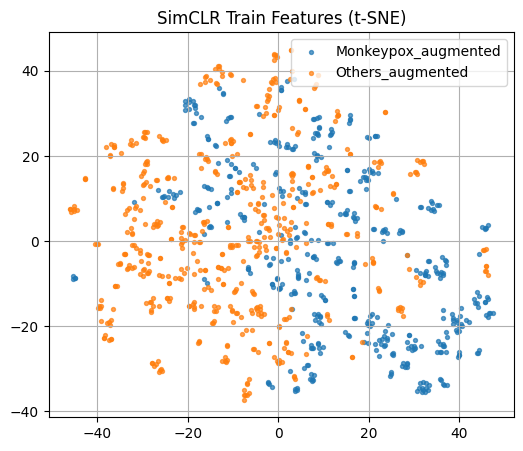

In [11]:
def extract_features(dataloader, encoder):
    encoder.eval()
    feats, labs = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            h = encoder(imgs)  # [B, 2048]
            feats.append(h.cpu().numpy())
            labs.append(labels.numpy())
    feats = np.concatenate(feats, axis=0)
    labs = np.concatenate(labs, axis=0)
    return feats, labs

def subset_for_vis(dataloader, max_samples=1000):
    xs, ys = [], []
    total = 0
    for imgs, labels in dataloader:
        if total >= max_samples:
            break
        take = min(imgs.size(0), max_samples - total)
        xs.append(imgs[:take])
        ys.append(labels[:take])
        total += take
    X = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    return DataLoader(list(zip(X, y)), batch_size=BATCH_SIZE_SUP, shuffle=False)

# Build a small vis set from the train_down set
vis_loader = subset_for_vis(train_down_loader, max_samples=1000)

# Reload a plain ResNet18 encoder and load weights (ensures clean .eval() model)
encoder_vis = models.resnet18(weights=None)
encoder_vis.fc = nn.Identity()
encoder_vis.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_resnet18_encoder.pth"), map_location=DEVICE))
encoder_vis = encoder_vis.to(DEVICE)
encoder_vis.eval()

vis_features, vis_labels = extract_features(vis_loader, encoder_vis)

# t-SNE (2D)
print("Computing t-SNE on train features...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("SimCLR Train Features (t-SNE)")
plt.grid(True)
plt.show()

Computing UMAP on train features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


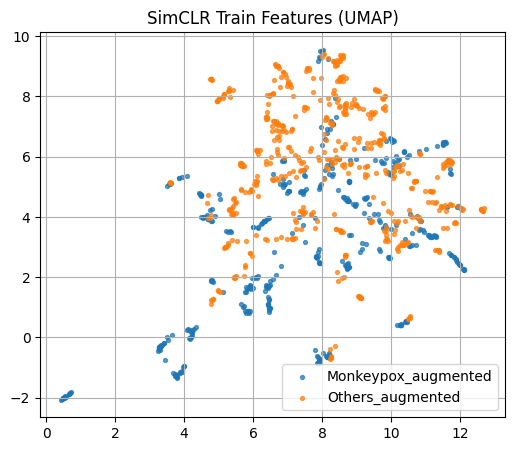

In [12]:
print("Computing UMAP on train features...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("SimCLR Train Features (UMAP)")
plt.grid(True)
plt.show()

****SSL Loss Curve****

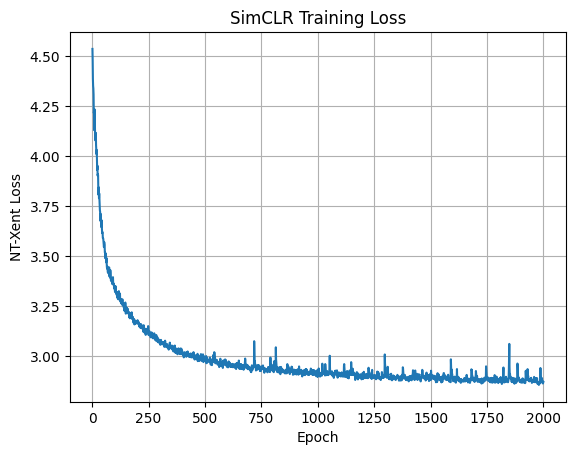

In [13]:
plot_curve(ssl_loss_history, "SimCLR Training Loss", "Epoch", "NT-Xent Loss")


****Downstream Linear Evaluation****

In [14]:
# Freeze encoder, train linear classifier on train_down, validate on val_down
encoder_linear = models.resnet18(weights=None)
encoder_linear.fc = nn.Identity()
encoder_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_resnet18_encoder.pth"), map_location=DEVICE))
encoder_linear = encoder_linear.to(DEVICE)
for p in encoder_linear.parameters():
    p.requires_grad = False
encoder_linear.eval()

classifier = nn.Linear(FEATURE_DIM, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    # Train classifier
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_down_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = encoder_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)
        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss)
    lin_train_accs.append(train_acc)

    # Validate
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_down_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            feats = encoder_linear(imgs)
            logits = classifier(feats)
            loss = criterion_ce(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss = running_loss / total
    val_acc = correct / total
    lin_val_losses.append(val_loss)
    lin_val_accs.append(val_acc)
    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f} | ValLoss={val_loss:.4f} Acc={val_acc:.3f}")


Starting linear evaluation...


Linear Epoch 1/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 1: TrainLoss=0.6660 Acc=0.572 | ValLoss=0.6192 Acc=0.688


Linear Epoch 2/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 2: TrainLoss=0.5920 Acc=0.690 | ValLoss=0.5604 Acc=0.744


Linear Epoch 3/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 3: TrainLoss=0.5483 Acc=0.728 | ValLoss=0.5237 Acc=0.766


Linear Epoch 4/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 4: TrainLoss=0.5220 Acc=0.767 | ValLoss=0.4995 Acc=0.775


Linear Epoch 5/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 5: TrainLoss=0.5024 Acc=0.777 | ValLoss=0.4799 Acc=0.778


Linear Epoch 6/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 6: TrainLoss=0.4871 Acc=0.788 | ValLoss=0.4704 Acc=0.787


Linear Epoch 7/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 7: TrainLoss=0.4753 Acc=0.788 | ValLoss=0.4533 Acc=0.787


Linear Epoch 8/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 8: TrainLoss=0.4640 Acc=0.795 | ValLoss=0.4444 Acc=0.803


Linear Epoch 9/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 9: TrainLoss=0.4546 Acc=0.811 | ValLoss=0.4342 Acc=0.806


Linear Epoch 10/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 10: TrainLoss=0.4454 Acc=0.815 | ValLoss=0.4266 Acc=0.828


Linear Epoch 11/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 11: TrainLoss=0.4382 Acc=0.810 | ValLoss=0.4173 Acc=0.838


Linear Epoch 12/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 12: TrainLoss=0.4317 Acc=0.821 | ValLoss=0.4122 Acc=0.850


Linear Epoch 13/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 13: TrainLoss=0.4242 Acc=0.824 | ValLoss=0.4047 Acc=0.850


Linear Epoch 14/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 14: TrainLoss=0.4184 Acc=0.825 | ValLoss=0.3971 Acc=0.847


Linear Epoch 15/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 15: TrainLoss=0.4136 Acc=0.827 | ValLoss=0.3921 Acc=0.856


Linear Epoch 16/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 16: TrainLoss=0.4076 Acc=0.837 | ValLoss=0.3908 Acc=0.863


Linear Epoch 17/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 17: TrainLoss=0.4058 Acc=0.829 | ValLoss=0.3815 Acc=0.850


Linear Epoch 18/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 18: TrainLoss=0.3999 Acc=0.842 | ValLoss=0.3813 Acc=0.869


Linear Epoch 19/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 19: TrainLoss=0.3955 Acc=0.840 | ValLoss=0.3775 Acc=0.875


Linear Epoch 20/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 20: TrainLoss=0.3899 Acc=0.843 | ValLoss=0.3700 Acc=0.875


Linear Epoch 21/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 21: TrainLoss=0.3863 Acc=0.843 | ValLoss=0.3652 Acc=0.875


Linear Epoch 22/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 22: TrainLoss=0.3825 Acc=0.853 | ValLoss=0.3636 Acc=0.878


Linear Epoch 23/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 23: TrainLoss=0.3791 Acc=0.853 | ValLoss=0.3577 Acc=0.869


Linear Epoch 24/2000: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


Linear Epoch 24: TrainLoss=0.3767 Acc=0.850 | ValLoss=0.3559 Acc=0.881


Linear Epoch 25/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 25: TrainLoss=0.3729 Acc=0.853 | ValLoss=0.3529 Acc=0.881


Linear Epoch 26/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 26: TrainLoss=0.3681 Acc=0.857 | ValLoss=0.3488 Acc=0.887


Linear Epoch 27/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 27: TrainLoss=0.3666 Acc=0.858 | ValLoss=0.3449 Acc=0.878


Linear Epoch 28/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 28: TrainLoss=0.3631 Acc=0.857 | ValLoss=0.3432 Acc=0.887


Linear Epoch 29/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 29: TrainLoss=0.3599 Acc=0.861 | ValLoss=0.3436 Acc=0.887


Linear Epoch 30/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 30: TrainLoss=0.3580 Acc=0.851 | ValLoss=0.3385 Acc=0.887


Linear Epoch 31/2000: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Linear Epoch 31: TrainLoss=0.3556 Acc=0.859 | ValLoss=0.3356 Acc=0.891


Linear Epoch 32/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 32: TrainLoss=0.3516 Acc=0.861 | ValLoss=0.3340 Acc=0.887


Linear Epoch 33/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 33: TrainLoss=0.3494 Acc=0.860 | ValLoss=0.3305 Acc=0.894


Linear Epoch 34/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 34: TrainLoss=0.3472 Acc=0.861 | ValLoss=0.3295 Acc=0.887


Linear Epoch 35/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 35: TrainLoss=0.3451 Acc=0.862 | ValLoss=0.3257 Acc=0.884


Linear Epoch 36/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 36: TrainLoss=0.3433 Acc=0.861 | ValLoss=0.3248 Acc=0.891


Linear Epoch 37/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 37: TrainLoss=0.3396 Acc=0.863 | ValLoss=0.3217 Acc=0.887


Linear Epoch 38/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 38: TrainLoss=0.3379 Acc=0.864 | ValLoss=0.3234 Acc=0.897


Linear Epoch 39/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 39: TrainLoss=0.3359 Acc=0.865 | ValLoss=0.3194 Acc=0.891


Linear Epoch 40/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 40: TrainLoss=0.3328 Acc=0.864 | ValLoss=0.3184 Acc=0.894


Linear Epoch 41/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 41: TrainLoss=0.3324 Acc=0.867 | ValLoss=0.3157 Acc=0.887


Linear Epoch 42/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 42: TrainLoss=0.3299 Acc=0.868 | ValLoss=0.3132 Acc=0.891


Linear Epoch 43/2000: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


Linear Epoch 43: TrainLoss=0.3278 Acc=0.869 | ValLoss=0.3137 Acc=0.894


Linear Epoch 44/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 44: TrainLoss=0.3275 Acc=0.863 | ValLoss=0.3099 Acc=0.894


Linear Epoch 45/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 45: TrainLoss=0.3246 Acc=0.865 | ValLoss=0.3092 Acc=0.894


Linear Epoch 46/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 46: TrainLoss=0.3209 Acc=0.869 | ValLoss=0.3080 Acc=0.891


Linear Epoch 47/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 47: TrainLoss=0.3191 Acc=0.870 | ValLoss=0.3056 Acc=0.897


Linear Epoch 48/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 48: TrainLoss=0.3177 Acc=0.870 | ValLoss=0.3054 Acc=0.894


Linear Epoch 49/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 49: TrainLoss=0.3161 Acc=0.871 | ValLoss=0.3048 Acc=0.897


Linear Epoch 50/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 50: TrainLoss=0.3148 Acc=0.871 | ValLoss=0.3028 Acc=0.894


Linear Epoch 51/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 51: TrainLoss=0.3133 Acc=0.873 | ValLoss=0.2988 Acc=0.894


Linear Epoch 52/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 52: TrainLoss=0.3117 Acc=0.879 | ValLoss=0.3043 Acc=0.897


Linear Epoch 53/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 53: TrainLoss=0.3093 Acc=0.875 | ValLoss=0.2967 Acc=0.894


Linear Epoch 54/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 54: TrainLoss=0.3085 Acc=0.879 | ValLoss=0.2993 Acc=0.897


Linear Epoch 55/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 55: TrainLoss=0.3059 Acc=0.875 | ValLoss=0.2947 Acc=0.891


Linear Epoch 56/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 56: TrainLoss=0.3041 Acc=0.879 | ValLoss=0.2933 Acc=0.897


Linear Epoch 57/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 57: TrainLoss=0.3023 Acc=0.879 | ValLoss=0.2962 Acc=0.894


Linear Epoch 58/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 58: TrainLoss=0.3035 Acc=0.874 | ValLoss=0.2906 Acc=0.894


Linear Epoch 59/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 59: TrainLoss=0.3001 Acc=0.882 | ValLoss=0.2897 Acc=0.894


Linear Epoch 60/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 60: TrainLoss=0.2982 Acc=0.885 | ValLoss=0.2897 Acc=0.903


Linear Epoch 61/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 61: TrainLoss=0.2962 Acc=0.886 | ValLoss=0.2873 Acc=0.894


Linear Epoch 62/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 62: TrainLoss=0.2956 Acc=0.882 | ValLoss=0.2868 Acc=0.897


Linear Epoch 63/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 63: TrainLoss=0.2934 Acc=0.888 | ValLoss=0.2874 Acc=0.894


Linear Epoch 64/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 64: TrainLoss=0.2935 Acc=0.882 | ValLoss=0.2837 Acc=0.897


Linear Epoch 65/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 65: TrainLoss=0.2903 Acc=0.888 | ValLoss=0.2845 Acc=0.897


Linear Epoch 66/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 66: TrainLoss=0.2891 Acc=0.884 | ValLoss=0.2827 Acc=0.897


Linear Epoch 67/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 67: TrainLoss=0.2881 Acc=0.892 | ValLoss=0.2812 Acc=0.897


Linear Epoch 68/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 68: TrainLoss=0.2864 Acc=0.889 | ValLoss=0.2810 Acc=0.897


Linear Epoch 69/2000: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


Linear Epoch 69: TrainLoss=0.2851 Acc=0.889 | ValLoss=0.2795 Acc=0.900


Linear Epoch 70/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 70: TrainLoss=0.2835 Acc=0.894 | ValLoss=0.2781 Acc=0.891


Linear Epoch 71/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 71: TrainLoss=0.2822 Acc=0.893 | ValLoss=0.2773 Acc=0.891


Linear Epoch 72/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 72: TrainLoss=0.2813 Acc=0.895 | ValLoss=0.2771 Acc=0.897


Linear Epoch 73/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 73: TrainLoss=0.2797 Acc=0.892 | ValLoss=0.2750 Acc=0.891


Linear Epoch 74/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 74: TrainLoss=0.2793 Acc=0.898 | ValLoss=0.2761 Acc=0.897


Linear Epoch 75/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 75: TrainLoss=0.2792 Acc=0.891 | ValLoss=0.2729 Acc=0.897


Linear Epoch 76/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 76: TrainLoss=0.2765 Acc=0.894 | ValLoss=0.2723 Acc=0.897


Linear Epoch 77/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 77: TrainLoss=0.2750 Acc=0.898 | ValLoss=0.2739 Acc=0.897


Linear Epoch 78/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 78: TrainLoss=0.2752 Acc=0.898 | ValLoss=0.2740 Acc=0.900


Linear Epoch 79/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 79: TrainLoss=0.2734 Acc=0.900 | ValLoss=0.2695 Acc=0.897


Linear Epoch 80/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 80: TrainLoss=0.2713 Acc=0.899 | ValLoss=0.2698 Acc=0.897


Linear Epoch 81/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 81: TrainLoss=0.2704 Acc=0.900 | ValLoss=0.2677 Acc=0.900


Linear Epoch 82/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 82: TrainLoss=0.2690 Acc=0.904 | ValLoss=0.2702 Acc=0.900


Linear Epoch 83/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 83: TrainLoss=0.2678 Acc=0.902 | ValLoss=0.2665 Acc=0.897


Linear Epoch 84/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 84: TrainLoss=0.2663 Acc=0.907 | ValLoss=0.2661 Acc=0.894


Linear Epoch 85/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 85: TrainLoss=0.2654 Acc=0.904 | ValLoss=0.2650 Acc=0.894


Linear Epoch 86/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 86: TrainLoss=0.2649 Acc=0.909 | ValLoss=0.2673 Acc=0.906


Linear Epoch 87/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 87: TrainLoss=0.2643 Acc=0.899 | ValLoss=0.2630 Acc=0.897


Linear Epoch 88/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 88: TrainLoss=0.2626 Acc=0.908 | ValLoss=0.2628 Acc=0.897


Linear Epoch 89/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 89: TrainLoss=0.2608 Acc=0.908 | ValLoss=0.2641 Acc=0.906


Linear Epoch 90/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 90: TrainLoss=0.2599 Acc=0.911 | ValLoss=0.2619 Acc=0.900


Linear Epoch 91/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 91: TrainLoss=0.2588 Acc=0.910 | ValLoss=0.2626 Acc=0.906


Linear Epoch 92/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 92: TrainLoss=0.2584 Acc=0.908 | ValLoss=0.2594 Acc=0.903


Linear Epoch 93/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 93: TrainLoss=0.2566 Acc=0.908 | ValLoss=0.2610 Acc=0.906


Linear Epoch 94/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 94: TrainLoss=0.2559 Acc=0.911 | ValLoss=0.2584 Acc=0.900


Linear Epoch 95/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 95: TrainLoss=0.2549 Acc=0.912 | ValLoss=0.2611 Acc=0.906


Linear Epoch 96/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 96: TrainLoss=0.2540 Acc=0.913 | ValLoss=0.2565 Acc=0.906


Linear Epoch 97/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 97: TrainLoss=0.2522 Acc=0.918 | ValLoss=0.2570 Acc=0.903


Linear Epoch 98/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 98: TrainLoss=0.2514 Acc=0.918 | ValLoss=0.2562 Acc=0.906


Linear Epoch 99/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 99: TrainLoss=0.2508 Acc=0.920 | ValLoss=0.2560 Acc=0.906


Linear Epoch 100/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 100: TrainLoss=0.2494 Acc=0.917 | ValLoss=0.2547 Acc=0.906


Linear Epoch 101/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 101: TrainLoss=0.2484 Acc=0.919 | ValLoss=0.2541 Acc=0.909


Linear Epoch 102/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 102: TrainLoss=0.2474 Acc=0.918 | ValLoss=0.2536 Acc=0.916


Linear Epoch 103/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 103: TrainLoss=0.2465 Acc=0.917 | ValLoss=0.2516 Acc=0.916


Linear Epoch 104/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 104: TrainLoss=0.2458 Acc=0.917 | ValLoss=0.2513 Acc=0.912


Linear Epoch 105/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 105: TrainLoss=0.2460 Acc=0.914 | ValLoss=0.2524 Acc=0.909


Linear Epoch 106/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 106: TrainLoss=0.2439 Acc=0.920 | ValLoss=0.2503 Acc=0.909


Linear Epoch 107/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 107: TrainLoss=0.2425 Acc=0.921 | ValLoss=0.2503 Acc=0.909


Linear Epoch 108/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 108: TrainLoss=0.2419 Acc=0.920 | ValLoss=0.2493 Acc=0.909


Linear Epoch 109/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 109: TrainLoss=0.2408 Acc=0.922 | ValLoss=0.2486 Acc=0.906


Linear Epoch 110/2000: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


Linear Epoch 110: TrainLoss=0.2399 Acc=0.922 | ValLoss=0.2477 Acc=0.912


Linear Epoch 111/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 111: TrainLoss=0.2398 Acc=0.923 | ValLoss=0.2483 Acc=0.909


Linear Epoch 112/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 112: TrainLoss=0.2387 Acc=0.919 | ValLoss=0.2456 Acc=0.916


Linear Epoch 113/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 113: TrainLoss=0.2375 Acc=0.923 | ValLoss=0.2458 Acc=0.922


Linear Epoch 114/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 114: TrainLoss=0.2366 Acc=0.923 | ValLoss=0.2462 Acc=0.916


Linear Epoch 115/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 115: TrainLoss=0.2357 Acc=0.923 | ValLoss=0.2436 Acc=0.922


Linear Epoch 116/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 116: TrainLoss=0.2348 Acc=0.925 | ValLoss=0.2442 Acc=0.909


Linear Epoch 117/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 117: TrainLoss=0.2342 Acc=0.924 | ValLoss=0.2445 Acc=0.912


Linear Epoch 118/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 118: TrainLoss=0.2330 Acc=0.925 | ValLoss=0.2432 Acc=0.919


Linear Epoch 119/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 119: TrainLoss=0.2323 Acc=0.926 | ValLoss=0.2423 Acc=0.922


Linear Epoch 120/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 120: TrainLoss=0.2312 Acc=0.926 | ValLoss=0.2434 Acc=0.909


Linear Epoch 121/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 121: TrainLoss=0.2304 Acc=0.926 | ValLoss=0.2404 Acc=0.925


Linear Epoch 122/2000: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


Linear Epoch 122: TrainLoss=0.2299 Acc=0.929 | ValLoss=0.2413 Acc=0.916


Linear Epoch 123/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 123: TrainLoss=0.2286 Acc=0.927 | ValLoss=0.2402 Acc=0.919


Linear Epoch 124/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 124: TrainLoss=0.2282 Acc=0.929 | ValLoss=0.2402 Acc=0.916


Linear Epoch 125/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 125: TrainLoss=0.2278 Acc=0.926 | ValLoss=0.2397 Acc=0.916


Linear Epoch 126/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 126: TrainLoss=0.2266 Acc=0.930 | ValLoss=0.2381 Acc=0.922


Linear Epoch 127/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 127: TrainLoss=0.2253 Acc=0.927 | ValLoss=0.2381 Acc=0.922


Linear Epoch 128/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 128: TrainLoss=0.2260 Acc=0.930 | ValLoss=0.2420 Acc=0.912


Linear Epoch 129/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 129: TrainLoss=0.2254 Acc=0.925 | ValLoss=0.2360 Acc=0.925


Linear Epoch 130/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 130: TrainLoss=0.2233 Acc=0.931 | ValLoss=0.2375 Acc=0.922


Linear Epoch 131/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 131: TrainLoss=0.2229 Acc=0.929 | ValLoss=0.2350 Acc=0.922


Linear Epoch 132/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 132: TrainLoss=0.2218 Acc=0.931 | ValLoss=0.2369 Acc=0.912


Linear Epoch 133/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 133: TrainLoss=0.2214 Acc=0.929 | ValLoss=0.2342 Acc=0.925


Linear Epoch 134/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 134: TrainLoss=0.2207 Acc=0.929 | ValLoss=0.2335 Acc=0.925


Linear Epoch 135/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 135: TrainLoss=0.2201 Acc=0.933 | ValLoss=0.2355 Acc=0.916


Linear Epoch 136/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 136: TrainLoss=0.2189 Acc=0.933 | ValLoss=0.2334 Acc=0.928


Linear Epoch 137/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 137: TrainLoss=0.2183 Acc=0.932 | ValLoss=0.2344 Acc=0.916


Linear Epoch 138/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 138: TrainLoss=0.2174 Acc=0.933 | ValLoss=0.2320 Acc=0.925


Linear Epoch 139/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 139: TrainLoss=0.2162 Acc=0.934 | ValLoss=0.2316 Acc=0.925


Linear Epoch 140/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 140: TrainLoss=0.2156 Acc=0.937 | ValLoss=0.2316 Acc=0.928


Linear Epoch 141/2000: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Linear Epoch 141: TrainLoss=0.2148 Acc=0.936 | ValLoss=0.2304 Acc=0.925


Linear Epoch 142/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 142: TrainLoss=0.2144 Acc=0.937 | ValLoss=0.2294 Acc=0.922


Linear Epoch 143/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 143: TrainLoss=0.2146 Acc=0.935 | ValLoss=0.2310 Acc=0.928


Linear Epoch 144/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 144: TrainLoss=0.2128 Acc=0.940 | ValLoss=0.2299 Acc=0.925


Linear Epoch 145/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 145: TrainLoss=0.2119 Acc=0.939 | ValLoss=0.2296 Acc=0.928


Linear Epoch 146/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 146: TrainLoss=0.2116 Acc=0.940 | ValLoss=0.2282 Acc=0.925


Linear Epoch 147/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 147: TrainLoss=0.2113 Acc=0.937 | ValLoss=0.2272 Acc=0.922


Linear Epoch 148/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 148: TrainLoss=0.2103 Acc=0.940 | ValLoss=0.2275 Acc=0.925


Linear Epoch 149/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 149: TrainLoss=0.2093 Acc=0.940 | ValLoss=0.2268 Acc=0.925


Linear Epoch 150/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 150: TrainLoss=0.2084 Acc=0.940 | ValLoss=0.2260 Acc=0.925


Linear Epoch 151/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 151: TrainLoss=0.2081 Acc=0.938 | ValLoss=0.2278 Acc=0.922


Linear Epoch 152/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 152: TrainLoss=0.2075 Acc=0.942 | ValLoss=0.2260 Acc=0.928


Linear Epoch 153/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 153: TrainLoss=0.2066 Acc=0.943 | ValLoss=0.2261 Acc=0.928


Linear Epoch 154/2000: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Linear Epoch 154: TrainLoss=0.2077 Acc=0.936 | ValLoss=0.2285 Acc=0.919


Linear Epoch 155/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 155: TrainLoss=0.2068 Acc=0.940 | ValLoss=0.2238 Acc=0.922


Linear Epoch 156/2000: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Linear Epoch 156: TrainLoss=0.2054 Acc=0.943 | ValLoss=0.2234 Acc=0.925


Linear Epoch 157/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 157: TrainLoss=0.2044 Acc=0.942 | ValLoss=0.2233 Acc=0.925


Linear Epoch 158/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 158: TrainLoss=0.2037 Acc=0.941 | ValLoss=0.2238 Acc=0.928


Linear Epoch 159/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 159: TrainLoss=0.2034 Acc=0.942 | ValLoss=0.2221 Acc=0.922


Linear Epoch 160/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 160: TrainLoss=0.2023 Acc=0.944 | ValLoss=0.2229 Acc=0.928


Linear Epoch 161/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 161: TrainLoss=0.2018 Acc=0.945 | ValLoss=0.2213 Acc=0.922


Linear Epoch 162/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 162: TrainLoss=0.2019 Acc=0.944 | ValLoss=0.2207 Acc=0.919


Linear Epoch 163/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 163: TrainLoss=0.2004 Acc=0.944 | ValLoss=0.2218 Acc=0.928


Linear Epoch 164/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 164: TrainLoss=0.1999 Acc=0.945 | ValLoss=0.2206 Acc=0.925


Linear Epoch 165/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 165: TrainLoss=0.1995 Acc=0.944 | ValLoss=0.2198 Acc=0.922


Linear Epoch 166/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 166: TrainLoss=0.1992 Acc=0.944 | ValLoss=0.2200 Acc=0.928


Linear Epoch 167/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 167: TrainLoss=0.1978 Acc=0.946 | ValLoss=0.2189 Acc=0.922


Linear Epoch 168/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 168: TrainLoss=0.1981 Acc=0.944 | ValLoss=0.2237 Acc=0.919


Linear Epoch 169/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 169: TrainLoss=0.1978 Acc=0.948 | ValLoss=0.2185 Acc=0.922


Linear Epoch 170/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 170: TrainLoss=0.1961 Acc=0.944 | ValLoss=0.2174 Acc=0.922


Linear Epoch 171/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 171: TrainLoss=0.1955 Acc=0.947 | ValLoss=0.2175 Acc=0.925


Linear Epoch 172/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 172: TrainLoss=0.1947 Acc=0.946 | ValLoss=0.2180 Acc=0.928


Linear Epoch 173/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 173: TrainLoss=0.1942 Acc=0.947 | ValLoss=0.2167 Acc=0.925


Linear Epoch 174/2000: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


Linear Epoch 174: TrainLoss=0.1939 Acc=0.947 | ValLoss=0.2159 Acc=0.925


Linear Epoch 175/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 175: TrainLoss=0.1933 Acc=0.947 | ValLoss=0.2159 Acc=0.925


Linear Epoch 176/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 176: TrainLoss=0.1931 Acc=0.947 | ValLoss=0.2174 Acc=0.928


Linear Epoch 177/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 177: TrainLoss=0.1921 Acc=0.948 | ValLoss=0.2147 Acc=0.922


Linear Epoch 178/2000: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Linear Epoch 178: TrainLoss=0.1923 Acc=0.949 | ValLoss=0.2143 Acc=0.922


Linear Epoch 179/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 179: TrainLoss=0.1910 Acc=0.949 | ValLoss=0.2154 Acc=0.928


Linear Epoch 180/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 180: TrainLoss=0.1903 Acc=0.947 | ValLoss=0.2138 Acc=0.922


Linear Epoch 181/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 181: TrainLoss=0.1902 Acc=0.947 | ValLoss=0.2138 Acc=0.925


Linear Epoch 182/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 182: TrainLoss=0.1896 Acc=0.949 | ValLoss=0.2148 Acc=0.931


Linear Epoch 183/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 183: TrainLoss=0.1887 Acc=0.948 | ValLoss=0.2129 Acc=0.928


Linear Epoch 184/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 184: TrainLoss=0.1883 Acc=0.950 | ValLoss=0.2128 Acc=0.925


Linear Epoch 185/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 185: TrainLoss=0.1879 Acc=0.950 | ValLoss=0.2149 Acc=0.931


Linear Epoch 186/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 186: TrainLoss=0.1870 Acc=0.950 | ValLoss=0.2121 Acc=0.928


Linear Epoch 187/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 187: TrainLoss=0.1869 Acc=0.950 | ValLoss=0.2135 Acc=0.931


Linear Epoch 188/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 188: TrainLoss=0.1863 Acc=0.951 | ValLoss=0.2118 Acc=0.928


Linear Epoch 189/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 189: TrainLoss=0.1858 Acc=0.951 | ValLoss=0.2106 Acc=0.928


Linear Epoch 190/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 190: TrainLoss=0.1858 Acc=0.953 | ValLoss=0.2109 Acc=0.928


Linear Epoch 191/2000: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Linear Epoch 191: TrainLoss=0.1846 Acc=0.951 | ValLoss=0.2123 Acc=0.931


Linear Epoch 192/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 192: TrainLoss=0.1842 Acc=0.951 | ValLoss=0.2102 Acc=0.928


Linear Epoch 193/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 193: TrainLoss=0.1852 Acc=0.951 | ValLoss=0.2087 Acc=0.922


Linear Epoch 194/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 194: TrainLoss=0.1839 Acc=0.952 | ValLoss=0.2104 Acc=0.928


Linear Epoch 195/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 195: TrainLoss=0.1827 Acc=0.955 | ValLoss=0.2086 Acc=0.925


Linear Epoch 196/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 196: TrainLoss=0.1820 Acc=0.954 | ValLoss=0.2091 Acc=0.925


Linear Epoch 197/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 197: TrainLoss=0.1819 Acc=0.955 | ValLoss=0.2101 Acc=0.931


Linear Epoch 198/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 198: TrainLoss=0.1811 Acc=0.955 | ValLoss=0.2086 Acc=0.928


Linear Epoch 199/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 199: TrainLoss=0.1808 Acc=0.951 | ValLoss=0.2072 Acc=0.928


Linear Epoch 200/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 200: TrainLoss=0.1801 Acc=0.954 | ValLoss=0.2070 Acc=0.928


Linear Epoch 201/2000: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Linear Epoch 201: TrainLoss=0.1796 Acc=0.955 | ValLoss=0.2067 Acc=0.925


Linear Epoch 202/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 202: TrainLoss=0.1789 Acc=0.957 | ValLoss=0.2071 Acc=0.928


Linear Epoch 203/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 203: TrainLoss=0.1789 Acc=0.955 | ValLoss=0.2068 Acc=0.928


Linear Epoch 204/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 204: TrainLoss=0.1787 Acc=0.947 | ValLoss=0.2050 Acc=0.922


Linear Epoch 205/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 205: TrainLoss=0.1787 Acc=0.957 | ValLoss=0.2072 Acc=0.931


Linear Epoch 206/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 206: TrainLoss=0.1776 Acc=0.956 | ValLoss=0.2060 Acc=0.928


Linear Epoch 207/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 207: TrainLoss=0.1770 Acc=0.955 | ValLoss=0.2042 Acc=0.925


Linear Epoch 208/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 208: TrainLoss=0.1764 Acc=0.957 | ValLoss=0.2080 Acc=0.928


Linear Epoch 209/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 209: TrainLoss=0.1761 Acc=0.955 | ValLoss=0.2036 Acc=0.925


Linear Epoch 210/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 210: TrainLoss=0.1755 Acc=0.956 | ValLoss=0.2047 Acc=0.928


Linear Epoch 211/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 211: TrainLoss=0.1749 Acc=0.959 | ValLoss=0.2042 Acc=0.928


Linear Epoch 212/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 212: TrainLoss=0.1744 Acc=0.956 | ValLoss=0.2032 Acc=0.928


Linear Epoch 213/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 213: TrainLoss=0.1739 Acc=0.957 | ValLoss=0.2029 Acc=0.928


Linear Epoch 214/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 214: TrainLoss=0.1733 Acc=0.958 | ValLoss=0.2032 Acc=0.928


Linear Epoch 215/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 215: TrainLoss=0.1731 Acc=0.956 | ValLoss=0.2020 Acc=0.925


Linear Epoch 216/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 216: TrainLoss=0.1730 Acc=0.959 | ValLoss=0.2017 Acc=0.928


Linear Epoch 217/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 217: TrainLoss=0.1721 Acc=0.957 | ValLoss=0.2021 Acc=0.928


Linear Epoch 218/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 218: TrainLoss=0.1716 Acc=0.958 | ValLoss=0.2019 Acc=0.928


Linear Epoch 219/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 219: TrainLoss=0.1712 Acc=0.959 | ValLoss=0.2023 Acc=0.931


Linear Epoch 220/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 220: TrainLoss=0.1707 Acc=0.957 | ValLoss=0.2012 Acc=0.928


Linear Epoch 221/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 221: TrainLoss=0.1701 Acc=0.959 | ValLoss=0.2011 Acc=0.928


Linear Epoch 222/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 222: TrainLoss=0.1697 Acc=0.958 | ValLoss=0.2006 Acc=0.928


Linear Epoch 223/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 223: TrainLoss=0.1699 Acc=0.959 | ValLoss=0.2020 Acc=0.931


Linear Epoch 224/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 224: TrainLoss=0.1701 Acc=0.956 | ValLoss=0.1995 Acc=0.928


Linear Epoch 225/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 225: TrainLoss=0.1695 Acc=0.958 | ValLoss=0.2023 Acc=0.931


Linear Epoch 226/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 226: TrainLoss=0.1685 Acc=0.960 | ValLoss=0.1985 Acc=0.922


Linear Epoch 227/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 227: TrainLoss=0.1675 Acc=0.961 | ValLoss=0.2004 Acc=0.931


Linear Epoch 228/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 228: TrainLoss=0.1675 Acc=0.961 | ValLoss=0.2001 Acc=0.928


Linear Epoch 229/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 229: TrainLoss=0.1669 Acc=0.959 | ValLoss=0.1987 Acc=0.928


Linear Epoch 230/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 230: TrainLoss=0.1669 Acc=0.961 | ValLoss=0.1978 Acc=0.928


Linear Epoch 231/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 231: TrainLoss=0.1669 Acc=0.957 | ValLoss=0.1969 Acc=0.922


Linear Epoch 232/2000: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Linear Epoch 232: TrainLoss=0.1664 Acc=0.958 | ValLoss=0.1977 Acc=0.928


Linear Epoch 233/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 233: TrainLoss=0.1660 Acc=0.961 | ValLoss=0.1988 Acc=0.934


Linear Epoch 234/2000: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


Linear Epoch 234: TrainLoss=0.1649 Acc=0.960 | ValLoss=0.1969 Acc=0.928


Linear Epoch 235/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 235: TrainLoss=0.1648 Acc=0.962 | ValLoss=0.1979 Acc=0.928


Linear Epoch 236/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 236: TrainLoss=0.1639 Acc=0.961 | ValLoss=0.1965 Acc=0.928


Linear Epoch 237/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 237: TrainLoss=0.1645 Acc=0.960 | ValLoss=0.1954 Acc=0.928


Linear Epoch 238/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 238: TrainLoss=0.1641 Acc=0.960 | ValLoss=0.1997 Acc=0.938


Linear Epoch 239/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 239: TrainLoss=0.1630 Acc=0.958 | ValLoss=0.1948 Acc=0.928


Linear Epoch 240/2000: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


Linear Epoch 240: TrainLoss=0.1632 Acc=0.963 | ValLoss=0.1991 Acc=0.938


Linear Epoch 241/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 241: TrainLoss=0.1626 Acc=0.955 | ValLoss=0.1942 Acc=0.922


Linear Epoch 242/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 242: TrainLoss=0.1634 Acc=0.963 | ValLoss=0.1964 Acc=0.928


Linear Epoch 243/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 243: TrainLoss=0.1627 Acc=0.963 | ValLoss=0.1973 Acc=0.938


Linear Epoch 244/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 244: TrainLoss=0.1623 Acc=0.958 | ValLoss=0.1933 Acc=0.925


Linear Epoch 245/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 245: TrainLoss=0.1604 Acc=0.963 | ValLoss=0.1951 Acc=0.928


Linear Epoch 246/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 246: TrainLoss=0.1602 Acc=0.961 | ValLoss=0.1931 Acc=0.925


Linear Epoch 247/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 247: TrainLoss=0.1604 Acc=0.965 | ValLoss=0.1948 Acc=0.928


Linear Epoch 248/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 248: TrainLoss=0.1597 Acc=0.962 | ValLoss=0.1929 Acc=0.928


Linear Epoch 249/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 249: TrainLoss=0.1595 Acc=0.965 | ValLoss=0.1931 Acc=0.928


Linear Epoch 250/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 250: TrainLoss=0.1593 Acc=0.960 | ValLoss=0.1922 Acc=0.928


Linear Epoch 251/2000: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Linear Epoch 251: TrainLoss=0.1580 Acc=0.966 | ValLoss=0.1934 Acc=0.928


Linear Epoch 252/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 252: TrainLoss=0.1580 Acc=0.963 | ValLoss=0.1923 Acc=0.928


Linear Epoch 253/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 253: TrainLoss=0.1573 Acc=0.966 | ValLoss=0.1931 Acc=0.928


Linear Epoch 254/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 254: TrainLoss=0.1577 Acc=0.959 | ValLoss=0.1907 Acc=0.928


Linear Epoch 255/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 255: TrainLoss=0.1565 Acc=0.963 | ValLoss=0.1927 Acc=0.931


Linear Epoch 256/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 256: TrainLoss=0.1561 Acc=0.966 | ValLoss=0.1918 Acc=0.928


Linear Epoch 257/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 257: TrainLoss=0.1558 Acc=0.966 | ValLoss=0.1919 Acc=0.928


Linear Epoch 258/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 258: TrainLoss=0.1554 Acc=0.966 | ValLoss=0.1902 Acc=0.928


Linear Epoch 259/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 259: TrainLoss=0.1555 Acc=0.966 | ValLoss=0.1923 Acc=0.931


Linear Epoch 260/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 260: TrainLoss=0.1549 Acc=0.964 | ValLoss=0.1903 Acc=0.928


Linear Epoch 261/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 261: TrainLoss=0.1551 Acc=0.966 | ValLoss=0.1902 Acc=0.928


Linear Epoch 262/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 262: TrainLoss=0.1540 Acc=0.966 | ValLoss=0.1910 Acc=0.928


Linear Epoch 263/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 263: TrainLoss=0.1536 Acc=0.966 | ValLoss=0.1910 Acc=0.928


Linear Epoch 264/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 264: TrainLoss=0.1535 Acc=0.963 | ValLoss=0.1887 Acc=0.928


Linear Epoch 265/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 265: TrainLoss=0.1531 Acc=0.966 | ValLoss=0.1892 Acc=0.928


Linear Epoch 266/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 266: TrainLoss=0.1529 Acc=0.966 | ValLoss=0.1883 Acc=0.928


Linear Epoch 267/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 267: TrainLoss=0.1524 Acc=0.966 | ValLoss=0.1886 Acc=0.928


Linear Epoch 268/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 268: TrainLoss=0.1516 Acc=0.967 | ValLoss=0.1886 Acc=0.928


Linear Epoch 269/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 269: TrainLoss=0.1518 Acc=0.966 | ValLoss=0.1884 Acc=0.928


Linear Epoch 270/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 270: TrainLoss=0.1514 Acc=0.965 | ValLoss=0.1888 Acc=0.928


Linear Epoch 271/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 271: TrainLoss=0.1508 Acc=0.967 | ValLoss=0.1875 Acc=0.928


Linear Epoch 272/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 272: TrainLoss=0.1506 Acc=0.967 | ValLoss=0.1883 Acc=0.928


Linear Epoch 273/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 273: TrainLoss=0.1506 Acc=0.963 | ValLoss=0.1868 Acc=0.928


Linear Epoch 274/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 274: TrainLoss=0.1507 Acc=0.964 | ValLoss=0.1892 Acc=0.938


Linear Epoch 275/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 275: TrainLoss=0.1496 Acc=0.966 | ValLoss=0.1868 Acc=0.928


Linear Epoch 276/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 276: TrainLoss=0.1503 Acc=0.966 | ValLoss=0.1888 Acc=0.938


Linear Epoch 277/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 277: TrainLoss=0.1492 Acc=0.966 | ValLoss=0.1876 Acc=0.928


Linear Epoch 278/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 278: TrainLoss=0.1488 Acc=0.967 | ValLoss=0.1879 Acc=0.931


Linear Epoch 279/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 279: TrainLoss=0.1476 Acc=0.966 | ValLoss=0.1857 Acc=0.928


Linear Epoch 280/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 280: TrainLoss=0.1488 Acc=0.966 | ValLoss=0.1876 Acc=0.931


Linear Epoch 281/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 281: TrainLoss=0.1474 Acc=0.968 | ValLoss=0.1852 Acc=0.928


Linear Epoch 282/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 282: TrainLoss=0.1473 Acc=0.966 | ValLoss=0.1864 Acc=0.934


Linear Epoch 283/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 283: TrainLoss=0.1471 Acc=0.969 | ValLoss=0.1862 Acc=0.934


Linear Epoch 284/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 284: TrainLoss=0.1464 Acc=0.968 | ValLoss=0.1851 Acc=0.928


Linear Epoch 285/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 285: TrainLoss=0.1461 Acc=0.966 | ValLoss=0.1858 Acc=0.928


Linear Epoch 286/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 286: TrainLoss=0.1459 Acc=0.968 | ValLoss=0.1854 Acc=0.928


Linear Epoch 287/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 287: TrainLoss=0.1456 Acc=0.968 | ValLoss=0.1846 Acc=0.928


Linear Epoch 288/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 288: TrainLoss=0.1457 Acc=0.966 | ValLoss=0.1833 Acc=0.928


Linear Epoch 289/2000: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Linear Epoch 289: TrainLoss=0.1456 Acc=0.965 | ValLoss=0.1842 Acc=0.928


Linear Epoch 290/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 290: TrainLoss=0.1453 Acc=0.968 | ValLoss=0.1854 Acc=0.934


Linear Epoch 291/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 291: TrainLoss=0.1450 Acc=0.967 | ValLoss=0.1843 Acc=0.934


Linear Epoch 292/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 292: TrainLoss=0.1440 Acc=0.966 | ValLoss=0.1835 Acc=0.928


Linear Epoch 293/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 293: TrainLoss=0.1438 Acc=0.969 | ValLoss=0.1827 Acc=0.928


Linear Epoch 294/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 294: TrainLoss=0.1434 Acc=0.967 | ValLoss=0.1836 Acc=0.934


Linear Epoch 295/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 295: TrainLoss=0.1431 Acc=0.968 | ValLoss=0.1828 Acc=0.928


Linear Epoch 296/2000: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Linear Epoch 296: TrainLoss=0.1429 Acc=0.969 | ValLoss=0.1833 Acc=0.934


Linear Epoch 297/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 297: TrainLoss=0.1427 Acc=0.967 | ValLoss=0.1837 Acc=0.934


Linear Epoch 298/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 298: TrainLoss=0.1427 Acc=0.967 | ValLoss=0.1837 Acc=0.941


Linear Epoch 299/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 299: TrainLoss=0.1426 Acc=0.966 | ValLoss=0.1817 Acc=0.934


Linear Epoch 300/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 300: TrainLoss=0.1414 Acc=0.969 | ValLoss=0.1835 Acc=0.941


Linear Epoch 301/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 301: TrainLoss=0.1419 Acc=0.963 | ValLoss=0.1808 Acc=0.928


Linear Epoch 302/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 302: TrainLoss=0.1411 Acc=0.966 | ValLoss=0.1831 Acc=0.941


Linear Epoch 303/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 303: TrainLoss=0.1411 Acc=0.965 | ValLoss=0.1816 Acc=0.934


Linear Epoch 304/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 304: TrainLoss=0.1402 Acc=0.969 | ValLoss=0.1813 Acc=0.934


Linear Epoch 305/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 305: TrainLoss=0.1406 Acc=0.968 | ValLoss=0.1815 Acc=0.934


Linear Epoch 306/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 306: TrainLoss=0.1404 Acc=0.965 | ValLoss=0.1799 Acc=0.928


Linear Epoch 307/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 307: TrainLoss=0.1397 Acc=0.969 | ValLoss=0.1814 Acc=0.934


Linear Epoch 308/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 308: TrainLoss=0.1388 Acc=0.969 | ValLoss=0.1801 Acc=0.928


Linear Epoch 309/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 309: TrainLoss=0.1388 Acc=0.967 | ValLoss=0.1831 Acc=0.944


Linear Epoch 310/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 310: TrainLoss=0.1386 Acc=0.968 | ValLoss=0.1797 Acc=0.934


Linear Epoch 311/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 311: TrainLoss=0.1387 Acc=0.968 | ValLoss=0.1787 Acc=0.928


Linear Epoch 312/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 312: TrainLoss=0.1378 Acc=0.969 | ValLoss=0.1804 Acc=0.934


Linear Epoch 313/2000: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Linear Epoch 313: TrainLoss=0.1375 Acc=0.969 | ValLoss=0.1800 Acc=0.934


Linear Epoch 314/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 314: TrainLoss=0.1380 Acc=0.967 | ValLoss=0.1813 Acc=0.941


Linear Epoch 315/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 315: TrainLoss=0.1370 Acc=0.967 | ValLoss=0.1786 Acc=0.931


Linear Epoch 316/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 316: TrainLoss=0.1369 Acc=0.968 | ValLoss=0.1799 Acc=0.938


Linear Epoch 317/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 317: TrainLoss=0.1362 Acc=0.969 | ValLoss=0.1783 Acc=0.934


Linear Epoch 318/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 318: TrainLoss=0.1361 Acc=0.969 | ValLoss=0.1776 Acc=0.928


Linear Epoch 319/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 319: TrainLoss=0.1359 Acc=0.969 | ValLoss=0.1782 Acc=0.934


Linear Epoch 320/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 320: TrainLoss=0.1359 Acc=0.968 | ValLoss=0.1771 Acc=0.928


Linear Epoch 321/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 321: TrainLoss=0.1351 Acc=0.969 | ValLoss=0.1793 Acc=0.938


Linear Epoch 322/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 322: TrainLoss=0.1354 Acc=0.968 | ValLoss=0.1778 Acc=0.934


Linear Epoch 323/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 323: TrainLoss=0.1348 Acc=0.969 | ValLoss=0.1788 Acc=0.938


Linear Epoch 324/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 324: TrainLoss=0.1350 Acc=0.968 | ValLoss=0.1763 Acc=0.931


Linear Epoch 325/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 325: TrainLoss=0.1348 Acc=0.969 | ValLoss=0.1774 Acc=0.934


Linear Epoch 326/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 326: TrainLoss=0.1347 Acc=0.969 | ValLoss=0.1763 Acc=0.928


Linear Epoch 327/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 327: TrainLoss=0.1336 Acc=0.969 | ValLoss=0.1773 Acc=0.938


Linear Epoch 328/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 328: TrainLoss=0.1335 Acc=0.969 | ValLoss=0.1764 Acc=0.934


Linear Epoch 329/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 329: TrainLoss=0.1330 Acc=0.969 | ValLoss=0.1761 Acc=0.934


Linear Epoch 330/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 330: TrainLoss=0.1330 Acc=0.969 | ValLoss=0.1783 Acc=0.938


Linear Epoch 331/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 331: TrainLoss=0.1329 Acc=0.968 | ValLoss=0.1754 Acc=0.934


Linear Epoch 332/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 332: TrainLoss=0.1320 Acc=0.969 | ValLoss=0.1775 Acc=0.941


Linear Epoch 333/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 333: TrainLoss=0.1321 Acc=0.969 | ValLoss=0.1756 Acc=0.934


Linear Epoch 334/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 334: TrainLoss=0.1322 Acc=0.969 | ValLoss=0.1782 Acc=0.941


Linear Epoch 335/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 335: TrainLoss=0.1319 Acc=0.969 | ValLoss=0.1761 Acc=0.938


Linear Epoch 336/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 336: TrainLoss=0.1310 Acc=0.969 | ValLoss=0.1764 Acc=0.938


Linear Epoch 337/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 337: TrainLoss=0.1308 Acc=0.970 | ValLoss=0.1751 Acc=0.934


Linear Epoch 338/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 338: TrainLoss=0.1307 Acc=0.970 | ValLoss=0.1743 Acc=0.934


Linear Epoch 339/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 339: TrainLoss=0.1304 Acc=0.969 | ValLoss=0.1752 Acc=0.938


Linear Epoch 340/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 340: TrainLoss=0.1302 Acc=0.969 | ValLoss=0.1741 Acc=0.934


Linear Epoch 341/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 341: TrainLoss=0.1302 Acc=0.969 | ValLoss=0.1735 Acc=0.934


Linear Epoch 342/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 342: TrainLoss=0.1297 Acc=0.971 | ValLoss=0.1750 Acc=0.938


Linear Epoch 343/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 343: TrainLoss=0.1293 Acc=0.971 | ValLoss=0.1752 Acc=0.938


Linear Epoch 344/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 344: TrainLoss=0.1297 Acc=0.969 | ValLoss=0.1754 Acc=0.938


Linear Epoch 345/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 345: TrainLoss=0.1293 Acc=0.969 | ValLoss=0.1739 Acc=0.934


Linear Epoch 346/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 346: TrainLoss=0.1286 Acc=0.969 | ValLoss=0.1749 Acc=0.938


Linear Epoch 347/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 347: TrainLoss=0.1286 Acc=0.969 | ValLoss=0.1742 Acc=0.941


Linear Epoch 348/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 348: TrainLoss=0.1279 Acc=0.970 | ValLoss=0.1721 Acc=0.934


Linear Epoch 349/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 349: TrainLoss=0.1280 Acc=0.970 | ValLoss=0.1744 Acc=0.938


Linear Epoch 350/2000: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Linear Epoch 350: TrainLoss=0.1282 Acc=0.970 | ValLoss=0.1731 Acc=0.938


Linear Epoch 351/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 351: TrainLoss=0.1272 Acc=0.970 | ValLoss=0.1734 Acc=0.938


Linear Epoch 352/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 352: TrainLoss=0.1274 Acc=0.971 | ValLoss=0.1722 Acc=0.934


Linear Epoch 353/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 353: TrainLoss=0.1291 Acc=0.970 | ValLoss=0.1759 Acc=0.944


Linear Epoch 354/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 354: TrainLoss=0.1271 Acc=0.971 | ValLoss=0.1734 Acc=0.941


Linear Epoch 355/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 355: TrainLoss=0.1265 Acc=0.970 | ValLoss=0.1736 Acc=0.941


Linear Epoch 356/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 356: TrainLoss=0.1260 Acc=0.971 | ValLoss=0.1715 Acc=0.934


Linear Epoch 357/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 357: TrainLoss=0.1258 Acc=0.972 | ValLoss=0.1728 Acc=0.941


Linear Epoch 358/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 358: TrainLoss=0.1263 Acc=0.971 | ValLoss=0.1712 Acc=0.938


Linear Epoch 359/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 359: TrainLoss=0.1255 Acc=0.971 | ValLoss=0.1709 Acc=0.934


Linear Epoch 360/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 360: TrainLoss=0.1252 Acc=0.971 | ValLoss=0.1721 Acc=0.941


Linear Epoch 361/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 361: TrainLoss=0.1256 Acc=0.973 | ValLoss=0.1717 Acc=0.938


Linear Epoch 362/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 362: TrainLoss=0.1260 Acc=0.969 | ValLoss=0.1700 Acc=0.934


Linear Epoch 363/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 363: TrainLoss=0.1249 Acc=0.972 | ValLoss=0.1716 Acc=0.941


Linear Epoch 364/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 364: TrainLoss=0.1243 Acc=0.971 | ValLoss=0.1724 Acc=0.941


Linear Epoch 365/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 365: TrainLoss=0.1241 Acc=0.972 | ValLoss=0.1723 Acc=0.944


Linear Epoch 366/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 366: TrainLoss=0.1242 Acc=0.971 | ValLoss=0.1711 Acc=0.941


Linear Epoch 367/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 367: TrainLoss=0.1238 Acc=0.971 | ValLoss=0.1696 Acc=0.934


Linear Epoch 368/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 368: TrainLoss=0.1232 Acc=0.972 | ValLoss=0.1705 Acc=0.941


Linear Epoch 369/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 369: TrainLoss=0.1229 Acc=0.971 | ValLoss=0.1720 Acc=0.941


Linear Epoch 370/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 370: TrainLoss=0.1227 Acc=0.972 | ValLoss=0.1692 Acc=0.934


Linear Epoch 371/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 371: TrainLoss=0.1226 Acc=0.972 | ValLoss=0.1730 Acc=0.944


Linear Epoch 372/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 372: TrainLoss=0.1224 Acc=0.973 | ValLoss=0.1690 Acc=0.938


Linear Epoch 373/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 373: TrainLoss=0.1220 Acc=0.973 | ValLoss=0.1701 Acc=0.941


Linear Epoch 374/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 374: TrainLoss=0.1216 Acc=0.973 | ValLoss=0.1696 Acc=0.941


Linear Epoch 375/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 375: TrainLoss=0.1215 Acc=0.972 | ValLoss=0.1690 Acc=0.938


Linear Epoch 376/2000: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Linear Epoch 376: TrainLoss=0.1212 Acc=0.973 | ValLoss=0.1690 Acc=0.941


Linear Epoch 377/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 377: TrainLoss=0.1209 Acc=0.972 | ValLoss=0.1695 Acc=0.941


Linear Epoch 378/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 378: TrainLoss=0.1206 Acc=0.973 | ValLoss=0.1687 Acc=0.941


Linear Epoch 379/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 379: TrainLoss=0.1205 Acc=0.973 | ValLoss=0.1686 Acc=0.938


Linear Epoch 380/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 380: TrainLoss=0.1204 Acc=0.973 | ValLoss=0.1695 Acc=0.941


Linear Epoch 381/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 381: TrainLoss=0.1205 Acc=0.971 | ValLoss=0.1685 Acc=0.941


Linear Epoch 382/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 382: TrainLoss=0.1202 Acc=0.975 | ValLoss=0.1693 Acc=0.941


Linear Epoch 383/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 383: TrainLoss=0.1197 Acc=0.972 | ValLoss=0.1682 Acc=0.941


Linear Epoch 384/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 384: TrainLoss=0.1193 Acc=0.972 | ValLoss=0.1677 Acc=0.941


Linear Epoch 385/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 385: TrainLoss=0.1191 Acc=0.973 | ValLoss=0.1680 Acc=0.941


Linear Epoch 386/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 386: TrainLoss=0.1188 Acc=0.972 | ValLoss=0.1683 Acc=0.941


Linear Epoch 387/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 387: TrainLoss=0.1186 Acc=0.973 | ValLoss=0.1673 Acc=0.941


Linear Epoch 388/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 388: TrainLoss=0.1189 Acc=0.973 | ValLoss=0.1676 Acc=0.941


Linear Epoch 389/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 389: TrainLoss=0.1184 Acc=0.973 | ValLoss=0.1688 Acc=0.941


Linear Epoch 390/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 390: TrainLoss=0.1181 Acc=0.973 | ValLoss=0.1664 Acc=0.938


Linear Epoch 391/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 391: TrainLoss=0.1184 Acc=0.975 | ValLoss=0.1683 Acc=0.944


Linear Epoch 392/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 392: TrainLoss=0.1175 Acc=0.973 | ValLoss=0.1671 Acc=0.941


Linear Epoch 393/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 393: TrainLoss=0.1178 Acc=0.973 | ValLoss=0.1667 Acc=0.941


Linear Epoch 394/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 394: TrainLoss=0.1174 Acc=0.974 | ValLoss=0.1671 Acc=0.941


Linear Epoch 395/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 395: TrainLoss=0.1167 Acc=0.973 | ValLoss=0.1664 Acc=0.941


Linear Epoch 396/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 396: TrainLoss=0.1171 Acc=0.974 | ValLoss=0.1662 Acc=0.941


Linear Epoch 397/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 397: TrainLoss=0.1185 Acc=0.973 | ValLoss=0.1701 Acc=0.944


Linear Epoch 398/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 398: TrainLoss=0.1163 Acc=0.975 | ValLoss=0.1654 Acc=0.938


Linear Epoch 399/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 399: TrainLoss=0.1163 Acc=0.973 | ValLoss=0.1674 Acc=0.941


Linear Epoch 400/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 400: TrainLoss=0.1158 Acc=0.974 | ValLoss=0.1662 Acc=0.941


Linear Epoch 401/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 401: TrainLoss=0.1158 Acc=0.976 | ValLoss=0.1664 Acc=0.941


Linear Epoch 402/2000: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Linear Epoch 402: TrainLoss=0.1153 Acc=0.974 | ValLoss=0.1670 Acc=0.941


Linear Epoch 403/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 403: TrainLoss=0.1151 Acc=0.973 | ValLoss=0.1653 Acc=0.941


Linear Epoch 404/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 404: TrainLoss=0.1153 Acc=0.973 | ValLoss=0.1663 Acc=0.941


Linear Epoch 405/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 405: TrainLoss=0.1148 Acc=0.974 | ValLoss=0.1655 Acc=0.941


Linear Epoch 406/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 406: TrainLoss=0.1144 Acc=0.973 | ValLoss=0.1665 Acc=0.941


Linear Epoch 407/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 407: TrainLoss=0.1153 Acc=0.973 | ValLoss=0.1640 Acc=0.941


Linear Epoch 408/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 408: TrainLoss=0.1145 Acc=0.974 | ValLoss=0.1669 Acc=0.941


Linear Epoch 409/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 409: TrainLoss=0.1139 Acc=0.973 | ValLoss=0.1654 Acc=0.941


Linear Epoch 410/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 410: TrainLoss=0.1136 Acc=0.976 | ValLoss=0.1648 Acc=0.941


Linear Epoch 411/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 411: TrainLoss=0.1135 Acc=0.974 | ValLoss=0.1645 Acc=0.941


Linear Epoch 412/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 412: TrainLoss=0.1130 Acc=0.974 | ValLoss=0.1655 Acc=0.941


Linear Epoch 413/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 413: TrainLoss=0.1131 Acc=0.976 | ValLoss=0.1647 Acc=0.941


Linear Epoch 414/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 414: TrainLoss=0.1129 Acc=0.975 | ValLoss=0.1650 Acc=0.941


Linear Epoch 415/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 415: TrainLoss=0.1127 Acc=0.975 | ValLoss=0.1643 Acc=0.941


Linear Epoch 416/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 416: TrainLoss=0.1126 Acc=0.975 | ValLoss=0.1654 Acc=0.941


Linear Epoch 417/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 417: TrainLoss=0.1124 Acc=0.974 | ValLoss=0.1639 Acc=0.941


Linear Epoch 418/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 418: TrainLoss=0.1121 Acc=0.977 | ValLoss=0.1640 Acc=0.941


Linear Epoch 419/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 419: TrainLoss=0.1118 Acc=0.976 | ValLoss=0.1632 Acc=0.941


Linear Epoch 420/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 420: TrainLoss=0.1118 Acc=0.976 | ValLoss=0.1628 Acc=0.938


Linear Epoch 421/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 421: TrainLoss=0.1114 Acc=0.975 | ValLoss=0.1653 Acc=0.941


Linear Epoch 422/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 422: TrainLoss=0.1112 Acc=0.976 | ValLoss=0.1640 Acc=0.941


Linear Epoch 423/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 423: TrainLoss=0.1110 Acc=0.974 | ValLoss=0.1645 Acc=0.941


Linear Epoch 424/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 424: TrainLoss=0.1114 Acc=0.974 | ValLoss=0.1650 Acc=0.944


Linear Epoch 425/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 425: TrainLoss=0.1110 Acc=0.975 | ValLoss=0.1643 Acc=0.941


Linear Epoch 426/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 426: TrainLoss=0.1105 Acc=0.976 | ValLoss=0.1626 Acc=0.941


Linear Epoch 427/2000: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


Linear Epoch 427: TrainLoss=0.1107 Acc=0.974 | ValLoss=0.1642 Acc=0.944


Linear Epoch 428/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 428: TrainLoss=0.1101 Acc=0.973 | ValLoss=0.1625 Acc=0.941


Linear Epoch 429/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 429: TrainLoss=0.1097 Acc=0.975 | ValLoss=0.1630 Acc=0.941


Linear Epoch 430/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 430: TrainLoss=0.1095 Acc=0.975 | ValLoss=0.1624 Acc=0.941


Linear Epoch 431/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 431: TrainLoss=0.1095 Acc=0.976 | ValLoss=0.1622 Acc=0.941


Linear Epoch 432/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 432: TrainLoss=0.1093 Acc=0.974 | ValLoss=0.1624 Acc=0.941


Linear Epoch 433/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 433: TrainLoss=0.1091 Acc=0.977 | ValLoss=0.1612 Acc=0.941


Linear Epoch 434/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 434: TrainLoss=0.1095 Acc=0.975 | ValLoss=0.1616 Acc=0.941


Linear Epoch 435/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 435: TrainLoss=0.1089 Acc=0.974 | ValLoss=0.1625 Acc=0.941


Linear Epoch 436/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 436: TrainLoss=0.1084 Acc=0.976 | ValLoss=0.1625 Acc=0.941


Linear Epoch 437/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 437: TrainLoss=0.1081 Acc=0.976 | ValLoss=0.1621 Acc=0.941


Linear Epoch 438/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 438: TrainLoss=0.1083 Acc=0.977 | ValLoss=0.1613 Acc=0.944


Linear Epoch 439/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 439: TrainLoss=0.1078 Acc=0.976 | ValLoss=0.1621 Acc=0.941


Linear Epoch 440/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 440: TrainLoss=0.1075 Acc=0.975 | ValLoss=0.1609 Acc=0.941


Linear Epoch 441/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 441: TrainLoss=0.1076 Acc=0.975 | ValLoss=0.1620 Acc=0.941


Linear Epoch 442/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 442: TrainLoss=0.1078 Acc=0.975 | ValLoss=0.1632 Acc=0.944


Linear Epoch 443/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 443: TrainLoss=0.1074 Acc=0.976 | ValLoss=0.1604 Acc=0.944


Linear Epoch 444/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 444: TrainLoss=0.1068 Acc=0.974 | ValLoss=0.1623 Acc=0.941


Linear Epoch 445/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 445: TrainLoss=0.1070 Acc=0.976 | ValLoss=0.1600 Acc=0.941


Linear Epoch 446/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 446: TrainLoss=0.1066 Acc=0.975 | ValLoss=0.1604 Acc=0.941


Linear Epoch 447/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 447: TrainLoss=0.1063 Acc=0.976 | ValLoss=0.1618 Acc=0.941


Linear Epoch 448/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 448: TrainLoss=0.1060 Acc=0.978 | ValLoss=0.1610 Acc=0.941


Linear Epoch 449/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 449: TrainLoss=0.1059 Acc=0.976 | ValLoss=0.1607 Acc=0.941


Linear Epoch 450/2000: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Linear Epoch 450: TrainLoss=0.1060 Acc=0.975 | ValLoss=0.1615 Acc=0.941


Linear Epoch 451/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 451: TrainLoss=0.1058 Acc=0.977 | ValLoss=0.1611 Acc=0.941


Linear Epoch 452/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 452: TrainLoss=0.1056 Acc=0.976 | ValLoss=0.1603 Acc=0.941


Linear Epoch 453/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 453: TrainLoss=0.1055 Acc=0.975 | ValLoss=0.1605 Acc=0.941


Linear Epoch 454/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 454: TrainLoss=0.1053 Acc=0.978 | ValLoss=0.1616 Acc=0.941


Linear Epoch 455/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 455: TrainLoss=0.1053 Acc=0.974 | ValLoss=0.1615 Acc=0.941


Linear Epoch 456/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 456: TrainLoss=0.1052 Acc=0.977 | ValLoss=0.1609 Acc=0.941


Linear Epoch 457/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 457: TrainLoss=0.1053 Acc=0.977 | ValLoss=0.1585 Acc=0.944


Linear Epoch 458/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 458: TrainLoss=0.1042 Acc=0.978 | ValLoss=0.1611 Acc=0.941


Linear Epoch 459/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 459: TrainLoss=0.1040 Acc=0.978 | ValLoss=0.1598 Acc=0.941


Linear Epoch 460/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 460: TrainLoss=0.1039 Acc=0.976 | ValLoss=0.1595 Acc=0.941


Linear Epoch 461/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 461: TrainLoss=0.1039 Acc=0.976 | ValLoss=0.1613 Acc=0.944


Linear Epoch 462/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 462: TrainLoss=0.1038 Acc=0.977 | ValLoss=0.1591 Acc=0.944


Linear Epoch 463/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 463: TrainLoss=0.1037 Acc=0.976 | ValLoss=0.1614 Acc=0.941


Linear Epoch 464/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 464: TrainLoss=0.1034 Acc=0.977 | ValLoss=0.1578 Acc=0.941


Linear Epoch 465/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 465: TrainLoss=0.1033 Acc=0.976 | ValLoss=0.1608 Acc=0.944


Linear Epoch 466/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 466: TrainLoss=0.1034 Acc=0.976 | ValLoss=0.1591 Acc=0.944


Linear Epoch 467/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 467: TrainLoss=0.1027 Acc=0.977 | ValLoss=0.1616 Acc=0.944


Linear Epoch 468/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 468: TrainLoss=0.1034 Acc=0.977 | ValLoss=0.1574 Acc=0.944


Linear Epoch 469/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 469: TrainLoss=0.1027 Acc=0.977 | ValLoss=0.1590 Acc=0.941


Linear Epoch 470/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 470: TrainLoss=0.1023 Acc=0.977 | ValLoss=0.1593 Acc=0.941


Linear Epoch 471/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 471: TrainLoss=0.1020 Acc=0.976 | ValLoss=0.1589 Acc=0.944


Linear Epoch 472/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 472: TrainLoss=0.1020 Acc=0.978 | ValLoss=0.1580 Acc=0.944


Linear Epoch 473/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 473: TrainLoss=0.1017 Acc=0.977 | ValLoss=0.1589 Acc=0.944


Linear Epoch 474/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 474: TrainLoss=0.1014 Acc=0.979 | ValLoss=0.1585 Acc=0.944


Linear Epoch 475/2000: 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


Linear Epoch 475: TrainLoss=0.1017 Acc=0.976 | ValLoss=0.1597 Acc=0.941


Linear Epoch 476/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 476: TrainLoss=0.1007 Acc=0.978 | ValLoss=0.1573 Acc=0.944


Linear Epoch 477/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 477: TrainLoss=0.1011 Acc=0.976 | ValLoss=0.1576 Acc=0.944


Linear Epoch 478/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 478: TrainLoss=0.1007 Acc=0.978 | ValLoss=0.1587 Acc=0.944


Linear Epoch 479/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 479: TrainLoss=0.1012 Acc=0.976 | ValLoss=0.1571 Acc=0.944


Linear Epoch 480/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 480: TrainLoss=0.1003 Acc=0.980 | ValLoss=0.1587 Acc=0.941


Linear Epoch 481/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 481: TrainLoss=0.1005 Acc=0.978 | ValLoss=0.1588 Acc=0.944


Linear Epoch 482/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 482: TrainLoss=0.1002 Acc=0.978 | ValLoss=0.1574 Acc=0.944


Linear Epoch 483/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 483: TrainLoss=0.0997 Acc=0.979 | ValLoss=0.1581 Acc=0.941


Linear Epoch 484/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 484: TrainLoss=0.0999 Acc=0.977 | ValLoss=0.1594 Acc=0.941


Linear Epoch 485/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 485: TrainLoss=0.0997 Acc=0.980 | ValLoss=0.1565 Acc=0.944


Linear Epoch 486/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 486: TrainLoss=0.0993 Acc=0.977 | ValLoss=0.1578 Acc=0.944


Linear Epoch 487/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 487: TrainLoss=0.0992 Acc=0.978 | ValLoss=0.1573 Acc=0.944


Linear Epoch 488/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 488: TrainLoss=0.0990 Acc=0.978 | ValLoss=0.1575 Acc=0.944


Linear Epoch 489/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 489: TrainLoss=0.0986 Acc=0.979 | ValLoss=0.1571 Acc=0.944


Linear Epoch 490/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 490: TrainLoss=0.0989 Acc=0.978 | ValLoss=0.1564 Acc=0.944


Linear Epoch 491/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 491: TrainLoss=0.0985 Acc=0.980 | ValLoss=0.1564 Acc=0.944


Linear Epoch 492/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 492: TrainLoss=0.0984 Acc=0.977 | ValLoss=0.1562 Acc=0.944


Linear Epoch 493/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 493: TrainLoss=0.0981 Acc=0.976 | ValLoss=0.1575 Acc=0.944


Linear Epoch 494/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 494: TrainLoss=0.0981 Acc=0.979 | ValLoss=0.1565 Acc=0.944


Linear Epoch 495/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 495: TrainLoss=0.0982 Acc=0.978 | ValLoss=0.1560 Acc=0.944


Linear Epoch 496/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 496: TrainLoss=0.0978 Acc=0.980 | ValLoss=0.1559 Acc=0.944


Linear Epoch 497/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 497: TrainLoss=0.0972 Acc=0.979 | ValLoss=0.1585 Acc=0.944


Linear Epoch 498/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 498: TrainLoss=0.0975 Acc=0.978 | ValLoss=0.1570 Acc=0.944


Linear Epoch 499/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 499: TrainLoss=0.0969 Acc=0.980 | ValLoss=0.1556 Acc=0.944


Linear Epoch 500/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 500: TrainLoss=0.0974 Acc=0.980 | ValLoss=0.1554 Acc=0.944


Linear Epoch 501/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 501: TrainLoss=0.0971 Acc=0.980 | ValLoss=0.1556 Acc=0.944


Linear Epoch 502/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 502: TrainLoss=0.0971 Acc=0.977 | ValLoss=0.1553 Acc=0.944


Linear Epoch 503/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 503: TrainLoss=0.0968 Acc=0.977 | ValLoss=0.1558 Acc=0.944


Linear Epoch 504/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 504: TrainLoss=0.0966 Acc=0.979 | ValLoss=0.1547 Acc=0.944


Linear Epoch 505/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 505: TrainLoss=0.0963 Acc=0.980 | ValLoss=0.1564 Acc=0.944


Linear Epoch 506/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 506: TrainLoss=0.0963 Acc=0.980 | ValLoss=0.1554 Acc=0.944


Linear Epoch 507/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 507: TrainLoss=0.0963 Acc=0.978 | ValLoss=0.1556 Acc=0.944


Linear Epoch 508/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 508: TrainLoss=0.0961 Acc=0.980 | ValLoss=0.1558 Acc=0.944


Linear Epoch 509/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 509: TrainLoss=0.0960 Acc=0.980 | ValLoss=0.1551 Acc=0.944


Linear Epoch 510/2000: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Linear Epoch 510: TrainLoss=0.0956 Acc=0.980 | ValLoss=0.1551 Acc=0.944


Linear Epoch 511/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 511: TrainLoss=0.0953 Acc=0.981 | ValLoss=0.1556 Acc=0.944


Linear Epoch 512/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 512: TrainLoss=0.0951 Acc=0.980 | ValLoss=0.1553 Acc=0.944


Linear Epoch 513/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 513: TrainLoss=0.0949 Acc=0.980 | ValLoss=0.1551 Acc=0.944


Linear Epoch 514/2000: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Linear Epoch 514: TrainLoss=0.0948 Acc=0.980 | ValLoss=0.1549 Acc=0.944


Linear Epoch 515/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 515: TrainLoss=0.0946 Acc=0.980 | ValLoss=0.1565 Acc=0.944


Linear Epoch 516/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 516: TrainLoss=0.0945 Acc=0.980 | ValLoss=0.1552 Acc=0.944


Linear Epoch 517/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 517: TrainLoss=0.0944 Acc=0.980 | ValLoss=0.1559 Acc=0.944


Linear Epoch 518/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 518: TrainLoss=0.0945 Acc=0.981 | ValLoss=0.1573 Acc=0.947


Linear Epoch 519/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 519: TrainLoss=0.0938 Acc=0.981 | ValLoss=0.1535 Acc=0.944


Linear Epoch 520/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 520: TrainLoss=0.0939 Acc=0.982 | ValLoss=0.1547 Acc=0.944


Linear Epoch 521/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 521: TrainLoss=0.0940 Acc=0.980 | ValLoss=0.1539 Acc=0.944


Linear Epoch 522/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 522: TrainLoss=0.0937 Acc=0.980 | ValLoss=0.1559 Acc=0.944


Linear Epoch 523/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 523: TrainLoss=0.0932 Acc=0.980 | ValLoss=0.1547 Acc=0.944


Linear Epoch 524/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 524: TrainLoss=0.0932 Acc=0.981 | ValLoss=0.1554 Acc=0.944


Linear Epoch 525/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 525: TrainLoss=0.0933 Acc=0.981 | ValLoss=0.1539 Acc=0.944


Linear Epoch 526/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 526: TrainLoss=0.0933 Acc=0.982 | ValLoss=0.1546 Acc=0.944


Linear Epoch 527/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 527: TrainLoss=0.0928 Acc=0.980 | ValLoss=0.1542 Acc=0.944


Linear Epoch 528/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 528: TrainLoss=0.0927 Acc=0.981 | ValLoss=0.1534 Acc=0.944


Linear Epoch 529/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 529: TrainLoss=0.0923 Acc=0.980 | ValLoss=0.1547 Acc=0.944


Linear Epoch 530/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 530: TrainLoss=0.0930 Acc=0.982 | ValLoss=0.1528 Acc=0.944


Linear Epoch 531/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 531: TrainLoss=0.0922 Acc=0.980 | ValLoss=0.1550 Acc=0.944


Linear Epoch 532/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 532: TrainLoss=0.0923 Acc=0.980 | ValLoss=0.1542 Acc=0.944


Linear Epoch 533/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 533: TrainLoss=0.0922 Acc=0.982 | ValLoss=0.1546 Acc=0.944


Linear Epoch 534/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 534: TrainLoss=0.0920 Acc=0.980 | ValLoss=0.1533 Acc=0.944


Linear Epoch 535/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 535: TrainLoss=0.0917 Acc=0.980 | ValLoss=0.1541 Acc=0.944


Linear Epoch 536/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 536: TrainLoss=0.0915 Acc=0.984 | ValLoss=0.1528 Acc=0.944


Linear Epoch 537/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 537: TrainLoss=0.0918 Acc=0.979 | ValLoss=0.1534 Acc=0.944


Linear Epoch 538/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 538: TrainLoss=0.0914 Acc=0.981 | ValLoss=0.1552 Acc=0.944


Linear Epoch 539/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 539: TrainLoss=0.0913 Acc=0.981 | ValLoss=0.1522 Acc=0.944


Linear Epoch 540/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 540: TrainLoss=0.0911 Acc=0.981 | ValLoss=0.1542 Acc=0.944


Linear Epoch 541/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 541: TrainLoss=0.0907 Acc=0.981 | ValLoss=0.1537 Acc=0.944


Linear Epoch 542/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 542: TrainLoss=0.0906 Acc=0.981 | ValLoss=0.1532 Acc=0.944


Linear Epoch 543/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 543: TrainLoss=0.0907 Acc=0.981 | ValLoss=0.1532 Acc=0.944


Linear Epoch 544/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 544: TrainLoss=0.0908 Acc=0.982 | ValLoss=0.1554 Acc=0.947


Linear Epoch 545/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 545: TrainLoss=0.0903 Acc=0.983 | ValLoss=0.1526 Acc=0.944


Linear Epoch 546/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 546: TrainLoss=0.0904 Acc=0.980 | ValLoss=0.1522 Acc=0.944


Linear Epoch 547/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 547: TrainLoss=0.0900 Acc=0.982 | ValLoss=0.1535 Acc=0.944


Linear Epoch 548/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 548: TrainLoss=0.0898 Acc=0.982 | ValLoss=0.1522 Acc=0.944


Linear Epoch 549/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 549: TrainLoss=0.0895 Acc=0.983 | ValLoss=0.1541 Acc=0.944


Linear Epoch 550/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 550: TrainLoss=0.0896 Acc=0.981 | ValLoss=0.1521 Acc=0.944


Linear Epoch 551/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 551: TrainLoss=0.0896 Acc=0.982 | ValLoss=0.1526 Acc=0.944


Linear Epoch 552/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 552: TrainLoss=0.0896 Acc=0.982 | ValLoss=0.1532 Acc=0.944


Linear Epoch 553/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 553: TrainLoss=0.0892 Acc=0.982 | ValLoss=0.1526 Acc=0.944


Linear Epoch 554/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 554: TrainLoss=0.0888 Acc=0.982 | ValLoss=0.1518 Acc=0.944


Linear Epoch 555/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 555: TrainLoss=0.0891 Acc=0.981 | ValLoss=0.1526 Acc=0.944


Linear Epoch 556/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 556: TrainLoss=0.0889 Acc=0.983 | ValLoss=0.1533 Acc=0.944


Linear Epoch 557/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 557: TrainLoss=0.0883 Acc=0.981 | ValLoss=0.1521 Acc=0.944


Linear Epoch 558/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 558: TrainLoss=0.0883 Acc=0.981 | ValLoss=0.1513 Acc=0.944


Linear Epoch 559/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 559: TrainLoss=0.0884 Acc=0.983 | ValLoss=0.1517 Acc=0.944


Linear Epoch 560/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 560: TrainLoss=0.0885 Acc=0.982 | ValLoss=0.1518 Acc=0.944


Linear Epoch 561/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 561: TrainLoss=0.0880 Acc=0.983 | ValLoss=0.1521 Acc=0.944


Linear Epoch 562/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 562: TrainLoss=0.0881 Acc=0.983 | ValLoss=0.1524 Acc=0.944


Linear Epoch 563/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 563: TrainLoss=0.0874 Acc=0.982 | ValLoss=0.1515 Acc=0.944


Linear Epoch 564/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 564: TrainLoss=0.0877 Acc=0.982 | ValLoss=0.1510 Acc=0.947


Linear Epoch 565/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 565: TrainLoss=0.0874 Acc=0.983 | ValLoss=0.1524 Acc=0.944


Linear Epoch 566/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 566: TrainLoss=0.0872 Acc=0.982 | ValLoss=0.1516 Acc=0.944


Linear Epoch 567/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 567: TrainLoss=0.0874 Acc=0.983 | ValLoss=0.1516 Acc=0.944


Linear Epoch 568/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 568: TrainLoss=0.0876 Acc=0.982 | ValLoss=0.1514 Acc=0.944


Linear Epoch 569/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 569: TrainLoss=0.0869 Acc=0.983 | ValLoss=0.1525 Acc=0.944


Linear Epoch 570/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 570: TrainLoss=0.0866 Acc=0.983 | ValLoss=0.1521 Acc=0.944


Linear Epoch 571/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 571: TrainLoss=0.0865 Acc=0.983 | ValLoss=0.1512 Acc=0.944


Linear Epoch 572/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 572: TrainLoss=0.0864 Acc=0.984 | ValLoss=0.1527 Acc=0.944


Linear Epoch 573/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 573: TrainLoss=0.0867 Acc=0.984 | ValLoss=0.1513 Acc=0.944


Linear Epoch 574/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 574: TrainLoss=0.0865 Acc=0.983 | ValLoss=0.1501 Acc=0.950


Linear Epoch 575/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 575: TrainLoss=0.0865 Acc=0.984 | ValLoss=0.1541 Acc=0.947


Linear Epoch 576/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 576: TrainLoss=0.0863 Acc=0.983 | ValLoss=0.1510 Acc=0.944


Linear Epoch 577/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 577: TrainLoss=0.0863 Acc=0.984 | ValLoss=0.1538 Acc=0.947


Linear Epoch 578/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 578: TrainLoss=0.0857 Acc=0.982 | ValLoss=0.1515 Acc=0.944


Linear Epoch 579/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 579: TrainLoss=0.0855 Acc=0.984 | ValLoss=0.1504 Acc=0.947


Linear Epoch 580/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 580: TrainLoss=0.0854 Acc=0.984 | ValLoss=0.1509 Acc=0.944


Linear Epoch 581/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 581: TrainLoss=0.0853 Acc=0.984 | ValLoss=0.1511 Acc=0.944


Linear Epoch 582/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 582: TrainLoss=0.0851 Acc=0.984 | ValLoss=0.1513 Acc=0.944


Linear Epoch 583/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 583: TrainLoss=0.0852 Acc=0.985 | ValLoss=0.1497 Acc=0.950


Linear Epoch 584/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 584: TrainLoss=0.0856 Acc=0.984 | ValLoss=0.1528 Acc=0.950


Linear Epoch 585/2000: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


Linear Epoch 585: TrainLoss=0.0849 Acc=0.985 | ValLoss=0.1491 Acc=0.950


Linear Epoch 586/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 586: TrainLoss=0.0854 Acc=0.985 | ValLoss=0.1535 Acc=0.950


Linear Epoch 587/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 587: TrainLoss=0.0847 Acc=0.984 | ValLoss=0.1511 Acc=0.944


Linear Epoch 588/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 588: TrainLoss=0.0842 Acc=0.984 | ValLoss=0.1506 Acc=0.947


Linear Epoch 589/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 589: TrainLoss=0.0844 Acc=0.986 | ValLoss=0.1513 Acc=0.944


Linear Epoch 590/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 590: TrainLoss=0.0847 Acc=0.982 | ValLoss=0.1509 Acc=0.944


Linear Epoch 591/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 591: TrainLoss=0.0840 Acc=0.984 | ValLoss=0.1505 Acc=0.947


Linear Epoch 592/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 592: TrainLoss=0.0838 Acc=0.984 | ValLoss=0.1503 Acc=0.947


Linear Epoch 593/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 593: TrainLoss=0.0837 Acc=0.985 | ValLoss=0.1500 Acc=0.947


Linear Epoch 594/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 594: TrainLoss=0.0835 Acc=0.984 | ValLoss=0.1516 Acc=0.944


Linear Epoch 595/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 595: TrainLoss=0.0835 Acc=0.985 | ValLoss=0.1507 Acc=0.947


Linear Epoch 596/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 596: TrainLoss=0.0833 Acc=0.984 | ValLoss=0.1510 Acc=0.947


Linear Epoch 597/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 597: TrainLoss=0.0832 Acc=0.985 | ValLoss=0.1507 Acc=0.947


Linear Epoch 598/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 598: TrainLoss=0.0833 Acc=0.984 | ValLoss=0.1512 Acc=0.944


Linear Epoch 599/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 599: TrainLoss=0.0830 Acc=0.984 | ValLoss=0.1501 Acc=0.947


Linear Epoch 600/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 600: TrainLoss=0.0830 Acc=0.984 | ValLoss=0.1493 Acc=0.950


Linear Epoch 601/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 601: TrainLoss=0.0829 Acc=0.984 | ValLoss=0.1496 Acc=0.947


Linear Epoch 602/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 602: TrainLoss=0.0826 Acc=0.984 | ValLoss=0.1504 Acc=0.944


Linear Epoch 603/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 603: TrainLoss=0.0824 Acc=0.984 | ValLoss=0.1496 Acc=0.947


Linear Epoch 604/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 604: TrainLoss=0.0828 Acc=0.984 | ValLoss=0.1497 Acc=0.947


Linear Epoch 605/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 605: TrainLoss=0.0826 Acc=0.984 | ValLoss=0.1503 Acc=0.947


Linear Epoch 606/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 606: TrainLoss=0.0824 Acc=0.984 | ValLoss=0.1489 Acc=0.950


Linear Epoch 607/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 607: TrainLoss=0.0829 Acc=0.985 | ValLoss=0.1518 Acc=0.950


Linear Epoch 608/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 608: TrainLoss=0.0820 Acc=0.985 | ValLoss=0.1491 Acc=0.950


Linear Epoch 609/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 609: TrainLoss=0.0815 Acc=0.986 | ValLoss=0.1520 Acc=0.950


Linear Epoch 610/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 610: TrainLoss=0.0814 Acc=0.985 | ValLoss=0.1496 Acc=0.947


Linear Epoch 611/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 611: TrainLoss=0.0815 Acc=0.985 | ValLoss=0.1503 Acc=0.947


Linear Epoch 612/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 612: TrainLoss=0.0814 Acc=0.987 | ValLoss=0.1494 Acc=0.947


Linear Epoch 613/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 613: TrainLoss=0.0812 Acc=0.985 | ValLoss=0.1495 Acc=0.947


Linear Epoch 614/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 614: TrainLoss=0.0809 Acc=0.987 | ValLoss=0.1489 Acc=0.950


Linear Epoch 615/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 615: TrainLoss=0.0808 Acc=0.986 | ValLoss=0.1512 Acc=0.944


Linear Epoch 616/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 616: TrainLoss=0.0808 Acc=0.985 | ValLoss=0.1481 Acc=0.950


Linear Epoch 617/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 617: TrainLoss=0.0809 Acc=0.986 | ValLoss=0.1495 Acc=0.947


Linear Epoch 618/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 618: TrainLoss=0.0805 Acc=0.984 | ValLoss=0.1488 Acc=0.950


Linear Epoch 619/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 619: TrainLoss=0.0806 Acc=0.987 | ValLoss=0.1499 Acc=0.947


Linear Epoch 620/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 620: TrainLoss=0.0804 Acc=0.985 | ValLoss=0.1492 Acc=0.947


Linear Epoch 621/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 621: TrainLoss=0.0808 Acc=0.985 | ValLoss=0.1517 Acc=0.947


Linear Epoch 622/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 622: TrainLoss=0.0800 Acc=0.986 | ValLoss=0.1487 Acc=0.950


Linear Epoch 623/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 623: TrainLoss=0.0806 Acc=0.983 | ValLoss=0.1510 Acc=0.950


Linear Epoch 624/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 624: TrainLoss=0.0810 Acc=0.987 | ValLoss=0.1480 Acc=0.950


Linear Epoch 625/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 625: TrainLoss=0.0794 Acc=0.987 | ValLoss=0.1508 Acc=0.950


Linear Epoch 626/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 626: TrainLoss=0.0801 Acc=0.987 | ValLoss=0.1482 Acc=0.950


Linear Epoch 627/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 627: TrainLoss=0.0796 Acc=0.984 | ValLoss=0.1489 Acc=0.950


Linear Epoch 628/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 628: TrainLoss=0.0796 Acc=0.985 | ValLoss=0.1496 Acc=0.947


Linear Epoch 629/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 629: TrainLoss=0.0794 Acc=0.987 | ValLoss=0.1482 Acc=0.950


Linear Epoch 630/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 630: TrainLoss=0.0793 Acc=0.986 | ValLoss=0.1497 Acc=0.947


Linear Epoch 631/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 631: TrainLoss=0.0794 Acc=0.986 | ValLoss=0.1479 Acc=0.950


Linear Epoch 632/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 632: TrainLoss=0.0789 Acc=0.986 | ValLoss=0.1500 Acc=0.947


Linear Epoch 633/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 633: TrainLoss=0.0790 Acc=0.987 | ValLoss=0.1486 Acc=0.947


Linear Epoch 634/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 634: TrainLoss=0.0788 Acc=0.986 | ValLoss=0.1508 Acc=0.950


Linear Epoch 635/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 635: TrainLoss=0.0792 Acc=0.986 | ValLoss=0.1502 Acc=0.947


Linear Epoch 636/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 636: TrainLoss=0.0785 Acc=0.985 | ValLoss=0.1482 Acc=0.950


Linear Epoch 637/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 637: TrainLoss=0.0787 Acc=0.986 | ValLoss=0.1483 Acc=0.950


Linear Epoch 638/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 638: TrainLoss=0.0784 Acc=0.986 | ValLoss=0.1486 Acc=0.947


Linear Epoch 639/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 639: TrainLoss=0.0781 Acc=0.986 | ValLoss=0.1497 Acc=0.947


Linear Epoch 640/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 640: TrainLoss=0.0784 Acc=0.985 | ValLoss=0.1491 Acc=0.947


Linear Epoch 641/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 641: TrainLoss=0.0781 Acc=0.987 | ValLoss=0.1489 Acc=0.947


Linear Epoch 642/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 642: TrainLoss=0.0780 Acc=0.987 | ValLoss=0.1474 Acc=0.950


Linear Epoch 643/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 643: TrainLoss=0.0776 Acc=0.987 | ValLoss=0.1497 Acc=0.947


Linear Epoch 644/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 644: TrainLoss=0.0778 Acc=0.987 | ValLoss=0.1495 Acc=0.947


Linear Epoch 645/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 645: TrainLoss=0.0775 Acc=0.987 | ValLoss=0.1474 Acc=0.950


Linear Epoch 646/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 646: TrainLoss=0.0777 Acc=0.988 | ValLoss=0.1510 Acc=0.947


Linear Epoch 647/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 647: TrainLoss=0.0773 Acc=0.988 | ValLoss=0.1467 Acc=0.950


Linear Epoch 648/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 648: TrainLoss=0.0773 Acc=0.986 | ValLoss=0.1493 Acc=0.947


Linear Epoch 649/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 649: TrainLoss=0.0770 Acc=0.987 | ValLoss=0.1473 Acc=0.950


Linear Epoch 650/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 650: TrainLoss=0.0768 Acc=0.987 | ValLoss=0.1501 Acc=0.950


Linear Epoch 651/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 651: TrainLoss=0.0776 Acc=0.984 | ValLoss=0.1468 Acc=0.950


Linear Epoch 652/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 652: TrainLoss=0.0770 Acc=0.987 | ValLoss=0.1477 Acc=0.950


Linear Epoch 653/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 653: TrainLoss=0.0765 Acc=0.986 | ValLoss=0.1485 Acc=0.947


Linear Epoch 654/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 654: TrainLoss=0.0764 Acc=0.987 | ValLoss=0.1482 Acc=0.947


Linear Epoch 655/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 655: TrainLoss=0.0765 Acc=0.987 | ValLoss=0.1488 Acc=0.947


Linear Epoch 656/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 656: TrainLoss=0.0763 Acc=0.987 | ValLoss=0.1484 Acc=0.947


Linear Epoch 657/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 657: TrainLoss=0.0761 Acc=0.987 | ValLoss=0.1476 Acc=0.950


Linear Epoch 658/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 658: TrainLoss=0.0762 Acc=0.987 | ValLoss=0.1475 Acc=0.950


Linear Epoch 659/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 659: TrainLoss=0.0762 Acc=0.986 | ValLoss=0.1492 Acc=0.947


Linear Epoch 660/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 660: TrainLoss=0.0757 Acc=0.987 | ValLoss=0.1464 Acc=0.950


Linear Epoch 661/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 661: TrainLoss=0.0757 Acc=0.988 | ValLoss=0.1481 Acc=0.950


Linear Epoch 662/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 662: TrainLoss=0.0757 Acc=0.989 | ValLoss=0.1476 Acc=0.950


Linear Epoch 663/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 663: TrainLoss=0.0755 Acc=0.987 | ValLoss=0.1471 Acc=0.950


Linear Epoch 664/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 664: TrainLoss=0.0755 Acc=0.987 | ValLoss=0.1471 Acc=0.950


Linear Epoch 665/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 665: TrainLoss=0.0754 Acc=0.987 | ValLoss=0.1469 Acc=0.950


Linear Epoch 666/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 666: TrainLoss=0.0752 Acc=0.987 | ValLoss=0.1496 Acc=0.953


Linear Epoch 667/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 667: TrainLoss=0.0752 Acc=0.987 | ValLoss=0.1477 Acc=0.950


Linear Epoch 668/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 668: TrainLoss=0.0749 Acc=0.987 | ValLoss=0.1488 Acc=0.947


Linear Epoch 669/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 669: TrainLoss=0.0749 Acc=0.987 | ValLoss=0.1482 Acc=0.947


Linear Epoch 670/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 670: TrainLoss=0.0750 Acc=0.988 | ValLoss=0.1463 Acc=0.950


Linear Epoch 671/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 671: TrainLoss=0.0749 Acc=0.987 | ValLoss=0.1476 Acc=0.950


Linear Epoch 672/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 672: TrainLoss=0.0746 Acc=0.989 | ValLoss=0.1473 Acc=0.950


Linear Epoch 673/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 673: TrainLoss=0.0743 Acc=0.987 | ValLoss=0.1476 Acc=0.950


Linear Epoch 674/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 674: TrainLoss=0.0742 Acc=0.988 | ValLoss=0.1472 Acc=0.950


Linear Epoch 675/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 675: TrainLoss=0.0740 Acc=0.988 | ValLoss=0.1489 Acc=0.947


Linear Epoch 676/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 676: TrainLoss=0.0742 Acc=0.987 | ValLoss=0.1467 Acc=0.950


Linear Epoch 677/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 677: TrainLoss=0.0740 Acc=0.987 | ValLoss=0.1468 Acc=0.950


Linear Epoch 678/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 678: TrainLoss=0.0739 Acc=0.987 | ValLoss=0.1467 Acc=0.950


Linear Epoch 679/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 679: TrainLoss=0.0737 Acc=0.987 | ValLoss=0.1469 Acc=0.950


Linear Epoch 680/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 680: TrainLoss=0.0738 Acc=0.987 | ValLoss=0.1468 Acc=0.950


Linear Epoch 681/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 681: TrainLoss=0.0735 Acc=0.987 | ValLoss=0.1472 Acc=0.950


Linear Epoch 682/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 682: TrainLoss=0.0733 Acc=0.988 | ValLoss=0.1473 Acc=0.950


Linear Epoch 683/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 683: TrainLoss=0.0733 Acc=0.988 | ValLoss=0.1467 Acc=0.950


Linear Epoch 684/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 684: TrainLoss=0.0732 Acc=0.988 | ValLoss=0.1479 Acc=0.950


Linear Epoch 685/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 685: TrainLoss=0.0732 Acc=0.988 | ValLoss=0.1471 Acc=0.950


Linear Epoch 686/2000: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Linear Epoch 686: TrainLoss=0.0730 Acc=0.989 | ValLoss=0.1470 Acc=0.950


Linear Epoch 687/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 687: TrainLoss=0.0734 Acc=0.987 | ValLoss=0.1491 Acc=0.953


Linear Epoch 688/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 688: TrainLoss=0.0730 Acc=0.988 | ValLoss=0.1451 Acc=0.950


Linear Epoch 689/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 689: TrainLoss=0.0728 Acc=0.988 | ValLoss=0.1472 Acc=0.950


Linear Epoch 690/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 690: TrainLoss=0.0729 Acc=0.989 | ValLoss=0.1460 Acc=0.950


Linear Epoch 691/2000: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Linear Epoch 691: TrainLoss=0.0726 Acc=0.988 | ValLoss=0.1460 Acc=0.950


Linear Epoch 692/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 692: TrainLoss=0.0724 Acc=0.989 | ValLoss=0.1472 Acc=0.950


Linear Epoch 693/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 693: TrainLoss=0.0727 Acc=0.987 | ValLoss=0.1458 Acc=0.950


Linear Epoch 694/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 694: TrainLoss=0.0723 Acc=0.988 | ValLoss=0.1468 Acc=0.950


Linear Epoch 695/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 695: TrainLoss=0.0721 Acc=0.988 | ValLoss=0.1465 Acc=0.950


Linear Epoch 696/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 696: TrainLoss=0.0722 Acc=0.987 | ValLoss=0.1479 Acc=0.950


Linear Epoch 697/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 697: TrainLoss=0.0719 Acc=0.989 | ValLoss=0.1469 Acc=0.950


Linear Epoch 698/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 698: TrainLoss=0.0719 Acc=0.989 | ValLoss=0.1472 Acc=0.950


Linear Epoch 699/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 699: TrainLoss=0.0719 Acc=0.988 | ValLoss=0.1464 Acc=0.950


Linear Epoch 700/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 700: TrainLoss=0.0718 Acc=0.988 | ValLoss=0.1461 Acc=0.950


Linear Epoch 701/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 701: TrainLoss=0.0714 Acc=0.989 | ValLoss=0.1469 Acc=0.950


Linear Epoch 702/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 702: TrainLoss=0.0714 Acc=0.990 | ValLoss=0.1463 Acc=0.950


Linear Epoch 703/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 703: TrainLoss=0.0715 Acc=0.988 | ValLoss=0.1458 Acc=0.950


Linear Epoch 704/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 704: TrainLoss=0.0712 Acc=0.989 | ValLoss=0.1465 Acc=0.950


Linear Epoch 705/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 705: TrainLoss=0.0711 Acc=0.989 | ValLoss=0.1459 Acc=0.950


Linear Epoch 706/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 706: TrainLoss=0.0710 Acc=0.989 | ValLoss=0.1467 Acc=0.950


Linear Epoch 707/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 707: TrainLoss=0.0715 Acc=0.988 | ValLoss=0.1447 Acc=0.950


Linear Epoch 708/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 708: TrainLoss=0.0708 Acc=0.991 | ValLoss=0.1482 Acc=0.950


Linear Epoch 709/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 709: TrainLoss=0.0710 Acc=0.988 | ValLoss=0.1473 Acc=0.950


Linear Epoch 710/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 710: TrainLoss=0.0707 Acc=0.989 | ValLoss=0.1452 Acc=0.950


Linear Epoch 711/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 711: TrainLoss=0.0719 Acc=0.989 | ValLoss=0.1500 Acc=0.956


Linear Epoch 712/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 712: TrainLoss=0.0708 Acc=0.988 | ValLoss=0.1450 Acc=0.950


Linear Epoch 713/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 713: TrainLoss=0.0705 Acc=0.989 | ValLoss=0.1464 Acc=0.950


Linear Epoch 714/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 714: TrainLoss=0.0702 Acc=0.990 | ValLoss=0.1465 Acc=0.950


Linear Epoch 715/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 715: TrainLoss=0.0709 Acc=0.989 | ValLoss=0.1448 Acc=0.950


Linear Epoch 716/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 716: TrainLoss=0.0710 Acc=0.988 | ValLoss=0.1471 Acc=0.950


Linear Epoch 717/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 717: TrainLoss=0.0701 Acc=0.988 | ValLoss=0.1449 Acc=0.950


Linear Epoch 718/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 718: TrainLoss=0.0700 Acc=0.990 | ValLoss=0.1475 Acc=0.950


Linear Epoch 719/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 719: TrainLoss=0.0700 Acc=0.989 | ValLoss=0.1457 Acc=0.950


Linear Epoch 720/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 720: TrainLoss=0.0695 Acc=0.989 | ValLoss=0.1462 Acc=0.950


Linear Epoch 721/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 721: TrainLoss=0.0696 Acc=0.988 | ValLoss=0.1452 Acc=0.950


Linear Epoch 722/2000: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Linear Epoch 722: TrainLoss=0.0695 Acc=0.990 | ValLoss=0.1466 Acc=0.950


Linear Epoch 723/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 723: TrainLoss=0.0694 Acc=0.989 | ValLoss=0.1460 Acc=0.950


Linear Epoch 724/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 724: TrainLoss=0.0696 Acc=0.989 | ValLoss=0.1453 Acc=0.950


Linear Epoch 725/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 725: TrainLoss=0.0697 Acc=0.987 | ValLoss=0.1477 Acc=0.950


Linear Epoch 726/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 726: TrainLoss=0.0691 Acc=0.989 | ValLoss=0.1468 Acc=0.950


Linear Epoch 727/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 727: TrainLoss=0.0689 Acc=0.988 | ValLoss=0.1456 Acc=0.950


Linear Epoch 728/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 728: TrainLoss=0.0691 Acc=0.991 | ValLoss=0.1470 Acc=0.950


Linear Epoch 729/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 729: TrainLoss=0.0702 Acc=0.988 | ValLoss=0.1450 Acc=0.950


Linear Epoch 730/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 730: TrainLoss=0.0687 Acc=0.990 | ValLoss=0.1460 Acc=0.950


Linear Epoch 731/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 731: TrainLoss=0.0686 Acc=0.989 | ValLoss=0.1453 Acc=0.950


Linear Epoch 732/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 732: TrainLoss=0.0686 Acc=0.989 | ValLoss=0.1454 Acc=0.950


Linear Epoch 733/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 733: TrainLoss=0.0685 Acc=0.990 | ValLoss=0.1465 Acc=0.950


Linear Epoch 734/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 734: TrainLoss=0.0683 Acc=0.989 | ValLoss=0.1454 Acc=0.950


Linear Epoch 735/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 735: TrainLoss=0.0683 Acc=0.990 | ValLoss=0.1473 Acc=0.950


Linear Epoch 736/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 736: TrainLoss=0.0681 Acc=0.991 | ValLoss=0.1455 Acc=0.950


Linear Epoch 737/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 737: TrainLoss=0.0681 Acc=0.989 | ValLoss=0.1451 Acc=0.950


Linear Epoch 738/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 738: TrainLoss=0.0682 Acc=0.989 | ValLoss=0.1449 Acc=0.950


Linear Epoch 739/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 739: TrainLoss=0.0691 Acc=0.989 | ValLoss=0.1440 Acc=0.950


Linear Epoch 740/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 740: TrainLoss=0.0686 Acc=0.989 | ValLoss=0.1458 Acc=0.950


Linear Epoch 741/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 741: TrainLoss=0.0675 Acc=0.990 | ValLoss=0.1456 Acc=0.950


Linear Epoch 742/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 742: TrainLoss=0.0676 Acc=0.989 | ValLoss=0.1459 Acc=0.950


Linear Epoch 743/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 743: TrainLoss=0.0680 Acc=0.989 | ValLoss=0.1469 Acc=0.950


Linear Epoch 744/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 744: TrainLoss=0.0675 Acc=0.989 | ValLoss=0.1464 Acc=0.950


Linear Epoch 745/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 745: TrainLoss=0.0675 Acc=0.989 | ValLoss=0.1453 Acc=0.950


Linear Epoch 746/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 746: TrainLoss=0.0673 Acc=0.989 | ValLoss=0.1461 Acc=0.950


Linear Epoch 747/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 747: TrainLoss=0.0673 Acc=0.990 | ValLoss=0.1457 Acc=0.950


Linear Epoch 748/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 748: TrainLoss=0.0671 Acc=0.990 | ValLoss=0.1450 Acc=0.950


Linear Epoch 749/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 749: TrainLoss=0.0675 Acc=0.989 | ValLoss=0.1446 Acc=0.950


Linear Epoch 750/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 750: TrainLoss=0.0672 Acc=0.989 | ValLoss=0.1463 Acc=0.950


Linear Epoch 751/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 751: TrainLoss=0.0669 Acc=0.989 | ValLoss=0.1459 Acc=0.950


Linear Epoch 752/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 752: TrainLoss=0.0667 Acc=0.990 | ValLoss=0.1459 Acc=0.950


Linear Epoch 753/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 753: TrainLoss=0.0670 Acc=0.989 | ValLoss=0.1459 Acc=0.950


Linear Epoch 754/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 754: TrainLoss=0.0668 Acc=0.992 | ValLoss=0.1466 Acc=0.950


Linear Epoch 755/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 755: TrainLoss=0.0666 Acc=0.989 | ValLoss=0.1452 Acc=0.950


Linear Epoch 756/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 756: TrainLoss=0.0662 Acc=0.990 | ValLoss=0.1459 Acc=0.950


Linear Epoch 757/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 757: TrainLoss=0.0669 Acc=0.990 | ValLoss=0.1461 Acc=0.950


Linear Epoch 758/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 758: TrainLoss=0.0664 Acc=0.990 | ValLoss=0.1465 Acc=0.950


Linear Epoch 759/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 759: TrainLoss=0.0663 Acc=0.989 | ValLoss=0.1442 Acc=0.947


Linear Epoch 760/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 760: TrainLoss=0.0664 Acc=0.991 | ValLoss=0.1459 Acc=0.950


Linear Epoch 761/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 761: TrainLoss=0.0659 Acc=0.991 | ValLoss=0.1456 Acc=0.950


Linear Epoch 762/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 762: TrainLoss=0.0661 Acc=0.988 | ValLoss=0.1449 Acc=0.950


Linear Epoch 763/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 763: TrainLoss=0.0657 Acc=0.990 | ValLoss=0.1447 Acc=0.950


Linear Epoch 764/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 764: TrainLoss=0.0656 Acc=0.991 | ValLoss=0.1455 Acc=0.950


Linear Epoch 765/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 765: TrainLoss=0.0657 Acc=0.991 | ValLoss=0.1444 Acc=0.947


Linear Epoch 766/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 766: TrainLoss=0.0656 Acc=0.991 | ValLoss=0.1463 Acc=0.950


Linear Epoch 767/2000: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Linear Epoch 767: TrainLoss=0.0656 Acc=0.989 | ValLoss=0.1443 Acc=0.950


Linear Epoch 768/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 768: TrainLoss=0.0654 Acc=0.991 | ValLoss=0.1461 Acc=0.950


Linear Epoch 769/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 769: TrainLoss=0.0652 Acc=0.990 | ValLoss=0.1452 Acc=0.950


Linear Epoch 770/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 770: TrainLoss=0.0653 Acc=0.989 | ValLoss=0.1439 Acc=0.947


Linear Epoch 771/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 771: TrainLoss=0.0651 Acc=0.991 | ValLoss=0.1456 Acc=0.950


Linear Epoch 772/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 772: TrainLoss=0.0649 Acc=0.990 | ValLoss=0.1445 Acc=0.950


Linear Epoch 773/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 773: TrainLoss=0.0652 Acc=0.991 | ValLoss=0.1463 Acc=0.950


Linear Epoch 774/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 774: TrainLoss=0.0649 Acc=0.989 | ValLoss=0.1454 Acc=0.950


Linear Epoch 775/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 775: TrainLoss=0.0647 Acc=0.991 | ValLoss=0.1457 Acc=0.950


Linear Epoch 776/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 776: TrainLoss=0.0646 Acc=0.989 | ValLoss=0.1447 Acc=0.947


Linear Epoch 777/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 777: TrainLoss=0.0644 Acc=0.991 | ValLoss=0.1449 Acc=0.950


Linear Epoch 778/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 778: TrainLoss=0.0646 Acc=0.991 | ValLoss=0.1461 Acc=0.950


Linear Epoch 779/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 779: TrainLoss=0.0648 Acc=0.991 | ValLoss=0.1466 Acc=0.953


Linear Epoch 780/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 780: TrainLoss=0.0642 Acc=0.990 | ValLoss=0.1447 Acc=0.947


Linear Epoch 781/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 781: TrainLoss=0.0644 Acc=0.991 | ValLoss=0.1465 Acc=0.950


Linear Epoch 782/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 782: TrainLoss=0.0642 Acc=0.989 | ValLoss=0.1462 Acc=0.950


Linear Epoch 783/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 783: TrainLoss=0.0640 Acc=0.991 | ValLoss=0.1439 Acc=0.947


Linear Epoch 784/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 784: TrainLoss=0.0640 Acc=0.992 | ValLoss=0.1449 Acc=0.950


Linear Epoch 785/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 785: TrainLoss=0.0639 Acc=0.991 | ValLoss=0.1446 Acc=0.947


Linear Epoch 786/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 786: TrainLoss=0.0636 Acc=0.991 | ValLoss=0.1459 Acc=0.953


Linear Epoch 787/2000: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Linear Epoch 787: TrainLoss=0.0640 Acc=0.991 | ValLoss=0.1471 Acc=0.959


Linear Epoch 788/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 788: TrainLoss=0.0636 Acc=0.990 | ValLoss=0.1445 Acc=0.947


Linear Epoch 789/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 789: TrainLoss=0.0637 Acc=0.989 | ValLoss=0.1448 Acc=0.947


Linear Epoch 790/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 790: TrainLoss=0.0634 Acc=0.990 | ValLoss=0.1454 Acc=0.950


Linear Epoch 791/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 791: TrainLoss=0.0639 Acc=0.990 | ValLoss=0.1475 Acc=0.959


Linear Epoch 792/2000: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Linear Epoch 792: TrainLoss=0.0636 Acc=0.990 | ValLoss=0.1459 Acc=0.950


Linear Epoch 793/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 793: TrainLoss=0.0633 Acc=0.990 | ValLoss=0.1452 Acc=0.947


Linear Epoch 794/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 794: TrainLoss=0.0632 Acc=0.991 | ValLoss=0.1462 Acc=0.956


Linear Epoch 795/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 795: TrainLoss=0.0633 Acc=0.991 | ValLoss=0.1444 Acc=0.947


Linear Epoch 796/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 796: TrainLoss=0.0629 Acc=0.990 | ValLoss=0.1446 Acc=0.947


Linear Epoch 797/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 797: TrainLoss=0.0630 Acc=0.990 | ValLoss=0.1456 Acc=0.947


Linear Epoch 798/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 798: TrainLoss=0.0631 Acc=0.992 | ValLoss=0.1460 Acc=0.950


Linear Epoch 799/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 799: TrainLoss=0.0630 Acc=0.991 | ValLoss=0.1448 Acc=0.947


Linear Epoch 800/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 800: TrainLoss=0.0626 Acc=0.990 | ValLoss=0.1451 Acc=0.947


Linear Epoch 801/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 801: TrainLoss=0.0626 Acc=0.991 | ValLoss=0.1442 Acc=0.947


Linear Epoch 802/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 802: TrainLoss=0.0625 Acc=0.991 | ValLoss=0.1446 Acc=0.947


Linear Epoch 803/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 803: TrainLoss=0.0626 Acc=0.989 | ValLoss=0.1443 Acc=0.947


Linear Epoch 804/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 804: TrainLoss=0.0630 Acc=0.991 | ValLoss=0.1460 Acc=0.953


Linear Epoch 805/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 805: TrainLoss=0.0625 Acc=0.991 | ValLoss=0.1433 Acc=0.947


Linear Epoch 806/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 806: TrainLoss=0.0626 Acc=0.989 | ValLoss=0.1451 Acc=0.947


Linear Epoch 807/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 807: TrainLoss=0.0624 Acc=0.991 | ValLoss=0.1450 Acc=0.947


Linear Epoch 808/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 808: TrainLoss=0.0619 Acc=0.991 | ValLoss=0.1451 Acc=0.947


Linear Epoch 809/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 809: TrainLoss=0.0618 Acc=0.990 | ValLoss=0.1448 Acc=0.947


Linear Epoch 810/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 810: TrainLoss=0.0619 Acc=0.991 | ValLoss=0.1460 Acc=0.950


Linear Epoch 811/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 811: TrainLoss=0.0616 Acc=0.990 | ValLoss=0.1438 Acc=0.947


Linear Epoch 812/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 812: TrainLoss=0.0618 Acc=0.991 | ValLoss=0.1448 Acc=0.947


Linear Epoch 813/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 813: TrainLoss=0.0617 Acc=0.991 | ValLoss=0.1454 Acc=0.950


Linear Epoch 814/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 814: TrainLoss=0.0614 Acc=0.991 | ValLoss=0.1439 Acc=0.947


Linear Epoch 815/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 815: TrainLoss=0.0613 Acc=0.990 | ValLoss=0.1447 Acc=0.947


Linear Epoch 816/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 816: TrainLoss=0.0616 Acc=0.992 | ValLoss=0.1429 Acc=0.947


Linear Epoch 817/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 817: TrainLoss=0.0615 Acc=0.992 | ValLoss=0.1461 Acc=0.950


Linear Epoch 818/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 818: TrainLoss=0.0613 Acc=0.991 | ValLoss=0.1434 Acc=0.947


Linear Epoch 819/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 819: TrainLoss=0.0612 Acc=0.990 | ValLoss=0.1441 Acc=0.947


Linear Epoch 820/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 820: TrainLoss=0.0612 Acc=0.991 | ValLoss=0.1439 Acc=0.947


Linear Epoch 821/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 821: TrainLoss=0.0611 Acc=0.991 | ValLoss=0.1441 Acc=0.947


Linear Epoch 822/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 822: TrainLoss=0.0610 Acc=0.991 | ValLoss=0.1457 Acc=0.950


Linear Epoch 823/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 823: TrainLoss=0.0609 Acc=0.991 | ValLoss=0.1436 Acc=0.947


Linear Epoch 824/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 824: TrainLoss=0.0607 Acc=0.990 | ValLoss=0.1451 Acc=0.947


Linear Epoch 825/2000: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Linear Epoch 825: TrainLoss=0.0607 Acc=0.991 | ValLoss=0.1445 Acc=0.947


Linear Epoch 826/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 826: TrainLoss=0.0606 Acc=0.990 | ValLoss=0.1446 Acc=0.947


Linear Epoch 827/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 827: TrainLoss=0.0604 Acc=0.991 | ValLoss=0.1438 Acc=0.947


Linear Epoch 828/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 828: TrainLoss=0.0604 Acc=0.992 | ValLoss=0.1449 Acc=0.950


Linear Epoch 829/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 829: TrainLoss=0.0605 Acc=0.991 | ValLoss=0.1444 Acc=0.947


Linear Epoch 830/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 830: TrainLoss=0.0608 Acc=0.991 | ValLoss=0.1462 Acc=0.950


Linear Epoch 831/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 831: TrainLoss=0.0600 Acc=0.991 | ValLoss=0.1437 Acc=0.947


Linear Epoch 832/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 832: TrainLoss=0.0601 Acc=0.991 | ValLoss=0.1444 Acc=0.947


Linear Epoch 833/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 833: TrainLoss=0.0600 Acc=0.991 | ValLoss=0.1452 Acc=0.947


Linear Epoch 834/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 834: TrainLoss=0.0599 Acc=0.991 | ValLoss=0.1446 Acc=0.947


Linear Epoch 835/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 835: TrainLoss=0.0598 Acc=0.992 | ValLoss=0.1445 Acc=0.947


Linear Epoch 836/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 836: TrainLoss=0.0600 Acc=0.991 | ValLoss=0.1449 Acc=0.947


Linear Epoch 837/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 837: TrainLoss=0.0601 Acc=0.991 | ValLoss=0.1431 Acc=0.947


Linear Epoch 838/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 838: TrainLoss=0.0599 Acc=0.991 | ValLoss=0.1456 Acc=0.950


Linear Epoch 839/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 839: TrainLoss=0.0596 Acc=0.991 | ValLoss=0.1434 Acc=0.947


Linear Epoch 840/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 840: TrainLoss=0.0594 Acc=0.991 | ValLoss=0.1452 Acc=0.950


Linear Epoch 841/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 841: TrainLoss=0.0600 Acc=0.992 | ValLoss=0.1454 Acc=0.950


Linear Epoch 842/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 842: TrainLoss=0.0592 Acc=0.991 | ValLoss=0.1440 Acc=0.947


Linear Epoch 843/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 843: TrainLoss=0.0593 Acc=0.991 | ValLoss=0.1445 Acc=0.947


Linear Epoch 844/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 844: TrainLoss=0.0592 Acc=0.991 | ValLoss=0.1437 Acc=0.947


Linear Epoch 845/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 845: TrainLoss=0.0593 Acc=0.991 | ValLoss=0.1459 Acc=0.950


Linear Epoch 846/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 846: TrainLoss=0.0589 Acc=0.991 | ValLoss=0.1428 Acc=0.947


Linear Epoch 847/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 847: TrainLoss=0.0589 Acc=0.991 | ValLoss=0.1460 Acc=0.950


Linear Epoch 848/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 848: TrainLoss=0.0590 Acc=0.990 | ValLoss=0.1434 Acc=0.947


Linear Epoch 849/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 849: TrainLoss=0.0591 Acc=0.991 | ValLoss=0.1457 Acc=0.950


Linear Epoch 850/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 850: TrainLoss=0.0587 Acc=0.990 | ValLoss=0.1440 Acc=0.947


Linear Epoch 851/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 851: TrainLoss=0.0585 Acc=0.992 | ValLoss=0.1436 Acc=0.947


Linear Epoch 852/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 852: TrainLoss=0.0585 Acc=0.992 | ValLoss=0.1452 Acc=0.950


Linear Epoch 853/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 853: TrainLoss=0.0588 Acc=0.991 | ValLoss=0.1451 Acc=0.950


Linear Epoch 854/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 854: TrainLoss=0.0587 Acc=0.992 | ValLoss=0.1431 Acc=0.947


Linear Epoch 855/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 855: TrainLoss=0.0583 Acc=0.991 | ValLoss=0.1445 Acc=0.950


Linear Epoch 856/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 856: TrainLoss=0.0583 Acc=0.991 | ValLoss=0.1446 Acc=0.950


Linear Epoch 857/2000: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Linear Epoch 857: TrainLoss=0.0585 Acc=0.991 | ValLoss=0.1439 Acc=0.950


Linear Epoch 858/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 858: TrainLoss=0.0587 Acc=0.992 | ValLoss=0.1458 Acc=0.950


Linear Epoch 859/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 859: TrainLoss=0.0583 Acc=0.991 | ValLoss=0.1453 Acc=0.950


Linear Epoch 860/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 860: TrainLoss=0.0580 Acc=0.991 | ValLoss=0.1439 Acc=0.947


Linear Epoch 861/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 861: TrainLoss=0.0578 Acc=0.991 | ValLoss=0.1437 Acc=0.950


Linear Epoch 862/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 862: TrainLoss=0.0579 Acc=0.992 | ValLoss=0.1451 Acc=0.950


Linear Epoch 863/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 863: TrainLoss=0.0579 Acc=0.991 | ValLoss=0.1432 Acc=0.947


Linear Epoch 864/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 864: TrainLoss=0.0577 Acc=0.992 | ValLoss=0.1445 Acc=0.950


Linear Epoch 865/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 865: TrainLoss=0.0576 Acc=0.993 | ValLoss=0.1435 Acc=0.947


Linear Epoch 866/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 866: TrainLoss=0.0581 Acc=0.991 | ValLoss=0.1432 Acc=0.947


Linear Epoch 867/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 867: TrainLoss=0.0573 Acc=0.992 | ValLoss=0.1449 Acc=0.950


Linear Epoch 868/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 868: TrainLoss=0.0577 Acc=0.993 | ValLoss=0.1444 Acc=0.950


Linear Epoch 869/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 869: TrainLoss=0.0573 Acc=0.991 | ValLoss=0.1453 Acc=0.950


Linear Epoch 870/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 870: TrainLoss=0.0575 Acc=0.991 | ValLoss=0.1438 Acc=0.950


Linear Epoch 871/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 871: TrainLoss=0.0571 Acc=0.992 | ValLoss=0.1443 Acc=0.950


Linear Epoch 872/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 872: TrainLoss=0.0571 Acc=0.992 | ValLoss=0.1443 Acc=0.950


Linear Epoch 873/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 873: TrainLoss=0.0569 Acc=0.991 | ValLoss=0.1432 Acc=0.947


Linear Epoch 874/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 874: TrainLoss=0.0569 Acc=0.993 | ValLoss=0.1437 Acc=0.950


Linear Epoch 875/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 875: TrainLoss=0.0569 Acc=0.991 | ValLoss=0.1458 Acc=0.950


Linear Epoch 876/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 876: TrainLoss=0.0569 Acc=0.992 | ValLoss=0.1433 Acc=0.947


Linear Epoch 877/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 877: TrainLoss=0.0567 Acc=0.992 | ValLoss=0.1447 Acc=0.950


Linear Epoch 878/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 878: TrainLoss=0.0568 Acc=0.991 | ValLoss=0.1431 Acc=0.947


Linear Epoch 879/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 879: TrainLoss=0.0566 Acc=0.992 | ValLoss=0.1436 Acc=0.947


Linear Epoch 880/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 880: TrainLoss=0.0570 Acc=0.992 | ValLoss=0.1430 Acc=0.947


Linear Epoch 881/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 881: TrainLoss=0.0566 Acc=0.993 | ValLoss=0.1445 Acc=0.950


Linear Epoch 882/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 882: TrainLoss=0.0565 Acc=0.991 | ValLoss=0.1441 Acc=0.950


Linear Epoch 883/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 883: TrainLoss=0.0565 Acc=0.993 | ValLoss=0.1456 Acc=0.950


Linear Epoch 884/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 884: TrainLoss=0.0564 Acc=0.992 | ValLoss=0.1436 Acc=0.950


Linear Epoch 885/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 885: TrainLoss=0.0562 Acc=0.991 | ValLoss=0.1434 Acc=0.947


Linear Epoch 886/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 886: TrainLoss=0.0563 Acc=0.993 | ValLoss=0.1455 Acc=0.950


Linear Epoch 887/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 887: TrainLoss=0.0566 Acc=0.991 | ValLoss=0.1452 Acc=0.950


Linear Epoch 888/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 888: TrainLoss=0.0570 Acc=0.991 | ValLoss=0.1424 Acc=0.947


Linear Epoch 889/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 889: TrainLoss=0.0560 Acc=0.993 | ValLoss=0.1447 Acc=0.950


Linear Epoch 890/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 890: TrainLoss=0.0559 Acc=0.992 | ValLoss=0.1449 Acc=0.950


Linear Epoch 891/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 891: TrainLoss=0.0557 Acc=0.994 | ValLoss=0.1432 Acc=0.950


Linear Epoch 892/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 892: TrainLoss=0.0557 Acc=0.993 | ValLoss=0.1453 Acc=0.950


Linear Epoch 893/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 893: TrainLoss=0.0556 Acc=0.993 | ValLoss=0.1449 Acc=0.950


Linear Epoch 894/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 894: TrainLoss=0.0556 Acc=0.993 | ValLoss=0.1438 Acc=0.947


Linear Epoch 895/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 895: TrainLoss=0.0556 Acc=0.995 | ValLoss=0.1443 Acc=0.950


Linear Epoch 896/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 896: TrainLoss=0.0555 Acc=0.994 | ValLoss=0.1440 Acc=0.950


Linear Epoch 897/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 897: TrainLoss=0.0559 Acc=0.994 | ValLoss=0.1454 Acc=0.950


Linear Epoch 898/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 898: TrainLoss=0.0557 Acc=0.992 | ValLoss=0.1453 Acc=0.950


Linear Epoch 899/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 899: TrainLoss=0.0553 Acc=0.994 | ValLoss=0.1442 Acc=0.950


Linear Epoch 900/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 900: TrainLoss=0.0550 Acc=0.993 | ValLoss=0.1445 Acc=0.950


Linear Epoch 901/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 901: TrainLoss=0.0552 Acc=0.994 | ValLoss=0.1455 Acc=0.950


Linear Epoch 902/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 902: TrainLoss=0.0552 Acc=0.995 | ValLoss=0.1444 Acc=0.950


Linear Epoch 903/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 903: TrainLoss=0.0551 Acc=0.994 | ValLoss=0.1436 Acc=0.947


Linear Epoch 904/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 904: TrainLoss=0.0550 Acc=0.992 | ValLoss=0.1434 Acc=0.950


Linear Epoch 905/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 905: TrainLoss=0.0549 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 906/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 906: TrainLoss=0.0547 Acc=0.993 | ValLoss=0.1437 Acc=0.950


Linear Epoch 907/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 907: TrainLoss=0.0546 Acc=0.994 | ValLoss=0.1439 Acc=0.950


Linear Epoch 908/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 908: TrainLoss=0.0546 Acc=0.993 | ValLoss=0.1441 Acc=0.950


Linear Epoch 909/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 909: TrainLoss=0.0545 Acc=0.992 | ValLoss=0.1444 Acc=0.950


Linear Epoch 910/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 910: TrainLoss=0.0544 Acc=0.994 | ValLoss=0.1439 Acc=0.950


Linear Epoch 911/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 911: TrainLoss=0.0544 Acc=0.994 | ValLoss=0.1434 Acc=0.950


Linear Epoch 912/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 912: TrainLoss=0.0546 Acc=0.993 | ValLoss=0.1426 Acc=0.947


Linear Epoch 913/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 913: TrainLoss=0.0545 Acc=0.993 | ValLoss=0.1434 Acc=0.950


Linear Epoch 914/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 914: TrainLoss=0.0543 Acc=0.995 | ValLoss=0.1434 Acc=0.947


Linear Epoch 915/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 915: TrainLoss=0.0541 Acc=0.994 | ValLoss=0.1448 Acc=0.950


Linear Epoch 916/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 916: TrainLoss=0.0547 Acc=0.992 | ValLoss=0.1425 Acc=0.947


Linear Epoch 917/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 917: TrainLoss=0.0550 Acc=0.994 | ValLoss=0.1478 Acc=0.956


Linear Epoch 918/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 918: TrainLoss=0.0538 Acc=0.993 | ValLoss=0.1431 Acc=0.950


Linear Epoch 919/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 919: TrainLoss=0.0538 Acc=0.995 | ValLoss=0.1447 Acc=0.950


Linear Epoch 920/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 920: TrainLoss=0.0538 Acc=0.994 | ValLoss=0.1435 Acc=0.950


Linear Epoch 921/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 921: TrainLoss=0.0536 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 922/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 922: TrainLoss=0.0539 Acc=0.992 | ValLoss=0.1426 Acc=0.947


Linear Epoch 923/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 923: TrainLoss=0.0545 Acc=0.993 | ValLoss=0.1456 Acc=0.953


Linear Epoch 924/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 924: TrainLoss=0.0535 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 925/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 925: TrainLoss=0.0537 Acc=0.995 | ValLoss=0.1460 Acc=0.950


Linear Epoch 926/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 926: TrainLoss=0.0535 Acc=0.993 | ValLoss=0.1430 Acc=0.947


Linear Epoch 927/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 927: TrainLoss=0.0533 Acc=0.994 | ValLoss=0.1450 Acc=0.950


Linear Epoch 928/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 928: TrainLoss=0.0531 Acc=0.994 | ValLoss=0.1436 Acc=0.950


Linear Epoch 929/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 929: TrainLoss=0.0534 Acc=0.995 | ValLoss=0.1455 Acc=0.950


Linear Epoch 930/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 930: TrainLoss=0.0531 Acc=0.995 | ValLoss=0.1432 Acc=0.950


Linear Epoch 931/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 931: TrainLoss=0.0532 Acc=0.995 | ValLoss=0.1431 Acc=0.950


Linear Epoch 932/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 932: TrainLoss=0.0530 Acc=0.995 | ValLoss=0.1449 Acc=0.950


Linear Epoch 933/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 933: TrainLoss=0.0530 Acc=0.995 | ValLoss=0.1424 Acc=0.947


Linear Epoch 934/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 934: TrainLoss=0.0532 Acc=0.995 | ValLoss=0.1434 Acc=0.950


Linear Epoch 935/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 935: TrainLoss=0.0529 Acc=0.995 | ValLoss=0.1445 Acc=0.950


Linear Epoch 936/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 936: TrainLoss=0.0529 Acc=0.994 | ValLoss=0.1434 Acc=0.950


Linear Epoch 937/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 937: TrainLoss=0.0531 Acc=0.993 | ValLoss=0.1427 Acc=0.950


Linear Epoch 938/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 938: TrainLoss=0.0529 Acc=0.994 | ValLoss=0.1459 Acc=0.950


Linear Epoch 939/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 939: TrainLoss=0.0528 Acc=0.993 | ValLoss=0.1434 Acc=0.950


Linear Epoch 940/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 940: TrainLoss=0.0524 Acc=0.995 | ValLoss=0.1444 Acc=0.950


Linear Epoch 941/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 941: TrainLoss=0.0527 Acc=0.994 | ValLoss=0.1451 Acc=0.950


Linear Epoch 942/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 942: TrainLoss=0.0527 Acc=0.994 | ValLoss=0.1426 Acc=0.947


Linear Epoch 943/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 943: TrainLoss=0.0524 Acc=0.995 | ValLoss=0.1465 Acc=0.950


Linear Epoch 944/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 944: TrainLoss=0.0523 Acc=0.995 | ValLoss=0.1434 Acc=0.950


Linear Epoch 945/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 945: TrainLoss=0.0520 Acc=0.995 | ValLoss=0.1438 Acc=0.950


Linear Epoch 946/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 946: TrainLoss=0.0522 Acc=0.995 | ValLoss=0.1430 Acc=0.950


Linear Epoch 947/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 947: TrainLoss=0.0522 Acc=0.995 | ValLoss=0.1449 Acc=0.950


Linear Epoch 948/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 948: TrainLoss=0.0522 Acc=0.994 | ValLoss=0.1438 Acc=0.950


Linear Epoch 949/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 949: TrainLoss=0.0520 Acc=0.994 | ValLoss=0.1437 Acc=0.950


Linear Epoch 950/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 950: TrainLoss=0.0519 Acc=0.994 | ValLoss=0.1450 Acc=0.950


Linear Epoch 951/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 951: TrainLoss=0.0518 Acc=0.995 | ValLoss=0.1426 Acc=0.950


Linear Epoch 952/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 952: TrainLoss=0.0519 Acc=0.993 | ValLoss=0.1446 Acc=0.950


Linear Epoch 953/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 953: TrainLoss=0.0519 Acc=0.995 | ValLoss=0.1442 Acc=0.950


Linear Epoch 954/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 954: TrainLoss=0.0515 Acc=0.995 | ValLoss=0.1434 Acc=0.950


Linear Epoch 955/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 955: TrainLoss=0.0516 Acc=0.995 | ValLoss=0.1446 Acc=0.950


Linear Epoch 956/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 956: TrainLoss=0.0514 Acc=0.995 | ValLoss=0.1445 Acc=0.950


Linear Epoch 957/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 957: TrainLoss=0.0514 Acc=0.995 | ValLoss=0.1444 Acc=0.950


Linear Epoch 958/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 958: TrainLoss=0.0514 Acc=0.993 | ValLoss=0.1434 Acc=0.950


Linear Epoch 959/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 959: TrainLoss=0.0513 Acc=0.995 | ValLoss=0.1450 Acc=0.950


Linear Epoch 960/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 960: TrainLoss=0.0518 Acc=0.995 | ValLoss=0.1425 Acc=0.947


Linear Epoch 961/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 961: TrainLoss=0.0510 Acc=0.995 | ValLoss=0.1453 Acc=0.950


Linear Epoch 962/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 962: TrainLoss=0.0511 Acc=0.995 | ValLoss=0.1434 Acc=0.950


Linear Epoch 963/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 963: TrainLoss=0.0514 Acc=0.995 | ValLoss=0.1448 Acc=0.950


Linear Epoch 964/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 964: TrainLoss=0.0510 Acc=0.995 | ValLoss=0.1435 Acc=0.950


Linear Epoch 965/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 965: TrainLoss=0.0508 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 966/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 966: TrainLoss=0.0512 Acc=0.994 | ValLoss=0.1439 Acc=0.950


Linear Epoch 967/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 967: TrainLoss=0.0507 Acc=0.995 | ValLoss=0.1431 Acc=0.950


Linear Epoch 968/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 968: TrainLoss=0.0514 Acc=0.994 | ValLoss=0.1422 Acc=0.947


Linear Epoch 969/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 969: TrainLoss=0.0513 Acc=0.995 | ValLoss=0.1443 Acc=0.950


Linear Epoch 970/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 970: TrainLoss=0.0506 Acc=0.995 | ValLoss=0.1426 Acc=0.947


Linear Epoch 971/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 971: TrainLoss=0.0505 Acc=0.995 | ValLoss=0.1443 Acc=0.950


Linear Epoch 972/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 972: TrainLoss=0.0504 Acc=0.995 | ValLoss=0.1433 Acc=0.950


Linear Epoch 973/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 973: TrainLoss=0.0504 Acc=0.995 | ValLoss=0.1446 Acc=0.950


Linear Epoch 974/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 974: TrainLoss=0.0505 Acc=0.995 | ValLoss=0.1445 Acc=0.950


Linear Epoch 975/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 975: TrainLoss=0.0502 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 976/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 976: TrainLoss=0.0502 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 977/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 977: TrainLoss=0.0500 Acc=0.995 | ValLoss=0.1434 Acc=0.950


Linear Epoch 978/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 978: TrainLoss=0.0502 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 979/2000: 100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


Linear Epoch 979: TrainLoss=0.0500 Acc=0.995 | ValLoss=0.1439 Acc=0.950


Linear Epoch 980/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 980: TrainLoss=0.0500 Acc=0.995 | ValLoss=0.1435 Acc=0.950


Linear Epoch 981/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 981: TrainLoss=0.0500 Acc=0.995 | ValLoss=0.1433 Acc=0.950


Linear Epoch 982/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 982: TrainLoss=0.0498 Acc=0.995 | ValLoss=0.1436 Acc=0.950


Linear Epoch 983/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 983: TrainLoss=0.0498 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 984/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 984: TrainLoss=0.0497 Acc=0.995 | ValLoss=0.1431 Acc=0.950


Linear Epoch 985/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 985: TrainLoss=0.0497 Acc=0.996 | ValLoss=0.1450 Acc=0.950


Linear Epoch 986/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 986: TrainLoss=0.0496 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 987/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 987: TrainLoss=0.0498 Acc=0.995 | ValLoss=0.1452 Acc=0.950


Linear Epoch 988/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 988: TrainLoss=0.0499 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 989/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 989: TrainLoss=0.0495 Acc=0.995 | ValLoss=0.1438 Acc=0.950


Linear Epoch 990/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 990: TrainLoss=0.0493 Acc=0.995 | ValLoss=0.1443 Acc=0.950


Linear Epoch 991/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 991: TrainLoss=0.0497 Acc=0.995 | ValLoss=0.1466 Acc=0.950


Linear Epoch 992/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 992: TrainLoss=0.0494 Acc=0.994 | ValLoss=0.1428 Acc=0.950


Linear Epoch 993/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 993: TrainLoss=0.0491 Acc=0.995 | ValLoss=0.1439 Acc=0.950


Linear Epoch 994/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 994: TrainLoss=0.0491 Acc=0.995 | ValLoss=0.1431 Acc=0.950


Linear Epoch 995/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 995: TrainLoss=0.0492 Acc=0.996 | ValLoss=0.1444 Acc=0.950


Linear Epoch 996/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 996: TrainLoss=0.0491 Acc=0.995 | ValLoss=0.1444 Acc=0.950


Linear Epoch 997/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 997: TrainLoss=0.0490 Acc=0.995 | ValLoss=0.1445 Acc=0.950


Linear Epoch 998/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 998: TrainLoss=0.0491 Acc=0.995 | ValLoss=0.1445 Acc=0.950


Linear Epoch 999/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 999: TrainLoss=0.0488 Acc=0.995 | ValLoss=0.1439 Acc=0.950


Linear Epoch 1000/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 1000: TrainLoss=0.0488 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 1001/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1001: TrainLoss=0.0487 Acc=0.995 | ValLoss=0.1431 Acc=0.950


Linear Epoch 1002/2000: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Linear Epoch 1002: TrainLoss=0.0486 Acc=0.995 | ValLoss=0.1444 Acc=0.950


Linear Epoch 1003/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 1003: TrainLoss=0.0486 Acc=0.995 | ValLoss=0.1436 Acc=0.950


Linear Epoch 1004/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1004: TrainLoss=0.0486 Acc=0.995 | ValLoss=0.1443 Acc=0.950


Linear Epoch 1005/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1005: TrainLoss=0.0489 Acc=0.995 | ValLoss=0.1434 Acc=0.950


Linear Epoch 1006/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 1006: TrainLoss=0.0487 Acc=0.995 | ValLoss=0.1448 Acc=0.950


Linear Epoch 1007/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 1007: TrainLoss=0.0485 Acc=0.995 | ValLoss=0.1442 Acc=0.950


Linear Epoch 1008/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1008: TrainLoss=0.0483 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 1009/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1009: TrainLoss=0.0484 Acc=0.995 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1010/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1010: TrainLoss=0.0484 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 1011/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 1011: TrainLoss=0.0486 Acc=0.995 | ValLoss=0.1426 Acc=0.950


Linear Epoch 1012/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 1012: TrainLoss=0.0481 Acc=0.995 | ValLoss=0.1458 Acc=0.950


Linear Epoch 1013/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1013: TrainLoss=0.0478 Acc=0.995 | ValLoss=0.1435 Acc=0.950


Linear Epoch 1014/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1014: TrainLoss=0.0479 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 1015/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1015: TrainLoss=0.0480 Acc=0.995 | ValLoss=0.1437 Acc=0.950


Linear Epoch 1016/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 1016: TrainLoss=0.0479 Acc=0.995 | ValLoss=0.1443 Acc=0.950


Linear Epoch 1017/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1017: TrainLoss=0.0479 Acc=0.996 | ValLoss=0.1446 Acc=0.950


Linear Epoch 1018/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1018: TrainLoss=0.0479 Acc=0.995 | ValLoss=0.1435 Acc=0.950


Linear Epoch 1019/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 1019: TrainLoss=0.0479 Acc=0.995 | ValLoss=0.1450 Acc=0.950


Linear Epoch 1020/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1020: TrainLoss=0.0475 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 1021/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1021: TrainLoss=0.0475 Acc=0.995 | ValLoss=0.1438 Acc=0.950


Linear Epoch 1022/2000: 100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


Linear Epoch 1022: TrainLoss=0.0476 Acc=0.995 | ValLoss=0.1434 Acc=0.950


Linear Epoch 1023/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 1023: TrainLoss=0.0477 Acc=0.995 | ValLoss=0.1445 Acc=0.950


Linear Epoch 1024/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 1024: TrainLoss=0.0474 Acc=0.996 | ValLoss=0.1444 Acc=0.950


Linear Epoch 1025/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 1025: TrainLoss=0.0474 Acc=0.995 | ValLoss=0.1438 Acc=0.950


Linear Epoch 1026/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 1026: TrainLoss=0.0472 Acc=0.995 | ValLoss=0.1437 Acc=0.950


Linear Epoch 1027/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1027: TrainLoss=0.0472 Acc=0.995 | ValLoss=0.1450 Acc=0.950


Linear Epoch 1028/2000: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Linear Epoch 1028: TrainLoss=0.0471 Acc=0.995 | ValLoss=0.1443 Acc=0.950


Linear Epoch 1029/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1029: TrainLoss=0.0470 Acc=0.995 | ValLoss=0.1432 Acc=0.950


Linear Epoch 1030/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 1030: TrainLoss=0.0472 Acc=0.995 | ValLoss=0.1463 Acc=0.950


Linear Epoch 1031/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1031: TrainLoss=0.0471 Acc=0.995 | ValLoss=0.1441 Acc=0.950


Linear Epoch 1032/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1032: TrainLoss=0.0470 Acc=0.996 | ValLoss=0.1447 Acc=0.950


Linear Epoch 1033/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1033: TrainLoss=0.0469 Acc=0.995 | ValLoss=0.1447 Acc=0.950


Linear Epoch 1034/2000: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


Linear Epoch 1034: TrainLoss=0.0471 Acc=0.995 | ValLoss=0.1432 Acc=0.950


Linear Epoch 1035/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1035: TrainLoss=0.0469 Acc=0.996 | ValLoss=0.1448 Acc=0.950


Linear Epoch 1036/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 1036: TrainLoss=0.0467 Acc=0.996 | ValLoss=0.1442 Acc=0.950


Linear Epoch 1037/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1037: TrainLoss=0.0470 Acc=0.996 | ValLoss=0.1432 Acc=0.950


Linear Epoch 1038/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 1038: TrainLoss=0.0470 Acc=0.995 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1039/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1039: TrainLoss=0.0465 Acc=0.995 | ValLoss=0.1439 Acc=0.950


Linear Epoch 1040/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1040: TrainLoss=0.0465 Acc=0.996 | ValLoss=0.1440 Acc=0.950


Linear Epoch 1041/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 1041: TrainLoss=0.0464 Acc=0.996 | ValLoss=0.1447 Acc=0.950


Linear Epoch 1042/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1042: TrainLoss=0.0465 Acc=0.995 | ValLoss=0.1437 Acc=0.950


Linear Epoch 1043/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1043: TrainLoss=0.0464 Acc=0.995 | ValLoss=0.1435 Acc=0.950


Linear Epoch 1044/2000: 100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


Linear Epoch 1044: TrainLoss=0.0464 Acc=0.995 | ValLoss=0.1452 Acc=0.950


Linear Epoch 1045/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1045: TrainLoss=0.0461 Acc=0.996 | ValLoss=0.1446 Acc=0.950


Linear Epoch 1046/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1046: TrainLoss=0.0463 Acc=0.996 | ValLoss=0.1456 Acc=0.950


Linear Epoch 1047/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 1047: TrainLoss=0.0463 Acc=0.995 | ValLoss=0.1453 Acc=0.950


Linear Epoch 1048/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 1048: TrainLoss=0.0462 Acc=0.995 | ValLoss=0.1436 Acc=0.950


Linear Epoch 1049/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 1049: TrainLoss=0.0458 Acc=0.995 | ValLoss=0.1456 Acc=0.950


Linear Epoch 1050/2000: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


Linear Epoch 1050: TrainLoss=0.0460 Acc=0.996 | ValLoss=0.1455 Acc=0.950


Linear Epoch 1051/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1051: TrainLoss=0.0461 Acc=0.995 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1052/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1052: TrainLoss=0.0462 Acc=0.995 | ValLoss=0.1442 Acc=0.950


Linear Epoch 1053/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1053: TrainLoss=0.0458 Acc=0.996 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1054/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 1054: TrainLoss=0.0458 Acc=0.996 | ValLoss=0.1441 Acc=0.950


Linear Epoch 1055/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 1055: TrainLoss=0.0455 Acc=0.996 | ValLoss=0.1455 Acc=0.950


Linear Epoch 1056/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1056: TrainLoss=0.0458 Acc=0.996 | ValLoss=0.1458 Acc=0.950


Linear Epoch 1057/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 1057: TrainLoss=0.0457 Acc=0.995 | ValLoss=0.1447 Acc=0.950


Linear Epoch 1058/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 1058: TrainLoss=0.0454 Acc=0.996 | ValLoss=0.1446 Acc=0.950


Linear Epoch 1059/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1059: TrainLoss=0.0454 Acc=0.996 | ValLoss=0.1436 Acc=0.950


Linear Epoch 1060/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 1060: TrainLoss=0.0454 Acc=0.995 | ValLoss=0.1446 Acc=0.950


Linear Epoch 1061/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1061: TrainLoss=0.0454 Acc=0.996 | ValLoss=0.1439 Acc=0.950


Linear Epoch 1062/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1062: TrainLoss=0.0453 Acc=0.996 | ValLoss=0.1451 Acc=0.950


Linear Epoch 1063/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1063: TrainLoss=0.0458 Acc=0.995 | ValLoss=0.1432 Acc=0.953


Linear Epoch 1064/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1064: TrainLoss=0.0455 Acc=0.996 | ValLoss=0.1440 Acc=0.950


Linear Epoch 1065/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 1065: TrainLoss=0.0453 Acc=0.996 | ValLoss=0.1439 Acc=0.950


Linear Epoch 1066/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1066: TrainLoss=0.0455 Acc=0.996 | ValLoss=0.1432 Acc=0.953


Linear Epoch 1067/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1067: TrainLoss=0.0450 Acc=0.996 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1068/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1068: TrainLoss=0.0450 Acc=0.995 | ValLoss=0.1451 Acc=0.950


Linear Epoch 1069/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 1069: TrainLoss=0.0448 Acc=0.996 | ValLoss=0.1442 Acc=0.950


Linear Epoch 1070/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1070: TrainLoss=0.0457 Acc=0.995 | ValLoss=0.1486 Acc=0.953


Linear Epoch 1071/2000: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Linear Epoch 1071: TrainLoss=0.0454 Acc=0.995 | ValLoss=0.1442 Acc=0.950


Linear Epoch 1072/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1072: TrainLoss=0.0448 Acc=0.996 | ValLoss=0.1451 Acc=0.950


Linear Epoch 1073/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1073: TrainLoss=0.0447 Acc=0.996 | ValLoss=0.1449 Acc=0.950


Linear Epoch 1074/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1074: TrainLoss=0.0447 Acc=0.996 | ValLoss=0.1442 Acc=0.950


Linear Epoch 1075/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1075: TrainLoss=0.0446 Acc=0.995 | ValLoss=0.1434 Acc=0.953


Linear Epoch 1076/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 1076: TrainLoss=0.0445 Acc=0.996 | ValLoss=0.1451 Acc=0.950


Linear Epoch 1077/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1077: TrainLoss=0.0446 Acc=0.996 | ValLoss=0.1449 Acc=0.950


Linear Epoch 1078/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 1078: TrainLoss=0.0445 Acc=0.995 | ValLoss=0.1440 Acc=0.950


Linear Epoch 1079/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1079: TrainLoss=0.0446 Acc=0.995 | ValLoss=0.1457 Acc=0.950


Linear Epoch 1080/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 1080: TrainLoss=0.0446 Acc=0.996 | ValLoss=0.1449 Acc=0.950


Linear Epoch 1081/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1081: TrainLoss=0.0444 Acc=0.996 | ValLoss=0.1449 Acc=0.950


Linear Epoch 1082/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 1082: TrainLoss=0.0442 Acc=0.996 | ValLoss=0.1457 Acc=0.950


Linear Epoch 1083/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1083: TrainLoss=0.0442 Acc=0.996 | ValLoss=0.1452 Acc=0.950


Linear Epoch 1084/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 1084: TrainLoss=0.0442 Acc=0.996 | ValLoss=0.1448 Acc=0.950


Linear Epoch 1085/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1085: TrainLoss=0.0444 Acc=0.995 | ValLoss=0.1462 Acc=0.950


Linear Epoch 1086/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1086: TrainLoss=0.0443 Acc=0.997 | ValLoss=0.1445 Acc=0.950


Linear Epoch 1087/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 1087: TrainLoss=0.0441 Acc=0.996 | ValLoss=0.1441 Acc=0.950


Linear Epoch 1088/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1088: TrainLoss=0.0441 Acc=0.996 | ValLoss=0.1440 Acc=0.953


Linear Epoch 1089/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1089: TrainLoss=0.0441 Acc=0.996 | ValLoss=0.1437 Acc=0.953


Linear Epoch 1090/2000: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Linear Epoch 1090: TrainLoss=0.0441 Acc=0.997 | ValLoss=0.1461 Acc=0.950


Linear Epoch 1091/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 1091: TrainLoss=0.0439 Acc=0.996 | ValLoss=0.1450 Acc=0.950


Linear Epoch 1092/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1092: TrainLoss=0.0438 Acc=0.996 | ValLoss=0.1452 Acc=0.950


Linear Epoch 1093/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1093: TrainLoss=0.0438 Acc=0.996 | ValLoss=0.1439 Acc=0.953


Linear Epoch 1094/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1094: TrainLoss=0.0438 Acc=0.995 | ValLoss=0.1458 Acc=0.950


Linear Epoch 1095/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1095: TrainLoss=0.0438 Acc=0.996 | ValLoss=0.1452 Acc=0.950


Linear Epoch 1096/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1096: TrainLoss=0.0435 Acc=0.996 | ValLoss=0.1445 Acc=0.950


Linear Epoch 1097/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1097: TrainLoss=0.0435 Acc=0.996 | ValLoss=0.1465 Acc=0.950


Linear Epoch 1098/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1098: TrainLoss=0.0438 Acc=0.996 | ValLoss=0.1441 Acc=0.953


Linear Epoch 1099/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 1099: TrainLoss=0.0435 Acc=0.997 | ValLoss=0.1469 Acc=0.950


Linear Epoch 1100/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1100: TrainLoss=0.0434 Acc=0.997 | ValLoss=0.1432 Acc=0.956


Linear Epoch 1101/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1101: TrainLoss=0.0432 Acc=0.997 | ValLoss=0.1456 Acc=0.950


Linear Epoch 1102/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1102: TrainLoss=0.0432 Acc=0.996 | ValLoss=0.1443 Acc=0.953


Linear Epoch 1103/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1103: TrainLoss=0.0432 Acc=0.996 | ValLoss=0.1455 Acc=0.950


Linear Epoch 1104/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 1104: TrainLoss=0.0432 Acc=0.996 | ValLoss=0.1456 Acc=0.950


Linear Epoch 1105/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1105: TrainLoss=0.0431 Acc=0.997 | ValLoss=0.1446 Acc=0.953


Linear Epoch 1106/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1106: TrainLoss=0.0431 Acc=0.996 | ValLoss=0.1453 Acc=0.950


Linear Epoch 1107/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1107: TrainLoss=0.0429 Acc=0.997 | ValLoss=0.1445 Acc=0.953


Linear Epoch 1108/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1108: TrainLoss=0.0429 Acc=0.996 | ValLoss=0.1447 Acc=0.953


Linear Epoch 1109/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1109: TrainLoss=0.0428 Acc=0.997 | ValLoss=0.1448 Acc=0.950


Linear Epoch 1110/2000: 100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


Linear Epoch 1110: TrainLoss=0.0429 Acc=0.996 | ValLoss=0.1453 Acc=0.950


Linear Epoch 1111/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1111: TrainLoss=0.0429 Acc=0.997 | ValLoss=0.1448 Acc=0.953


Linear Epoch 1112/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 1112: TrainLoss=0.0428 Acc=0.996 | ValLoss=0.1452 Acc=0.950


Linear Epoch 1113/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1113: TrainLoss=0.0426 Acc=0.996 | ValLoss=0.1453 Acc=0.950


Linear Epoch 1114/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 1114: TrainLoss=0.0427 Acc=0.997 | ValLoss=0.1446 Acc=0.953


Linear Epoch 1115/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1115: TrainLoss=0.0426 Acc=0.997 | ValLoss=0.1445 Acc=0.953


Linear Epoch 1116/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1116: TrainLoss=0.0427 Acc=0.997 | ValLoss=0.1459 Acc=0.950


Linear Epoch 1117/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1117: TrainLoss=0.0426 Acc=0.996 | ValLoss=0.1450 Acc=0.950


Linear Epoch 1118/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 1118: TrainLoss=0.0426 Acc=0.997 | ValLoss=0.1457 Acc=0.950


Linear Epoch 1119/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 1119: TrainLoss=0.0428 Acc=0.995 | ValLoss=0.1457 Acc=0.950


Linear Epoch 1120/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 1120: TrainLoss=0.0424 Acc=0.997 | ValLoss=0.1449 Acc=0.953


Linear Epoch 1121/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 1121: TrainLoss=0.0423 Acc=0.997 | ValLoss=0.1444 Acc=0.953


Linear Epoch 1122/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 1122: TrainLoss=0.0423 Acc=0.997 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1123/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1123: TrainLoss=0.0422 Acc=0.997 | ValLoss=0.1446 Acc=0.953


Linear Epoch 1124/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 1124: TrainLoss=0.0423 Acc=0.996 | ValLoss=0.1462 Acc=0.950


Linear Epoch 1125/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1125: TrainLoss=0.0421 Acc=0.996 | ValLoss=0.1451 Acc=0.950


Linear Epoch 1126/2000: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Linear Epoch 1126: TrainLoss=0.0420 Acc=0.996 | ValLoss=0.1462 Acc=0.950


Linear Epoch 1127/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1127: TrainLoss=0.0420 Acc=0.997 | ValLoss=0.1446 Acc=0.953


Linear Epoch 1128/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 1128: TrainLoss=0.0420 Acc=0.996 | ValLoss=0.1445 Acc=0.953


Linear Epoch 1129/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 1129: TrainLoss=0.0419 Acc=0.996 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1130/2000: 100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


Linear Epoch 1130: TrainLoss=0.0418 Acc=0.997 | ValLoss=0.1452 Acc=0.950


Linear Epoch 1131/2000: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Linear Epoch 1131: TrainLoss=0.0418 Acc=0.997 | ValLoss=0.1448 Acc=0.953


Linear Epoch 1132/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 1132: TrainLoss=0.0417 Acc=0.997 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1133/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 1133: TrainLoss=0.0418 Acc=0.996 | ValLoss=0.1454 Acc=0.953


Linear Epoch 1134/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1134: TrainLoss=0.0416 Acc=0.997 | ValLoss=0.1454 Acc=0.950


Linear Epoch 1135/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1135: TrainLoss=0.0416 Acc=0.997 | ValLoss=0.1452 Acc=0.953


Linear Epoch 1136/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 1136: TrainLoss=0.0416 Acc=0.997 | ValLoss=0.1461 Acc=0.950


Linear Epoch 1137/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 1137: TrainLoss=0.0415 Acc=0.997 | ValLoss=0.1458 Acc=0.950


Linear Epoch 1138/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1138: TrainLoss=0.0415 Acc=0.997 | ValLoss=0.1443 Acc=0.953


Linear Epoch 1139/2000: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


Linear Epoch 1139: TrainLoss=0.0416 Acc=0.996 | ValLoss=0.1451 Acc=0.953


Linear Epoch 1140/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1140: TrainLoss=0.0414 Acc=0.997 | ValLoss=0.1448 Acc=0.953


Linear Epoch 1141/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1141: TrainLoss=0.0414 Acc=0.997 | ValLoss=0.1461 Acc=0.953


Linear Epoch 1142/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1142: TrainLoss=0.0414 Acc=0.997 | ValLoss=0.1449 Acc=0.953


Linear Epoch 1143/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1143: TrainLoss=0.0412 Acc=0.997 | ValLoss=0.1451 Acc=0.953


Linear Epoch 1144/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1144: TrainLoss=0.0413 Acc=0.997 | ValLoss=0.1454 Acc=0.953


Linear Epoch 1145/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1145: TrainLoss=0.0412 Acc=0.996 | ValLoss=0.1452 Acc=0.953


Linear Epoch 1146/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1146: TrainLoss=0.0412 Acc=0.997 | ValLoss=0.1468 Acc=0.950


Linear Epoch 1147/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1147: TrainLoss=0.0414 Acc=0.997 | ValLoss=0.1457 Acc=0.953


Linear Epoch 1148/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1148: TrainLoss=0.0411 Acc=0.997 | ValLoss=0.1446 Acc=0.953


Linear Epoch 1149/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1149: TrainLoss=0.0409 Acc=0.997 | ValLoss=0.1461 Acc=0.953


Linear Epoch 1150/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 1150: TrainLoss=0.0409 Acc=0.997 | ValLoss=0.1457 Acc=0.953


Linear Epoch 1151/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 1151: TrainLoss=0.0412 Acc=0.996 | ValLoss=0.1476 Acc=0.950


Linear Epoch 1152/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 1152: TrainLoss=0.0409 Acc=0.997 | ValLoss=0.1451 Acc=0.953


Linear Epoch 1153/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 1153: TrainLoss=0.0410 Acc=0.997 | ValLoss=0.1442 Acc=0.956


Linear Epoch 1154/2000: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s]


Linear Epoch 1154: TrainLoss=0.0408 Acc=0.996 | ValLoss=0.1459 Acc=0.953


Linear Epoch 1155/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1155: TrainLoss=0.0406 Acc=0.997 | ValLoss=0.1465 Acc=0.950


Linear Epoch 1156/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 1156: TrainLoss=0.0406 Acc=0.997 | ValLoss=0.1458 Acc=0.953


Linear Epoch 1157/2000: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Linear Epoch 1157: TrainLoss=0.0406 Acc=0.997 | ValLoss=0.1460 Acc=0.950


Linear Epoch 1158/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1158: TrainLoss=0.0405 Acc=0.997 | ValLoss=0.1450 Acc=0.953


Linear Epoch 1159/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1159: TrainLoss=0.0406 Acc=0.997 | ValLoss=0.1455 Acc=0.953


Linear Epoch 1160/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1160: TrainLoss=0.0405 Acc=0.997 | ValLoss=0.1459 Acc=0.953


Linear Epoch 1161/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 1161: TrainLoss=0.0406 Acc=0.997 | ValLoss=0.1455 Acc=0.953


Linear Epoch 1162/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1162: TrainLoss=0.0402 Acc=0.997 | ValLoss=0.1469 Acc=0.950


Linear Epoch 1163/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 1163: TrainLoss=0.0405 Acc=0.996 | ValLoss=0.1444 Acc=0.953


Linear Epoch 1164/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 1164: TrainLoss=0.0407 Acc=0.997 | ValLoss=0.1452 Acc=0.953


Linear Epoch 1165/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1165: TrainLoss=0.0405 Acc=0.998 | ValLoss=0.1464 Acc=0.950


Linear Epoch 1166/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1166: TrainLoss=0.0404 Acc=0.997 | ValLoss=0.1447 Acc=0.956


Linear Epoch 1167/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 1167: TrainLoss=0.0403 Acc=0.997 | ValLoss=0.1470 Acc=0.950


Linear Epoch 1168/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1168: TrainLoss=0.0403 Acc=0.997 | ValLoss=0.1447 Acc=0.956


Linear Epoch 1169/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1169: TrainLoss=0.0401 Acc=0.997 | ValLoss=0.1452 Acc=0.953


Linear Epoch 1170/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 1170: TrainLoss=0.0399 Acc=0.997 | ValLoss=0.1455 Acc=0.953


Linear Epoch 1171/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 1171: TrainLoss=0.0400 Acc=0.997 | ValLoss=0.1469 Acc=0.950


Linear Epoch 1172/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1172: TrainLoss=0.0399 Acc=0.997 | ValLoss=0.1461 Acc=0.953


Linear Epoch 1173/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1173: TrainLoss=0.0400 Acc=0.997 | ValLoss=0.1455 Acc=0.953


Linear Epoch 1174/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1174: TrainLoss=0.0398 Acc=0.997 | ValLoss=0.1461 Acc=0.953


Linear Epoch 1175/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1175: TrainLoss=0.0398 Acc=0.997 | ValLoss=0.1445 Acc=0.953


Linear Epoch 1176/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 1176: TrainLoss=0.0397 Acc=0.997 | ValLoss=0.1457 Acc=0.953


Linear Epoch 1177/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1177: TrainLoss=0.0396 Acc=0.997 | ValLoss=0.1454 Acc=0.953


Linear Epoch 1178/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 1178: TrainLoss=0.0398 Acc=0.997 | ValLoss=0.1467 Acc=0.953


Linear Epoch 1179/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1179: TrainLoss=0.0395 Acc=0.997 | ValLoss=0.1449 Acc=0.953


Linear Epoch 1180/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1180: TrainLoss=0.0400 Acc=0.997 | ValLoss=0.1453 Acc=0.956


Linear Epoch 1181/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1181: TrainLoss=0.0395 Acc=0.997 | ValLoss=0.1465 Acc=0.953


Linear Epoch 1182/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1182: TrainLoss=0.0394 Acc=0.997 | ValLoss=0.1443 Acc=0.956


Linear Epoch 1183/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1183: TrainLoss=0.0399 Acc=0.997 | ValLoss=0.1458 Acc=0.953


Linear Epoch 1184/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 1184: TrainLoss=0.0395 Acc=0.997 | ValLoss=0.1464 Acc=0.953


Linear Epoch 1185/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 1185: TrainLoss=0.0394 Acc=0.997 | ValLoss=0.1466 Acc=0.953


Linear Epoch 1186/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 1186: TrainLoss=0.0392 Acc=0.997 | ValLoss=0.1455 Acc=0.953


Linear Epoch 1187/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1187: TrainLoss=0.0393 Acc=0.997 | ValLoss=0.1468 Acc=0.953


Linear Epoch 1188/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1188: TrainLoss=0.0392 Acc=0.997 | ValLoss=0.1461 Acc=0.953


Linear Epoch 1189/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 1189: TrainLoss=0.0391 Acc=0.997 | ValLoss=0.1466 Acc=0.953


Linear Epoch 1190/2000: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Linear Epoch 1190: TrainLoss=0.0390 Acc=0.997 | ValLoss=0.1460 Acc=0.953


Linear Epoch 1191/2000: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Linear Epoch 1191: TrainLoss=0.0390 Acc=0.997 | ValLoss=0.1470 Acc=0.953


Linear Epoch 1192/2000: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Linear Epoch 1192: TrainLoss=0.0390 Acc=0.997 | ValLoss=0.1451 Acc=0.956


Linear Epoch 1193/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1193: TrainLoss=0.0393 Acc=0.998 | ValLoss=0.1489 Acc=0.950


Linear Epoch 1194/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 1194: TrainLoss=0.0390 Acc=0.998 | ValLoss=0.1456 Acc=0.956


Linear Epoch 1195/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1195: TrainLoss=0.0390 Acc=0.997 | ValLoss=0.1454 Acc=0.956


Linear Epoch 1196/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1196: TrainLoss=0.0389 Acc=0.997 | ValLoss=0.1463 Acc=0.953


Linear Epoch 1197/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1197: TrainLoss=0.0388 Acc=0.998 | ValLoss=0.1473 Acc=0.953


Linear Epoch 1198/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1198: TrainLoss=0.0390 Acc=0.997 | ValLoss=0.1454 Acc=0.953


Linear Epoch 1199/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 1199: TrainLoss=0.0390 Acc=0.997 | ValLoss=0.1457 Acc=0.953


Linear Epoch 1200/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1200: TrainLoss=0.0390 Acc=0.998 | ValLoss=0.1469 Acc=0.953


Linear Epoch 1201/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1201: TrainLoss=0.0388 Acc=0.997 | ValLoss=0.1452 Acc=0.956


Linear Epoch 1202/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1202: TrainLoss=0.0387 Acc=0.998 | ValLoss=0.1474 Acc=0.953


Linear Epoch 1203/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1203: TrainLoss=0.0385 Acc=0.997 | ValLoss=0.1448 Acc=0.953


Linear Epoch 1204/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 1204: TrainLoss=0.0392 Acc=0.997 | ValLoss=0.1470 Acc=0.953


Linear Epoch 1205/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1205: TrainLoss=0.0386 Acc=0.998 | ValLoss=0.1447 Acc=0.953


Linear Epoch 1206/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 1206: TrainLoss=0.0385 Acc=0.997 | ValLoss=0.1461 Acc=0.953


Linear Epoch 1207/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1207: TrainLoss=0.0386 Acc=0.997 | ValLoss=0.1446 Acc=0.953


Linear Epoch 1208/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 1208: TrainLoss=0.0385 Acc=0.996 | ValLoss=0.1499 Acc=0.950


Linear Epoch 1209/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1209: TrainLoss=0.0388 Acc=0.997 | ValLoss=0.1453 Acc=0.956


Linear Epoch 1210/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 1210: TrainLoss=0.0383 Acc=0.997 | ValLoss=0.1470 Acc=0.953


Linear Epoch 1211/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1211: TrainLoss=0.0382 Acc=0.997 | ValLoss=0.1467 Acc=0.953


Linear Epoch 1212/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1212: TrainLoss=0.0385 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1213/2000: 100%|██████████| 20/20 [00:02<00:00,  9.41it/s]


Linear Epoch 1213: TrainLoss=0.0380 Acc=0.997 | ValLoss=0.1462 Acc=0.953


Linear Epoch 1214/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1214: TrainLoss=0.0383 Acc=0.998 | ValLoss=0.1455 Acc=0.956


Linear Epoch 1215/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 1215: TrainLoss=0.0381 Acc=0.997 | ValLoss=0.1469 Acc=0.953


Linear Epoch 1216/2000: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Linear Epoch 1216: TrainLoss=0.0379 Acc=0.997 | ValLoss=0.1458 Acc=0.956


Linear Epoch 1217/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1217: TrainLoss=0.0380 Acc=0.998 | ValLoss=0.1456 Acc=0.953


Linear Epoch 1218/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1218: TrainLoss=0.0380 Acc=0.998 | ValLoss=0.1468 Acc=0.953


Linear Epoch 1219/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 1219: TrainLoss=0.0377 Acc=0.998 | ValLoss=0.1459 Acc=0.953


Linear Epoch 1220/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1220: TrainLoss=0.0379 Acc=0.998 | ValLoss=0.1456 Acc=0.956


Linear Epoch 1221/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1221: TrainLoss=0.0377 Acc=0.997 | ValLoss=0.1463 Acc=0.953


Linear Epoch 1222/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1222: TrainLoss=0.0377 Acc=0.997 | ValLoss=0.1469 Acc=0.953


Linear Epoch 1223/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1223: TrainLoss=0.0376 Acc=0.998 | ValLoss=0.1459 Acc=0.956


Linear Epoch 1224/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1224: TrainLoss=0.0377 Acc=0.997 | ValLoss=0.1458 Acc=0.956


Linear Epoch 1225/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1225: TrainLoss=0.0377 Acc=0.997 | ValLoss=0.1478 Acc=0.953


Linear Epoch 1226/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 1226: TrainLoss=0.0375 Acc=0.997 | ValLoss=0.1457 Acc=0.956


Linear Epoch 1227/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 1227: TrainLoss=0.0376 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1228/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1228: TrainLoss=0.0374 Acc=0.998 | ValLoss=0.1457 Acc=0.953


Linear Epoch 1229/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1229: TrainLoss=0.0376 Acc=0.997 | ValLoss=0.1454 Acc=0.956


Linear Epoch 1230/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1230: TrainLoss=0.0374 Acc=0.998 | ValLoss=0.1464 Acc=0.953


Linear Epoch 1231/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 1231: TrainLoss=0.0376 Acc=0.997 | ValLoss=0.1455 Acc=0.953


Linear Epoch 1232/2000: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Linear Epoch 1232: TrainLoss=0.0373 Acc=0.998 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1233/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 1233: TrainLoss=0.0376 Acc=0.998 | ValLoss=0.1464 Acc=0.956


Linear Epoch 1234/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 1234: TrainLoss=0.0375 Acc=0.997 | ValLoss=0.1454 Acc=0.953


Linear Epoch 1235/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1235: TrainLoss=0.0373 Acc=0.998 | ValLoss=0.1462 Acc=0.953


Linear Epoch 1236/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1236: TrainLoss=0.0372 Acc=0.998 | ValLoss=0.1459 Acc=0.956


Linear Epoch 1237/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1237: TrainLoss=0.0372 Acc=0.998 | ValLoss=0.1471 Acc=0.953


Linear Epoch 1238/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1238: TrainLoss=0.0371 Acc=0.997 | ValLoss=0.1462 Acc=0.956


Linear Epoch 1239/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1239: TrainLoss=0.0370 Acc=0.998 | ValLoss=0.1476 Acc=0.953


Linear Epoch 1240/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1240: TrainLoss=0.0374 Acc=0.998 | ValLoss=0.1452 Acc=0.953


Linear Epoch 1241/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1241: TrainLoss=0.0373 Acc=0.998 | ValLoss=0.1470 Acc=0.953


Linear Epoch 1242/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1242: TrainLoss=0.0369 Acc=0.998 | ValLoss=0.1461 Acc=0.956


Linear Epoch 1243/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1243: TrainLoss=0.0369 Acc=0.998 | ValLoss=0.1469 Acc=0.956


Linear Epoch 1244/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1244: TrainLoss=0.0369 Acc=0.998 | ValLoss=0.1461 Acc=0.956


Linear Epoch 1245/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1245: TrainLoss=0.0372 Acc=0.997 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1246/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1246: TrainLoss=0.0369 Acc=0.998 | ValLoss=0.1466 Acc=0.953


Linear Epoch 1247/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1247: TrainLoss=0.0368 Acc=0.998 | ValLoss=0.1460 Acc=0.956


Linear Epoch 1248/2000: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Linear Epoch 1248: TrainLoss=0.0370 Acc=0.998 | ValLoss=0.1467 Acc=0.956


Linear Epoch 1249/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1249: TrainLoss=0.0368 Acc=0.998 | ValLoss=0.1471 Acc=0.953


Linear Epoch 1250/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1250: TrainLoss=0.0368 Acc=0.998 | ValLoss=0.1466 Acc=0.953


Linear Epoch 1251/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1251: TrainLoss=0.0366 Acc=0.998 | ValLoss=0.1469 Acc=0.956


Linear Epoch 1252/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 1252: TrainLoss=0.0365 Acc=0.998 | ValLoss=0.1468 Acc=0.956


Linear Epoch 1253/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 1253: TrainLoss=0.0365 Acc=0.998 | ValLoss=0.1474 Acc=0.956


Linear Epoch 1254/2000: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Linear Epoch 1254: TrainLoss=0.0364 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1255/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 1255: TrainLoss=0.0365 Acc=0.998 | ValLoss=0.1461 Acc=0.956


Linear Epoch 1256/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1256: TrainLoss=0.0363 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1257/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1257: TrainLoss=0.0363 Acc=0.998 | ValLoss=0.1460 Acc=0.953


Linear Epoch 1258/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1258: TrainLoss=0.0364 Acc=0.998 | ValLoss=0.1463 Acc=0.956


Linear Epoch 1259/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 1259: TrainLoss=0.0362 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1260/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1260: TrainLoss=0.0362 Acc=0.998 | ValLoss=0.1462 Acc=0.953


Linear Epoch 1261/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 1261: TrainLoss=0.0362 Acc=0.998 | ValLoss=0.1487 Acc=0.953


Linear Epoch 1262/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1262: TrainLoss=0.0362 Acc=0.998 | ValLoss=0.1474 Acc=0.956


Linear Epoch 1263/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1263: TrainLoss=0.0360 Acc=0.998 | ValLoss=0.1474 Acc=0.956


Linear Epoch 1264/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1264: TrainLoss=0.0365 Acc=0.998 | ValLoss=0.1465 Acc=0.953


Linear Epoch 1265/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1265: TrainLoss=0.0362 Acc=0.998 | ValLoss=0.1476 Acc=0.953


Linear Epoch 1266/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1266: TrainLoss=0.0360 Acc=0.998 | ValLoss=0.1467 Acc=0.956


Linear Epoch 1267/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 1267: TrainLoss=0.0359 Acc=0.998 | ValLoss=0.1464 Acc=0.953


Linear Epoch 1268/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 1268: TrainLoss=0.0359 Acc=0.998 | ValLoss=0.1476 Acc=0.956


Linear Epoch 1269/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1269: TrainLoss=0.0358 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1270/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1270: TrainLoss=0.0357 Acc=0.998 | ValLoss=0.1469 Acc=0.956


Linear Epoch 1271/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1271: TrainLoss=0.0358 Acc=0.998 | ValLoss=0.1477 Acc=0.953


Linear Epoch 1272/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1272: TrainLoss=0.0359 Acc=0.998 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1273/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1273: TrainLoss=0.0356 Acc=0.998 | ValLoss=0.1465 Acc=0.956


Linear Epoch 1274/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1274: TrainLoss=0.0356 Acc=0.998 | ValLoss=0.1464 Acc=0.956


Linear Epoch 1275/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1275: TrainLoss=0.0356 Acc=0.998 | ValLoss=0.1468 Acc=0.956


Linear Epoch 1276/2000: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Linear Epoch 1276: TrainLoss=0.0356 Acc=0.998 | ValLoss=0.1472 Acc=0.956


Linear Epoch 1277/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 1277: TrainLoss=0.0356 Acc=0.998 | ValLoss=0.1473 Acc=0.953


Linear Epoch 1278/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1278: TrainLoss=0.0354 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1279/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1279: TrainLoss=0.0354 Acc=0.998 | ValLoss=0.1475 Acc=0.956


Linear Epoch 1280/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 1280: TrainLoss=0.0353 Acc=0.998 | ValLoss=0.1478 Acc=0.953


Linear Epoch 1281/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1281: TrainLoss=0.0353 Acc=0.998 | ValLoss=0.1467 Acc=0.953


Linear Epoch 1282/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1282: TrainLoss=0.0356 Acc=0.998 | ValLoss=0.1463 Acc=0.953


Linear Epoch 1283/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1283: TrainLoss=0.0352 Acc=0.998 | ValLoss=0.1487 Acc=0.953


Linear Epoch 1284/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1284: TrainLoss=0.0353 Acc=0.998 | ValLoss=0.1460 Acc=0.953


Linear Epoch 1285/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1285: TrainLoss=0.0350 Acc=0.998 | ValLoss=0.1487 Acc=0.953


Linear Epoch 1286/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 1286: TrainLoss=0.0353 Acc=0.998 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1287/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1287: TrainLoss=0.0351 Acc=0.998 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1288/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1288: TrainLoss=0.0350 Acc=0.998 | ValLoss=0.1467 Acc=0.953


Linear Epoch 1289/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 1289: TrainLoss=0.0351 Acc=0.998 | ValLoss=0.1469 Acc=0.953


Linear Epoch 1290/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1290: TrainLoss=0.0352 Acc=0.998 | ValLoss=0.1471 Acc=0.953


Linear Epoch 1291/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1291: TrainLoss=0.0350 Acc=0.998 | ValLoss=0.1468 Acc=0.953


Linear Epoch 1292/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1292: TrainLoss=0.0349 Acc=0.998 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1293/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1293: TrainLoss=0.0352 Acc=0.998 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1294/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 1294: TrainLoss=0.0348 Acc=0.998 | ValLoss=0.1455 Acc=0.953


Linear Epoch 1295/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 1295: TrainLoss=0.0350 Acc=0.998 | ValLoss=0.1474 Acc=0.956


Linear Epoch 1296/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1296: TrainLoss=0.0349 Acc=0.998 | ValLoss=0.1474 Acc=0.953


Linear Epoch 1297/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1297: TrainLoss=0.0347 Acc=0.998 | ValLoss=0.1488 Acc=0.953


Linear Epoch 1298/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 1298: TrainLoss=0.0352 Acc=0.998 | ValLoss=0.1482 Acc=0.956


Linear Epoch 1299/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1299: TrainLoss=0.0349 Acc=0.998 | ValLoss=0.1464 Acc=0.953


Linear Epoch 1300/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 1300: TrainLoss=0.0347 Acc=0.998 | ValLoss=0.1481 Acc=0.956


Linear Epoch 1301/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1301: TrainLoss=0.0347 Acc=0.998 | ValLoss=0.1480 Acc=0.956


Linear Epoch 1302/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1302: TrainLoss=0.0347 Acc=0.998 | ValLoss=0.1486 Acc=0.953


Linear Epoch 1303/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 1303: TrainLoss=0.0346 Acc=0.998 | ValLoss=0.1469 Acc=0.953


Linear Epoch 1304/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1304: TrainLoss=0.0344 Acc=0.998 | ValLoss=0.1481 Acc=0.956


Linear Epoch 1305/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1305: TrainLoss=0.0345 Acc=0.998 | ValLoss=0.1476 Acc=0.953


Linear Epoch 1306/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1306: TrainLoss=0.0345 Acc=0.998 | ValLoss=0.1495 Acc=0.953


Linear Epoch 1307/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1307: TrainLoss=0.0344 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1308/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1308: TrainLoss=0.0347 Acc=0.998 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1309/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 1309: TrainLoss=0.0347 Acc=0.998 | ValLoss=0.1460 Acc=0.953


Linear Epoch 1310/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1310: TrainLoss=0.0344 Acc=0.998 | ValLoss=0.1486 Acc=0.953


Linear Epoch 1311/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 1311: TrainLoss=0.0341 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1312/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1312: TrainLoss=0.0341 Acc=0.999 | ValLoss=0.1474 Acc=0.956


Linear Epoch 1313/2000: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Linear Epoch 1313: TrainLoss=0.0342 Acc=0.998 | ValLoss=0.1476 Acc=0.953


Linear Epoch 1314/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1314: TrainLoss=0.0343 Acc=0.999 | ValLoss=0.1471 Acc=0.953


Linear Epoch 1315/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1315: TrainLoss=0.0341 Acc=0.998 | ValLoss=0.1477 Acc=0.956


Linear Epoch 1316/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 1316: TrainLoss=0.0341 Acc=0.998 | ValLoss=0.1480 Acc=0.956


Linear Epoch 1317/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1317: TrainLoss=0.0339 Acc=0.998 | ValLoss=0.1492 Acc=0.956


Linear Epoch 1318/2000: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Linear Epoch 1318: TrainLoss=0.0338 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1319/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 1319: TrainLoss=0.0342 Acc=0.998 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1320/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 1320: TrainLoss=0.0339 Acc=0.998 | ValLoss=0.1475 Acc=0.953


Linear Epoch 1321/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1321: TrainLoss=0.0340 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1322/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1322: TrainLoss=0.0338 Acc=0.999 | ValLoss=0.1481 Acc=0.953


Linear Epoch 1323/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 1323: TrainLoss=0.0337 Acc=0.998 | ValLoss=0.1484 Acc=0.953


Linear Epoch 1324/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1324: TrainLoss=0.0339 Acc=0.998 | ValLoss=0.1477 Acc=0.953


Linear Epoch 1325/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 1325: TrainLoss=0.0340 Acc=0.998 | ValLoss=0.1474 Acc=0.953


Linear Epoch 1326/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1326: TrainLoss=0.0339 Acc=0.998 | ValLoss=0.1477 Acc=0.953


Linear Epoch 1327/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1327: TrainLoss=0.0336 Acc=0.998 | ValLoss=0.1478 Acc=0.953


Linear Epoch 1328/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1328: TrainLoss=0.0335 Acc=0.999 | ValLoss=0.1491 Acc=0.956


Linear Epoch 1329/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1329: TrainLoss=0.0335 Acc=0.998 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1330/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1330: TrainLoss=0.0337 Acc=0.998 | ValLoss=0.1471 Acc=0.953


Linear Epoch 1331/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1331: TrainLoss=0.0336 Acc=0.999 | ValLoss=0.1483 Acc=0.953


Linear Epoch 1332/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1332: TrainLoss=0.0335 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1333/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 1333: TrainLoss=0.0333 Acc=0.998 | ValLoss=0.1494 Acc=0.953


Linear Epoch 1334/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 1334: TrainLoss=0.0334 Acc=0.998 | ValLoss=0.1481 Acc=0.956


Linear Epoch 1335/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1335: TrainLoss=0.0335 Acc=0.998 | ValLoss=0.1472 Acc=0.953


Linear Epoch 1336/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1336: TrainLoss=0.0333 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1337/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1337: TrainLoss=0.0333 Acc=0.998 | ValLoss=0.1491 Acc=0.956


Linear Epoch 1338/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 1338: TrainLoss=0.0334 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1339/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1339: TrainLoss=0.0333 Acc=0.999 | ValLoss=0.1485 Acc=0.953


Linear Epoch 1340/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 1340: TrainLoss=0.0331 Acc=0.999 | ValLoss=0.1481 Acc=0.953


Linear Epoch 1341/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1341: TrainLoss=0.0332 Acc=0.998 | ValLoss=0.1484 Acc=0.956


Linear Epoch 1342/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 1342: TrainLoss=0.0334 Acc=0.998 | ValLoss=0.1489 Acc=0.956


Linear Epoch 1343/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1343: TrainLoss=0.0331 Acc=0.998 | ValLoss=0.1477 Acc=0.953


Linear Epoch 1344/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1344: TrainLoss=0.0330 Acc=0.999 | ValLoss=0.1501 Acc=0.953


Linear Epoch 1345/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1345: TrainLoss=0.0331 Acc=0.999 | ValLoss=0.1478 Acc=0.953


Linear Epoch 1346/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1346: TrainLoss=0.0329 Acc=0.999 | ValLoss=0.1491 Acc=0.956


Linear Epoch 1347/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 1347: TrainLoss=0.0330 Acc=0.999 | ValLoss=0.1487 Acc=0.953


Linear Epoch 1348/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1348: TrainLoss=0.0330 Acc=0.998 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1349/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1349: TrainLoss=0.0331 Acc=0.998 | ValLoss=0.1479 Acc=0.953


Linear Epoch 1350/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1350: TrainLoss=0.0331 Acc=0.998 | ValLoss=0.1494 Acc=0.953


Linear Epoch 1351/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1351: TrainLoss=0.0328 Acc=0.999 | ValLoss=0.1495 Acc=0.956


Linear Epoch 1352/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1352: TrainLoss=0.0328 Acc=0.999 | ValLoss=0.1480 Acc=0.953


Linear Epoch 1353/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 1353: TrainLoss=0.0327 Acc=0.999 | ValLoss=0.1498 Acc=0.953


Linear Epoch 1354/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1354: TrainLoss=0.0327 Acc=0.998 | ValLoss=0.1488 Acc=0.956


Linear Epoch 1355/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1355: TrainLoss=0.0328 Acc=0.999 | ValLoss=0.1495 Acc=0.956


Linear Epoch 1356/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1356: TrainLoss=0.0326 Acc=0.999 | ValLoss=0.1496 Acc=0.956


Linear Epoch 1357/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1357: TrainLoss=0.0326 Acc=0.998 | ValLoss=0.1476 Acc=0.953


Linear Epoch 1358/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 1358: TrainLoss=0.0325 Acc=0.999 | ValLoss=0.1490 Acc=0.953


Linear Epoch 1359/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1359: TrainLoss=0.0326 Acc=0.999 | ValLoss=0.1486 Acc=0.953


Linear Epoch 1360/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1360: TrainLoss=0.0324 Acc=0.998 | ValLoss=0.1492 Acc=0.956


Linear Epoch 1361/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1361: TrainLoss=0.0324 Acc=0.999 | ValLoss=0.1488 Acc=0.953


Linear Epoch 1362/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1362: TrainLoss=0.0324 Acc=0.998 | ValLoss=0.1487 Acc=0.953


Linear Epoch 1363/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 1363: TrainLoss=0.0324 Acc=0.999 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1364/2000: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Linear Epoch 1364: TrainLoss=0.0324 Acc=0.999 | ValLoss=0.1491 Acc=0.953


Linear Epoch 1365/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1365: TrainLoss=0.0323 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1366/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1366: TrainLoss=0.0323 Acc=0.999 | ValLoss=0.1488 Acc=0.953


Linear Epoch 1367/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 1367: TrainLoss=0.0322 Acc=0.999 | ValLoss=0.1485 Acc=0.953


Linear Epoch 1368/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 1368: TrainLoss=0.0321 Acc=0.999 | ValLoss=0.1491 Acc=0.953


Linear Epoch 1369/2000: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Linear Epoch 1369: TrainLoss=0.0322 Acc=0.999 | ValLoss=0.1484 Acc=0.953


Linear Epoch 1370/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 1370: TrainLoss=0.0320 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1371/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 1371: TrainLoss=0.0320 Acc=0.999 | ValLoss=0.1486 Acc=0.953


Linear Epoch 1372/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 1372: TrainLoss=0.0320 Acc=0.999 | ValLoss=0.1493 Acc=0.956


Linear Epoch 1373/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1373: TrainLoss=0.0319 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1374/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1374: TrainLoss=0.0320 Acc=0.999 | ValLoss=0.1508 Acc=0.956


Linear Epoch 1375/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1375: TrainLoss=0.0320 Acc=0.999 | ValLoss=0.1495 Acc=0.953


Linear Epoch 1376/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 1376: TrainLoss=0.0319 Acc=0.999 | ValLoss=0.1488 Acc=0.953


Linear Epoch 1377/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1377: TrainLoss=0.0319 Acc=0.998 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1378/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1378: TrainLoss=0.0322 Acc=0.998 | ValLoss=0.1478 Acc=0.953


Linear Epoch 1379/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 1379: TrainLoss=0.0318 Acc=0.999 | ValLoss=0.1488 Acc=0.953


Linear Epoch 1380/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1380: TrainLoss=0.0318 Acc=0.998 | ValLoss=0.1491 Acc=0.953


Linear Epoch 1381/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 1381: TrainLoss=0.0318 Acc=0.999 | ValLoss=0.1496 Acc=0.956


Linear Epoch 1382/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1382: TrainLoss=0.0317 Acc=0.999 | ValLoss=0.1489 Acc=0.953


Linear Epoch 1383/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1383: TrainLoss=0.0317 Acc=0.999 | ValLoss=0.1486 Acc=0.953


Linear Epoch 1384/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1384: TrainLoss=0.0316 Acc=0.999 | ValLoss=0.1488 Acc=0.953


Linear Epoch 1385/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 1385: TrainLoss=0.0315 Acc=0.999 | ValLoss=0.1497 Acc=0.956


Linear Epoch 1386/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 1386: TrainLoss=0.0315 Acc=0.999 | ValLoss=0.1483 Acc=0.953


Linear Epoch 1387/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1387: TrainLoss=0.0316 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1388/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1388: TrainLoss=0.0317 Acc=0.999 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1389/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1389: TrainLoss=0.0315 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1390/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1390: TrainLoss=0.0314 Acc=0.999 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1391/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1391: TrainLoss=0.0313 Acc=0.999 | ValLoss=0.1490 Acc=0.953


Linear Epoch 1392/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1392: TrainLoss=0.0313 Acc=0.999 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1393/2000: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Linear Epoch 1393: TrainLoss=0.0313 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1394/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1394: TrainLoss=0.0314 Acc=0.999 | ValLoss=0.1489 Acc=0.953


Linear Epoch 1395/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1395: TrainLoss=0.0317 Acc=0.999 | ValLoss=0.1504 Acc=0.956


Linear Epoch 1396/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1396: TrainLoss=0.0312 Acc=0.999 | ValLoss=0.1485 Acc=0.953


Linear Epoch 1397/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1397: TrainLoss=0.0312 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1398/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 1398: TrainLoss=0.0311 Acc=0.999 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1399/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1399: TrainLoss=0.0311 Acc=0.999 | ValLoss=0.1491 Acc=0.953


Linear Epoch 1400/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1400: TrainLoss=0.0310 Acc=0.999 | ValLoss=0.1495 Acc=0.953


Linear Epoch 1401/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1401: TrainLoss=0.0312 Acc=0.999 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1402/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1402: TrainLoss=0.0310 Acc=0.999 | ValLoss=0.1498 Acc=0.953


Linear Epoch 1403/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 1403: TrainLoss=0.0310 Acc=0.999 | ValLoss=0.1498 Acc=0.953


Linear Epoch 1404/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1404: TrainLoss=0.0309 Acc=0.999 | ValLoss=0.1484 Acc=0.953


Linear Epoch 1405/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 1405: TrainLoss=0.0310 Acc=0.999 | ValLoss=0.1487 Acc=0.953


Linear Epoch 1406/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1406: TrainLoss=0.0311 Acc=0.999 | ValLoss=0.1485 Acc=0.953


Linear Epoch 1407/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1407: TrainLoss=0.0309 Acc=0.999 | ValLoss=0.1509 Acc=0.956


Linear Epoch 1408/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1408: TrainLoss=0.0310 Acc=0.999 | ValLoss=0.1485 Acc=0.953


Linear Epoch 1409/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1409: TrainLoss=0.0309 Acc=0.999 | ValLoss=0.1494 Acc=0.953


Linear Epoch 1410/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1410: TrainLoss=0.0309 Acc=0.999 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1411/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 1411: TrainLoss=0.0308 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1412/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1412: TrainLoss=0.0308 Acc=0.999 | ValLoss=0.1497 Acc=0.953


Linear Epoch 1413/2000: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


Linear Epoch 1413: TrainLoss=0.0307 Acc=0.999 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1414/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 1414: TrainLoss=0.0308 Acc=0.999 | ValLoss=0.1501 Acc=0.953


Linear Epoch 1415/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1415: TrainLoss=0.0309 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1416/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 1416: TrainLoss=0.0308 Acc=0.999 | ValLoss=0.1504 Acc=0.953


Linear Epoch 1417/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1417: TrainLoss=0.0305 Acc=0.999 | ValLoss=0.1500 Acc=0.953


Linear Epoch 1418/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 1418: TrainLoss=0.0305 Acc=0.999 | ValLoss=0.1502 Acc=0.953


Linear Epoch 1419/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1419: TrainLoss=0.0305 Acc=0.999 | ValLoss=0.1500 Acc=0.953


Linear Epoch 1420/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1420: TrainLoss=0.0305 Acc=0.999 | ValLoss=0.1501 Acc=0.953


Linear Epoch 1421/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 1421: TrainLoss=0.0304 Acc=0.999 | ValLoss=0.1500 Acc=0.953


Linear Epoch 1422/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1422: TrainLoss=0.0303 Acc=0.999 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1423/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 1423: TrainLoss=0.0305 Acc=0.999 | ValLoss=0.1492 Acc=0.953


Linear Epoch 1424/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1424: TrainLoss=0.0304 Acc=0.999 | ValLoss=0.1498 Acc=0.953


Linear Epoch 1425/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 1425: TrainLoss=0.0303 Acc=0.999 | ValLoss=0.1509 Acc=0.953


Linear Epoch 1426/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 1426: TrainLoss=0.0302 Acc=0.999 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1427/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1427: TrainLoss=0.0303 Acc=0.999 | ValLoss=0.1495 Acc=0.953


Linear Epoch 1428/2000: 100%|██████████| 20/20 [00:02<00:00,  9.67it/s]


Linear Epoch 1428: TrainLoss=0.0303 Acc=0.999 | ValLoss=0.1482 Acc=0.953


Linear Epoch 1429/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1429: TrainLoss=0.0303 Acc=0.999 | ValLoss=0.1513 Acc=0.953


Linear Epoch 1430/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1430: TrainLoss=0.0302 Acc=0.999 | ValLoss=0.1500 Acc=0.953


Linear Epoch 1431/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1431: TrainLoss=0.0300 Acc=0.999 | ValLoss=0.1506 Acc=0.953


Linear Epoch 1432/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1432: TrainLoss=0.0299 Acc=0.999 | ValLoss=0.1504 Acc=0.953


Linear Epoch 1433/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 1433: TrainLoss=0.0300 Acc=0.999 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1434/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 1434: TrainLoss=0.0301 Acc=0.999 | ValLoss=0.1505 Acc=0.953


Linear Epoch 1435/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1435: TrainLoss=0.0299 Acc=0.999 | ValLoss=0.1504 Acc=0.953


Linear Epoch 1436/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1436: TrainLoss=0.0300 Acc=0.999 | ValLoss=0.1509 Acc=0.953


Linear Epoch 1437/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 1437: TrainLoss=0.0299 Acc=0.999 | ValLoss=0.1495 Acc=0.953


Linear Epoch 1438/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 1438: TrainLoss=0.0300 Acc=0.999 | ValLoss=0.1518 Acc=0.956


Linear Epoch 1439/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 1439: TrainLoss=0.0300 Acc=0.999 | ValLoss=0.1487 Acc=0.953


Linear Epoch 1440/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1440: TrainLoss=0.0299 Acc=0.999 | ValLoss=0.1523 Acc=0.956


Linear Epoch 1441/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1441: TrainLoss=0.0299 Acc=0.999 | ValLoss=0.1507 Acc=0.953


Linear Epoch 1442/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1442: TrainLoss=0.0298 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1443/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1443: TrainLoss=0.0297 Acc=0.999 | ValLoss=0.1499 Acc=0.953


Linear Epoch 1444/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1444: TrainLoss=0.0297 Acc=0.999 | ValLoss=0.1495 Acc=0.953


Linear Epoch 1445/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1445: TrainLoss=0.0298 Acc=0.999 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1446/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 1446: TrainLoss=0.0299 Acc=0.999 | ValLoss=0.1521 Acc=0.956


Linear Epoch 1447/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 1447: TrainLoss=0.0298 Acc=0.999 | ValLoss=0.1501 Acc=0.953


Linear Epoch 1448/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1448: TrainLoss=0.0297 Acc=0.999 | ValLoss=0.1494 Acc=0.953


Linear Epoch 1449/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 1449: TrainLoss=0.0296 Acc=0.999 | ValLoss=0.1506 Acc=0.953


Linear Epoch 1450/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1450: TrainLoss=0.0295 Acc=0.999 | ValLoss=0.1504 Acc=0.953


Linear Epoch 1451/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1451: TrainLoss=0.0295 Acc=0.999 | ValLoss=0.1501 Acc=0.953


Linear Epoch 1452/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1452: TrainLoss=0.0294 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1453/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1453: TrainLoss=0.0295 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1454/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1454: TrainLoss=0.0295 Acc=0.999 | ValLoss=0.1496 Acc=0.953


Linear Epoch 1455/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1455: TrainLoss=0.0292 Acc=0.999 | ValLoss=0.1508 Acc=0.953


Linear Epoch 1456/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 1456: TrainLoss=0.0296 Acc=0.999 | ValLoss=0.1506 Acc=0.953


Linear Epoch 1457/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1457: TrainLoss=0.0292 Acc=0.999 | ValLoss=0.1493 Acc=0.953


Linear Epoch 1458/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1458: TrainLoss=0.0295 Acc=0.999 | ValLoss=0.1500 Acc=0.953


Linear Epoch 1459/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1459: TrainLoss=0.0293 Acc=0.999 | ValLoss=0.1518 Acc=0.953


Linear Epoch 1460/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1460: TrainLoss=0.0292 Acc=0.999 | ValLoss=0.1510 Acc=0.953


Linear Epoch 1461/2000: 100%|██████████| 20/20 [00:02<00:00, 10.00it/s]


Linear Epoch 1461: TrainLoss=0.0292 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1462/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1462: TrainLoss=0.0293 Acc=0.999 | ValLoss=0.1497 Acc=0.953


Linear Epoch 1463/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1463: TrainLoss=0.0290 Acc=0.999 | ValLoss=0.1509 Acc=0.953


Linear Epoch 1464/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 1464: TrainLoss=0.0291 Acc=0.999 | ValLoss=0.1508 Acc=0.953


Linear Epoch 1465/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 1465: TrainLoss=0.0291 Acc=0.999 | ValLoss=0.1509 Acc=0.953


Linear Epoch 1466/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 1466: TrainLoss=0.0292 Acc=0.999 | ValLoss=0.1525 Acc=0.953


Linear Epoch 1467/2000: 100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Linear Epoch 1467: TrainLoss=0.0292 Acc=0.999 | ValLoss=0.1497 Acc=0.953


Linear Epoch 1468/2000: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Linear Epoch 1468: TrainLoss=0.0290 Acc=0.999 | ValLoss=0.1507 Acc=0.953


Linear Epoch 1469/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1469: TrainLoss=0.0290 Acc=0.999 | ValLoss=0.1500 Acc=0.953


Linear Epoch 1470/2000: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Linear Epoch 1470: TrainLoss=0.0288 Acc=0.999 | ValLoss=0.1504 Acc=0.953


Linear Epoch 1471/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1471: TrainLoss=0.0290 Acc=0.999 | ValLoss=0.1495 Acc=0.953


Linear Epoch 1472/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1472: TrainLoss=0.0288 Acc=0.999 | ValLoss=0.1520 Acc=0.956


Linear Epoch 1473/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1473: TrainLoss=0.0288 Acc=0.999 | ValLoss=0.1510 Acc=0.953


Linear Epoch 1474/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1474: TrainLoss=0.0287 Acc=0.999 | ValLoss=0.1505 Acc=0.953


Linear Epoch 1475/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 1475: TrainLoss=0.0287 Acc=0.999 | ValLoss=0.1508 Acc=0.953


Linear Epoch 1476/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1476: TrainLoss=0.0288 Acc=0.999 | ValLoss=0.1518 Acc=0.953


Linear Epoch 1477/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1477: TrainLoss=0.0289 Acc=0.999 | ValLoss=0.1508 Acc=0.953


Linear Epoch 1478/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1478: TrainLoss=0.0286 Acc=0.999 | ValLoss=0.1520 Acc=0.953


Linear Epoch 1479/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1479: TrainLoss=0.0287 Acc=0.999 | ValLoss=0.1505 Acc=0.953


Linear Epoch 1480/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1480: TrainLoss=0.0286 Acc=0.999 | ValLoss=0.1509 Acc=0.953


Linear Epoch 1481/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1481: TrainLoss=0.0285 Acc=0.999 | ValLoss=0.1501 Acc=0.953


Linear Epoch 1482/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1482: TrainLoss=0.0285 Acc=0.999 | ValLoss=0.1506 Acc=0.953


Linear Epoch 1483/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1483: TrainLoss=0.0284 Acc=0.999 | ValLoss=0.1508 Acc=0.953


Linear Epoch 1484/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1484: TrainLoss=0.0285 Acc=0.999 | ValLoss=0.1506 Acc=0.953


Linear Epoch 1485/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 1485: TrainLoss=0.0284 Acc=0.999 | ValLoss=0.1505 Acc=0.953


Linear Epoch 1486/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 1486: TrainLoss=0.0284 Acc=0.999 | ValLoss=0.1514 Acc=0.953


Linear Epoch 1487/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1487: TrainLoss=0.0283 Acc=0.999 | ValLoss=0.1510 Acc=0.953


Linear Epoch 1488/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1488: TrainLoss=0.0283 Acc=0.999 | ValLoss=0.1515 Acc=0.953


Linear Epoch 1489/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 1489: TrainLoss=0.0283 Acc=0.999 | ValLoss=0.1508 Acc=0.953


Linear Epoch 1490/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1490: TrainLoss=0.0283 Acc=0.999 | ValLoss=0.1510 Acc=0.953


Linear Epoch 1491/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1491: TrainLoss=0.0282 Acc=0.999 | ValLoss=0.1519 Acc=0.953


Linear Epoch 1492/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1492: TrainLoss=0.0282 Acc=0.999 | ValLoss=0.1519 Acc=0.953


Linear Epoch 1493/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1493: TrainLoss=0.0282 Acc=0.999 | ValLoss=0.1519 Acc=0.953


Linear Epoch 1494/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1494: TrainLoss=0.0283 Acc=0.999 | ValLoss=0.1508 Acc=0.953


Linear Epoch 1495/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1495: TrainLoss=0.0280 Acc=0.999 | ValLoss=0.1521 Acc=0.953


Linear Epoch 1496/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1496: TrainLoss=0.0283 Acc=0.999 | ValLoss=0.1507 Acc=0.953


Linear Epoch 1497/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1497: TrainLoss=0.0281 Acc=0.999 | ValLoss=0.1506 Acc=0.953


Linear Epoch 1498/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1498: TrainLoss=0.0282 Acc=0.999 | ValLoss=0.1505 Acc=0.953


Linear Epoch 1499/2000: 100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Linear Epoch 1499: TrainLoss=0.0280 Acc=0.999 | ValLoss=0.1516 Acc=0.953


Linear Epoch 1500/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 1500: TrainLoss=0.0280 Acc=0.999 | ValLoss=0.1512 Acc=0.953


Linear Epoch 1501/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1501: TrainLoss=0.0279 Acc=0.999 | ValLoss=0.1520 Acc=0.953


Linear Epoch 1502/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1502: TrainLoss=0.0280 Acc=0.999 | ValLoss=0.1510 Acc=0.953


Linear Epoch 1503/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1503: TrainLoss=0.0280 Acc=0.999 | ValLoss=0.1521 Acc=0.953


Linear Epoch 1504/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1504: TrainLoss=0.0278 Acc=0.999 | ValLoss=0.1516 Acc=0.953


Linear Epoch 1505/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1505: TrainLoss=0.0278 Acc=0.999 | ValLoss=0.1507 Acc=0.953


Linear Epoch 1506/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1506: TrainLoss=0.0279 Acc=0.999 | ValLoss=0.1520 Acc=0.953


Linear Epoch 1507/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1507: TrainLoss=0.0278 Acc=0.999 | ValLoss=0.1506 Acc=0.953


Linear Epoch 1508/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 1508: TrainLoss=0.0280 Acc=0.999 | ValLoss=0.1530 Acc=0.953


Linear Epoch 1509/2000: 100%|██████████| 20/20 [00:02<00:00,  9.52it/s]


Linear Epoch 1509: TrainLoss=0.0279 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1510/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1510: TrainLoss=0.0278 Acc=0.999 | ValLoss=0.1525 Acc=0.953


Linear Epoch 1511/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 1511: TrainLoss=0.0276 Acc=0.999 | ValLoss=0.1515 Acc=0.953


Linear Epoch 1512/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1512: TrainLoss=0.0276 Acc=0.999 | ValLoss=0.1516 Acc=0.953


Linear Epoch 1513/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 1513: TrainLoss=0.0276 Acc=0.999 | ValLoss=0.1524 Acc=0.953


Linear Epoch 1514/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 1514: TrainLoss=0.0276 Acc=0.999 | ValLoss=0.1523 Acc=0.953


Linear Epoch 1515/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1515: TrainLoss=0.0276 Acc=0.999 | ValLoss=0.1515 Acc=0.953


Linear Epoch 1516/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1516: TrainLoss=0.0276 Acc=0.999 | ValLoss=0.1522 Acc=0.953


Linear Epoch 1517/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1517: TrainLoss=0.0275 Acc=0.999 | ValLoss=0.1518 Acc=0.953


Linear Epoch 1518/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 1518: TrainLoss=0.0275 Acc=0.999 | ValLoss=0.1528 Acc=0.953


Linear Epoch 1519/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1519: TrainLoss=0.0274 Acc=0.999 | ValLoss=0.1515 Acc=0.953


Linear Epoch 1520/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 1520: TrainLoss=0.0274 Acc=0.999 | ValLoss=0.1524 Acc=0.953


Linear Epoch 1521/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1521: TrainLoss=0.0275 Acc=0.999 | ValLoss=0.1528 Acc=0.953


Linear Epoch 1522/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1522: TrainLoss=0.0273 Acc=0.999 | ValLoss=0.1514 Acc=0.953


Linear Epoch 1523/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 1523: TrainLoss=0.0274 Acc=0.999 | ValLoss=0.1529 Acc=0.953


Linear Epoch 1524/2000: 100%|██████████| 20/20 [00:01<00:00, 10.00it/s]


Linear Epoch 1524: TrainLoss=0.0275 Acc=0.999 | ValLoss=0.1518 Acc=0.953


Linear Epoch 1525/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1525: TrainLoss=0.0273 Acc=0.999 | ValLoss=0.1509 Acc=0.953


Linear Epoch 1526/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 1526: TrainLoss=0.0273 Acc=0.999 | ValLoss=0.1519 Acc=0.953


Linear Epoch 1527/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1527: TrainLoss=0.0272 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1528/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1528: TrainLoss=0.0275 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1529/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1529: TrainLoss=0.0276 Acc=0.999 | ValLoss=0.1538 Acc=0.953


Linear Epoch 1530/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1530: TrainLoss=0.0273 Acc=0.999 | ValLoss=0.1522 Acc=0.953


Linear Epoch 1531/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1531: TrainLoss=0.0272 Acc=0.999 | ValLoss=0.1530 Acc=0.953


Linear Epoch 1532/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1532: TrainLoss=0.0271 Acc=0.999 | ValLoss=0.1524 Acc=0.953


Linear Epoch 1533/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 1533: TrainLoss=0.0271 Acc=0.999 | ValLoss=0.1518 Acc=0.953


Linear Epoch 1534/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1534: TrainLoss=0.0271 Acc=0.999 | ValLoss=0.1522 Acc=0.953


Linear Epoch 1535/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1535: TrainLoss=0.0270 Acc=0.999 | ValLoss=0.1524 Acc=0.953


Linear Epoch 1536/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1536: TrainLoss=0.0270 Acc=0.999 | ValLoss=0.1515 Acc=0.953


Linear Epoch 1537/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 1537: TrainLoss=0.0269 Acc=0.999 | ValLoss=0.1521 Acc=0.953


Linear Epoch 1538/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 1538: TrainLoss=0.0269 Acc=0.999 | ValLoss=0.1525 Acc=0.953


Linear Epoch 1539/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 1539: TrainLoss=0.0268 Acc=0.999 | ValLoss=0.1520 Acc=0.953


Linear Epoch 1540/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 1540: TrainLoss=0.0270 Acc=0.999 | ValLoss=0.1519 Acc=0.953


Linear Epoch 1541/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1541: TrainLoss=0.0268 Acc=0.999 | ValLoss=0.1519 Acc=0.953


Linear Epoch 1542/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 1542: TrainLoss=0.0272 Acc=0.999 | ValLoss=0.1511 Acc=0.953


Linear Epoch 1543/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1543: TrainLoss=0.0271 Acc=0.999 | ValLoss=0.1527 Acc=0.953


Linear Epoch 1544/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1544: TrainLoss=0.0268 Acc=0.999 | ValLoss=0.1518 Acc=0.953


Linear Epoch 1545/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1545: TrainLoss=0.0268 Acc=0.999 | ValLoss=0.1517 Acc=0.953


Linear Epoch 1546/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 1546: TrainLoss=0.0267 Acc=0.999 | ValLoss=0.1523 Acc=0.953


Linear Epoch 1547/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1547: TrainLoss=0.0268 Acc=0.999 | ValLoss=0.1533 Acc=0.953


Linear Epoch 1548/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1548: TrainLoss=0.0269 Acc=0.999 | ValLoss=0.1509 Acc=0.953


Linear Epoch 1549/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1549: TrainLoss=0.0265 Acc=0.999 | ValLoss=0.1531 Acc=0.953


Linear Epoch 1550/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1550: TrainLoss=0.0265 Acc=0.999 | ValLoss=0.1526 Acc=0.953


Linear Epoch 1551/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1551: TrainLoss=0.0265 Acc=0.999 | ValLoss=0.1527 Acc=0.953


Linear Epoch 1552/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1552: TrainLoss=0.0265 Acc=0.999 | ValLoss=0.1525 Acc=0.953


Linear Epoch 1553/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1553: TrainLoss=0.0264 Acc=0.999 | ValLoss=0.1524 Acc=0.953


Linear Epoch 1554/2000: 100%|██████████| 20/20 [00:02<00:00,  9.28it/s]


Linear Epoch 1554: TrainLoss=0.0265 Acc=0.999 | ValLoss=0.1515 Acc=0.953


Linear Epoch 1555/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 1555: TrainLoss=0.0264 Acc=0.999 | ValLoss=0.1529 Acc=0.953


Linear Epoch 1556/2000: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Linear Epoch 1556: TrainLoss=0.0265 Acc=0.999 | ValLoss=0.1543 Acc=0.953


Linear Epoch 1557/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 1557: TrainLoss=0.0263 Acc=0.999 | ValLoss=0.1530 Acc=0.953


Linear Epoch 1558/2000: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s]


Linear Epoch 1558: TrainLoss=0.0266 Acc=0.999 | ValLoss=0.1536 Acc=0.953


Linear Epoch 1559/2000: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Linear Epoch 1559: TrainLoss=0.0264 Acc=0.999 | ValLoss=0.1529 Acc=0.953


Linear Epoch 1560/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1560: TrainLoss=0.0263 Acc=0.999 | ValLoss=0.1538 Acc=0.953


Linear Epoch 1561/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 1561: TrainLoss=0.0262 Acc=0.999 | ValLoss=0.1526 Acc=0.953


Linear Epoch 1562/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 1562: TrainLoss=0.0262 Acc=0.999 | ValLoss=0.1523 Acc=0.953


Linear Epoch 1563/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 1563: TrainLoss=0.0263 Acc=0.999 | ValLoss=0.1528 Acc=0.953


Linear Epoch 1564/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 1564: TrainLoss=0.0262 Acc=0.999 | ValLoss=0.1535 Acc=0.953


Linear Epoch 1565/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1565: TrainLoss=0.0261 Acc=0.999 | ValLoss=0.1521 Acc=0.953


Linear Epoch 1566/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1566: TrainLoss=0.0261 Acc=0.999 | ValLoss=0.1524 Acc=0.953


Linear Epoch 1567/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 1567: TrainLoss=0.0261 Acc=0.999 | ValLoss=0.1525 Acc=0.953


Linear Epoch 1568/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1568: TrainLoss=0.0262 Acc=0.999 | ValLoss=0.1526 Acc=0.953


Linear Epoch 1569/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1569: TrainLoss=0.0260 Acc=0.999 | ValLoss=0.1534 Acc=0.953


Linear Epoch 1570/2000: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Linear Epoch 1570: TrainLoss=0.0261 Acc=0.999 | ValLoss=0.1529 Acc=0.953


Linear Epoch 1571/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1571: TrainLoss=0.0260 Acc=0.999 | ValLoss=0.1523 Acc=0.953


Linear Epoch 1572/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1572: TrainLoss=0.0260 Acc=0.999 | ValLoss=0.1529 Acc=0.953


Linear Epoch 1573/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 1573: TrainLoss=0.0260 Acc=0.999 | ValLoss=0.1537 Acc=0.953


Linear Epoch 1574/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1574: TrainLoss=0.0258 Acc=0.999 | ValLoss=0.1529 Acc=0.953


Linear Epoch 1575/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 1575: TrainLoss=0.0259 Acc=0.999 | ValLoss=0.1537 Acc=0.953


Linear Epoch 1576/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1576: TrainLoss=0.0259 Acc=0.999 | ValLoss=0.1537 Acc=0.953


Linear Epoch 1577/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 1577: TrainLoss=0.0258 Acc=0.999 | ValLoss=0.1527 Acc=0.953


Linear Epoch 1578/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1578: TrainLoss=0.0258 Acc=0.999 | ValLoss=0.1536 Acc=0.953


Linear Epoch 1579/2000: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]


Linear Epoch 1579: TrainLoss=0.0258 Acc=0.999 | ValLoss=0.1520 Acc=0.953


Linear Epoch 1580/2000: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Linear Epoch 1580: TrainLoss=0.0257 Acc=0.999 | ValLoss=0.1536 Acc=0.953


Linear Epoch 1581/2000: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Linear Epoch 1581: TrainLoss=0.0259 Acc=0.999 | ValLoss=0.1530 Acc=0.953


Linear Epoch 1582/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1582: TrainLoss=0.0258 Acc=0.999 | ValLoss=0.1531 Acc=0.953


Linear Epoch 1583/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 1583: TrainLoss=0.0256 Acc=0.999 | ValLoss=0.1548 Acc=0.953


Linear Epoch 1584/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1584: TrainLoss=0.0257 Acc=0.999 | ValLoss=0.1526 Acc=0.953


Linear Epoch 1585/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1585: TrainLoss=0.0256 Acc=0.999 | ValLoss=0.1524 Acc=0.953


Linear Epoch 1586/2000: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Linear Epoch 1586: TrainLoss=0.0257 Acc=0.999 | ValLoss=0.1531 Acc=0.953


Linear Epoch 1587/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1587: TrainLoss=0.0258 Acc=0.999 | ValLoss=0.1552 Acc=0.953


Linear Epoch 1588/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 1588: TrainLoss=0.0255 Acc=0.999 | ValLoss=0.1530 Acc=0.953


Linear Epoch 1589/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1589: TrainLoss=0.0255 Acc=0.999 | ValLoss=0.1557 Acc=0.953


Linear Epoch 1590/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1590: TrainLoss=0.0257 Acc=0.999 | ValLoss=0.1521 Acc=0.953


Linear Epoch 1591/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1591: TrainLoss=0.0255 Acc=0.999 | ValLoss=0.1537 Acc=0.953


Linear Epoch 1592/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1592: TrainLoss=0.0254 Acc=0.999 | ValLoss=0.1531 Acc=0.953


Linear Epoch 1593/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1593: TrainLoss=0.0255 Acc=0.999 | ValLoss=0.1545 Acc=0.953


Linear Epoch 1594/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 1594: TrainLoss=0.0254 Acc=0.999 | ValLoss=0.1540 Acc=0.953


Linear Epoch 1595/2000: 100%|██████████| 20/20 [00:02<00:00,  9.58it/s]


Linear Epoch 1595: TrainLoss=0.0254 Acc=0.999 | ValLoss=0.1541 Acc=0.953


Linear Epoch 1596/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 1596: TrainLoss=0.0253 Acc=0.999 | ValLoss=0.1529 Acc=0.953


Linear Epoch 1597/2000: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Linear Epoch 1597: TrainLoss=0.0253 Acc=0.999 | ValLoss=0.1537 Acc=0.953


Linear Epoch 1598/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1598: TrainLoss=0.0252 Acc=0.999 | ValLoss=0.1536 Acc=0.953


Linear Epoch 1599/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 1599: TrainLoss=0.0253 Acc=0.999 | ValLoss=0.1534 Acc=0.953


Linear Epoch 1600/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 1600: TrainLoss=0.0252 Acc=0.999 | ValLoss=0.1532 Acc=0.953


Linear Epoch 1601/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 1601: TrainLoss=0.0253 Acc=0.999 | ValLoss=0.1544 Acc=0.953


Linear Epoch 1602/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1602: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1531 Acc=0.953


Linear Epoch 1603/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1603: TrainLoss=0.0252 Acc=0.999 | ValLoss=0.1531 Acc=0.953


Linear Epoch 1604/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1604: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1545 Acc=0.953


Linear Epoch 1605/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1605: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1533 Acc=0.953


Linear Epoch 1606/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1606: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1546 Acc=0.953


Linear Epoch 1607/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 1607: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1537 Acc=0.953


Linear Epoch 1608/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1608: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1543 Acc=0.953


Linear Epoch 1609/2000: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


Linear Epoch 1609: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1526 Acc=0.953


Linear Epoch 1610/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1610: TrainLoss=0.0250 Acc=0.999 | ValLoss=0.1552 Acc=0.953


Linear Epoch 1611/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1611: TrainLoss=0.0251 Acc=0.999 | ValLoss=0.1535 Acc=0.953


Linear Epoch 1612/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1612: TrainLoss=0.0249 Acc=0.999 | ValLoss=0.1546 Acc=0.953


Linear Epoch 1613/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1613: TrainLoss=0.0249 Acc=0.999 | ValLoss=0.1534 Acc=0.953


Linear Epoch 1614/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1614: TrainLoss=0.0249 Acc=0.999 | ValLoss=0.1543 Acc=0.953


Linear Epoch 1615/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 1615: TrainLoss=0.0250 Acc=0.999 | ValLoss=0.1534 Acc=0.953


Linear Epoch 1616/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1616: TrainLoss=0.0249 Acc=0.999 | ValLoss=0.1539 Acc=0.953


Linear Epoch 1617/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 1617: TrainLoss=0.0248 Acc=0.999 | ValLoss=0.1538 Acc=0.953


Linear Epoch 1618/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1618: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1538 Acc=0.953


Linear Epoch 1619/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1619: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1548 Acc=0.953


Linear Epoch 1620/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1620: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1545 Acc=0.953


Linear Epoch 1621/2000: 100%|██████████| 20/20 [00:01<00:00, 10.33it/s]


Linear Epoch 1621: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1538 Acc=0.953


Linear Epoch 1622/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1622: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1536 Acc=0.953


Linear Epoch 1623/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1623: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1624/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 1624: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1535 Acc=0.953


Linear Epoch 1625/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 1625: TrainLoss=0.0247 Acc=0.999 | ValLoss=0.1545 Acc=0.953


Linear Epoch 1626/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1626: TrainLoss=0.0246 Acc=0.999 | ValLoss=0.1545 Acc=0.953


Linear Epoch 1627/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1627: TrainLoss=0.0246 Acc=0.999 | ValLoss=0.1533 Acc=0.953


Linear Epoch 1628/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1628: TrainLoss=0.0246 Acc=0.999 | ValLoss=0.1544 Acc=0.953


Linear Epoch 1629/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1629: TrainLoss=0.0245 Acc=0.999 | ValLoss=0.1549 Acc=0.953


Linear Epoch 1630/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1630: TrainLoss=0.0246 Acc=0.999 | ValLoss=0.1556 Acc=0.953


Linear Epoch 1631/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1631: TrainLoss=0.0245 Acc=0.999 | ValLoss=0.1533 Acc=0.953


Linear Epoch 1632/2000: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Linear Epoch 1632: TrainLoss=0.0246 Acc=1.000 | ValLoss=0.1555 Acc=0.953


Linear Epoch 1633/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1633: TrainLoss=0.0246 Acc=0.999 | ValLoss=0.1530 Acc=0.953


Linear Epoch 1634/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1634: TrainLoss=0.0244 Acc=0.999 | ValLoss=0.1543 Acc=0.953


Linear Epoch 1635/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1635: TrainLoss=0.0244 Acc=0.999 | ValLoss=0.1544 Acc=0.953


Linear Epoch 1636/2000: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Linear Epoch 1636: TrainLoss=0.0243 Acc=0.999 | ValLoss=0.1544 Acc=0.953


Linear Epoch 1637/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1637: TrainLoss=0.0243 Acc=0.999 | ValLoss=0.1541 Acc=0.953


Linear Epoch 1638/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1638: TrainLoss=0.0243 Acc=0.999 | ValLoss=0.1562 Acc=0.953


Linear Epoch 1639/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1639: TrainLoss=0.0244 Acc=0.999 | ValLoss=0.1531 Acc=0.953


Linear Epoch 1640/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1640: TrainLoss=0.0244 Acc=0.999 | ValLoss=0.1557 Acc=0.953


Linear Epoch 1641/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1641: TrainLoss=0.0241 Acc=0.999 | ValLoss=0.1532 Acc=0.953


Linear Epoch 1642/2000: 100%|██████████| 20/20 [00:02<00:00,  9.56it/s]


Linear Epoch 1642: TrainLoss=0.0242 Acc=0.999 | ValLoss=0.1543 Acc=0.953


Linear Epoch 1643/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 1643: TrainLoss=0.0242 Acc=0.999 | ValLoss=0.1554 Acc=0.953


Linear Epoch 1644/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1644: TrainLoss=0.0241 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1645/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 1645: TrainLoss=0.0241 Acc=0.999 | ValLoss=0.1547 Acc=0.953


Linear Epoch 1646/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1646: TrainLoss=0.0241 Acc=0.999 | ValLoss=0.1551 Acc=0.953


Linear Epoch 1647/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1647: TrainLoss=0.0241 Acc=0.999 | ValLoss=0.1547 Acc=0.953


Linear Epoch 1648/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 1648: TrainLoss=0.0241 Acc=0.999 | ValLoss=0.1554 Acc=0.953


Linear Epoch 1649/2000: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


Linear Epoch 1649: TrainLoss=0.0239 Acc=0.999 | ValLoss=0.1546 Acc=0.953


Linear Epoch 1650/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1650: TrainLoss=0.0239 Acc=0.999 | ValLoss=0.1544 Acc=0.953


Linear Epoch 1651/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1651: TrainLoss=0.0239 Acc=0.999 | ValLoss=0.1565 Acc=0.953


Linear Epoch 1652/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1652: TrainLoss=0.0239 Acc=0.999 | ValLoss=0.1538 Acc=0.953


Linear Epoch 1653/2000: 100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


Linear Epoch 1653: TrainLoss=0.0238 Acc=0.999 | ValLoss=0.1548 Acc=0.953


Linear Epoch 1654/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 1654: TrainLoss=0.0239 Acc=0.999 | ValLoss=0.1556 Acc=0.953


Linear Epoch 1655/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 1655: TrainLoss=0.0239 Acc=0.999 | ValLoss=0.1540 Acc=0.953


Linear Epoch 1656/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 1656: TrainLoss=0.0237 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1657/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 1657: TrainLoss=0.0237 Acc=0.999 | ValLoss=0.1541 Acc=0.953


Linear Epoch 1658/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1658: TrainLoss=0.0238 Acc=0.999 | ValLoss=0.1535 Acc=0.953


Linear Epoch 1659/2000: 100%|██████████| 20/20 [00:02<00:00,  9.73it/s]


Linear Epoch 1659: TrainLoss=0.0238 Acc=1.000 | ValLoss=0.1557 Acc=0.953


Linear Epoch 1660/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 1660: TrainLoss=0.0238 Acc=0.999 | ValLoss=0.1566 Acc=0.953


Linear Epoch 1661/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1661: TrainLoss=0.0237 Acc=0.999 | ValLoss=0.1538 Acc=0.953


Linear Epoch 1662/2000: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Linear Epoch 1662: TrainLoss=0.0237 Acc=0.999 | ValLoss=0.1565 Acc=0.953


Linear Epoch 1663/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1663: TrainLoss=0.0237 Acc=0.999 | ValLoss=0.1545 Acc=0.953


Linear Epoch 1664/2000: 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


Linear Epoch 1664: TrainLoss=0.0236 Acc=0.999 | ValLoss=0.1548 Acc=0.953


Linear Epoch 1665/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 1665: TrainLoss=0.0237 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1666/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1666: TrainLoss=0.0239 Acc=1.000 | ValLoss=0.1568 Acc=0.953


Linear Epoch 1667/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1667: TrainLoss=0.0236 Acc=0.999 | ValLoss=0.1556 Acc=0.953


Linear Epoch 1668/2000: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


Linear Epoch 1668: TrainLoss=0.0235 Acc=0.999 | ValLoss=0.1543 Acc=0.953


Linear Epoch 1669/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1669: TrainLoss=0.0235 Acc=0.999 | ValLoss=0.1557 Acc=0.953


Linear Epoch 1670/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1670: TrainLoss=0.0234 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1671/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1671: TrainLoss=0.0235 Acc=0.999 | ValLoss=0.1545 Acc=0.953


Linear Epoch 1672/2000: 100%|██████████| 20/20 [00:02<00:00,  9.24it/s]


Linear Epoch 1672: TrainLoss=0.0236 Acc=0.999 | ValLoss=0.1564 Acc=0.953


Linear Epoch 1673/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1673: TrainLoss=0.0234 Acc=0.999 | ValLoss=0.1539 Acc=0.953


Linear Epoch 1674/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1674: TrainLoss=0.0236 Acc=0.999 | ValLoss=0.1567 Acc=0.953


Linear Epoch 1675/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1675: TrainLoss=0.0233 Acc=0.999 | ValLoss=0.1549 Acc=0.953


Linear Epoch 1676/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1676: TrainLoss=0.0234 Acc=1.000 | ValLoss=0.1571 Acc=0.953


Linear Epoch 1677/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 1677: TrainLoss=0.0233 Acc=0.999 | ValLoss=0.1546 Acc=0.953


Linear Epoch 1678/2000: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Linear Epoch 1678: TrainLoss=0.0233 Acc=1.000 | ValLoss=0.1574 Acc=0.953


Linear Epoch 1679/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1679: TrainLoss=0.0232 Acc=0.999 | ValLoss=0.1552 Acc=0.953


Linear Epoch 1680/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1680: TrainLoss=0.0232 Acc=0.999 | ValLoss=0.1549 Acc=0.953


Linear Epoch 1681/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1681: TrainLoss=0.0234 Acc=0.999 | ValLoss=0.1555 Acc=0.953


Linear Epoch 1682/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1682: TrainLoss=0.0232 Acc=0.999 | ValLoss=0.1550 Acc=0.953


Linear Epoch 1683/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1683: TrainLoss=0.0232 Acc=0.999 | ValLoss=0.1554 Acc=0.953


Linear Epoch 1684/2000: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Linear Epoch 1684: TrainLoss=0.0231 Acc=0.999 | ValLoss=0.1549 Acc=0.953


Linear Epoch 1685/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1685: TrainLoss=0.0231 Acc=0.999 | ValLoss=0.1565 Acc=0.953


Linear Epoch 1686/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 1686: TrainLoss=0.0230 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1687/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 1687: TrainLoss=0.0231 Acc=1.000 | ValLoss=0.1554 Acc=0.953


Linear Epoch 1688/2000: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Linear Epoch 1688: TrainLoss=0.0230 Acc=0.999 | ValLoss=0.1561 Acc=0.953


Linear Epoch 1689/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1689: TrainLoss=0.0231 Acc=0.999 | ValLoss=0.1547 Acc=0.953


Linear Epoch 1690/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 1690: TrainLoss=0.0229 Acc=0.999 | ValLoss=0.1563 Acc=0.953


Linear Epoch 1691/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1691: TrainLoss=0.0230 Acc=1.000 | ValLoss=0.1548 Acc=0.953


Linear Epoch 1692/2000: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Linear Epoch 1692: TrainLoss=0.0230 Acc=0.999 | ValLoss=0.1562 Acc=0.953


Linear Epoch 1693/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1693: TrainLoss=0.0229 Acc=1.000 | ValLoss=0.1554 Acc=0.953


Linear Epoch 1694/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1694: TrainLoss=0.0229 Acc=1.000 | ValLoss=0.1566 Acc=0.953


Linear Epoch 1695/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1695: TrainLoss=0.0229 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1696/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1696: TrainLoss=0.0229 Acc=1.000 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1697/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1697: TrainLoss=0.0230 Acc=0.999 | ValLoss=0.1551 Acc=0.953


Linear Epoch 1698/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1698: TrainLoss=0.0228 Acc=0.999 | ValLoss=0.1559 Acc=0.953


Linear Epoch 1699/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1699: TrainLoss=0.0227 Acc=0.999 | ValLoss=0.1560 Acc=0.953


Linear Epoch 1700/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1700: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.1555 Acc=0.953


Linear Epoch 1701/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1701: TrainLoss=0.0228 Acc=0.999 | ValLoss=0.1558 Acc=0.953


Linear Epoch 1702/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1702: TrainLoss=0.0227 Acc=1.000 | ValLoss=0.1566 Acc=0.953


Linear Epoch 1703/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1703: TrainLoss=0.0228 Acc=1.000 | ValLoss=0.1576 Acc=0.953


Linear Epoch 1704/2000: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Linear Epoch 1704: TrainLoss=0.0226 Acc=0.999 | ValLoss=0.1561 Acc=0.953


Linear Epoch 1705/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1705: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1558 Acc=0.953


Linear Epoch 1706/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1706: TrainLoss=0.0227 Acc=0.999 | ValLoss=0.1557 Acc=0.953


Linear Epoch 1707/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 1707: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1567 Acc=0.953


Linear Epoch 1708/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 1708: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1555 Acc=0.953


Linear Epoch 1709/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1709: TrainLoss=0.0227 Acc=0.999 | ValLoss=0.1552 Acc=0.953


Linear Epoch 1710/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1710: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1587 Acc=0.953


Linear Epoch 1711/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1711: TrainLoss=0.0225 Acc=0.999 | ValLoss=0.1560 Acc=0.953


Linear Epoch 1712/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 1712: TrainLoss=0.0225 Acc=1.000 | ValLoss=0.1563 Acc=0.953


Linear Epoch 1713/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1713: TrainLoss=0.0227 Acc=0.999 | ValLoss=0.1567 Acc=0.953


Linear Epoch 1714/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1714: TrainLoss=0.0226 Acc=0.999 | ValLoss=0.1554 Acc=0.953


Linear Epoch 1715/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 1715: TrainLoss=0.0226 Acc=1.000 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1716/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 1716: TrainLoss=0.0225 Acc=0.999 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1717/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1717: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.1563 Acc=0.953


Linear Epoch 1718/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1718: TrainLoss=0.0224 Acc=0.999 | ValLoss=0.1562 Acc=0.953


Linear Epoch 1719/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 1719: TrainLoss=0.0223 Acc=0.999 | ValLoss=0.1561 Acc=0.953


Linear Epoch 1720/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1720: TrainLoss=0.0223 Acc=1.000 | ValLoss=0.1553 Acc=0.953


Linear Epoch 1721/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1721: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1582 Acc=0.953


Linear Epoch 1722/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1722: TrainLoss=0.0224 Acc=1.000 | ValLoss=0.1569 Acc=0.953


Linear Epoch 1723/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1723: TrainLoss=0.0224 Acc=0.999 | ValLoss=0.1557 Acc=0.953


Linear Epoch 1724/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1724: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1571 Acc=0.953


Linear Epoch 1725/2000: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Linear Epoch 1725: TrainLoss=0.0222 Acc=1.000 | ValLoss=0.1564 Acc=0.953


Linear Epoch 1726/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 1726: TrainLoss=0.0222 Acc=0.999 | ValLoss=0.1561 Acc=0.953


Linear Epoch 1727/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 1727: TrainLoss=0.0225 Acc=0.999 | ValLoss=0.1548 Acc=0.953


Linear Epoch 1728/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1728: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1585 Acc=0.953


Linear Epoch 1729/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1729: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1557 Acc=0.953


Linear Epoch 1730/2000: 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Linear Epoch 1730: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1569 Acc=0.953


Linear Epoch 1731/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1731: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.1562 Acc=0.953


Linear Epoch 1732/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1732: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1567 Acc=0.953


Linear Epoch 1733/2000: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Linear Epoch 1733: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1569 Acc=0.953


Linear Epoch 1734/2000: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Linear Epoch 1734: TrainLoss=0.0220 Acc=1.000 | ValLoss=0.1563 Acc=0.953


Linear Epoch 1735/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 1735: TrainLoss=0.0221 Acc=1.000 | ValLoss=0.1564 Acc=0.953


Linear Epoch 1736/2000: 100%|██████████| 20/20 [00:02<00:00,  9.45it/s]


Linear Epoch 1736: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.1565 Acc=0.953


Linear Epoch 1737/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1737: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.1576 Acc=0.953


Linear Epoch 1738/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1738: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.1573 Acc=0.953


Linear Epoch 1739/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 1739: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1568 Acc=0.953


Linear Epoch 1740/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 1740: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1565 Acc=0.953


Linear Epoch 1741/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1741: TrainLoss=0.0219 Acc=0.999 | ValLoss=0.1564 Acc=0.953


Linear Epoch 1742/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1742: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1566 Acc=0.953


Linear Epoch 1743/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1743: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1576 Acc=0.953


Linear Epoch 1744/2000: 100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Linear Epoch 1744: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1573 Acc=0.953


Linear Epoch 1745/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1745: TrainLoss=0.0219 Acc=1.000 | ValLoss=0.1580 Acc=0.953


Linear Epoch 1746/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 1746: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1577 Acc=0.953


Linear Epoch 1747/2000: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Linear Epoch 1747: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.1568 Acc=0.953


Linear Epoch 1748/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1748: TrainLoss=0.0218 Acc=0.999 | ValLoss=0.1567 Acc=0.953


Linear Epoch 1749/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1749: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1566 Acc=0.953


Linear Epoch 1750/2000: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Linear Epoch 1750: TrainLoss=0.0218 Acc=1.000 | ValLoss=0.1562 Acc=0.953


Linear Epoch 1751/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1751: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.1572 Acc=0.953


Linear Epoch 1752/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 1752: TrainLoss=0.0218 Acc=0.999 | ValLoss=0.1561 Acc=0.953


Linear Epoch 1753/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1753: TrainLoss=0.0217 Acc=1.000 | ValLoss=0.1571 Acc=0.953


Linear Epoch 1754/2000: 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


Linear Epoch 1754: TrainLoss=0.0217 Acc=0.999 | ValLoss=0.1563 Acc=0.953


Linear Epoch 1755/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1755: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.1573 Acc=0.953


Linear Epoch 1756/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 1756: TrainLoss=0.0215 Acc=0.999 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1757/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1757: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.1556 Acc=0.953


Linear Epoch 1758/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1758: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.1587 Acc=0.953


Linear Epoch 1759/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 1759: TrainLoss=0.0216 Acc=1.000 | ValLoss=0.1577 Acc=0.953


Linear Epoch 1760/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1760: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.1586 Acc=0.953


Linear Epoch 1761/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1761: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.1582 Acc=0.953


Linear Epoch 1762/2000: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


Linear Epoch 1762: TrainLoss=0.0215 Acc=1.000 | ValLoss=0.1568 Acc=0.953


Linear Epoch 1763/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1763: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.1577 Acc=0.953


Linear Epoch 1764/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1764: TrainLoss=0.0214 Acc=1.000 | ValLoss=0.1571 Acc=0.953


Linear Epoch 1765/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1765: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1573 Acc=0.953


Linear Epoch 1766/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1766: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1579 Acc=0.953


Linear Epoch 1767/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 1767: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1564 Acc=0.953


Linear Epoch 1768/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1768: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1576 Acc=0.953


Linear Epoch 1769/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 1769: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1580 Acc=0.953


Linear Epoch 1770/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1770: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1575 Acc=0.953


Linear Epoch 1771/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1771: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1578 Acc=0.953


Linear Epoch 1772/2000: 100%|██████████| 20/20 [00:02<00:00,  9.37it/s]


Linear Epoch 1772: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1578 Acc=0.953


Linear Epoch 1773/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 1773: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.1574 Acc=0.953


Linear Epoch 1774/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1774: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1576 Acc=0.953


Linear Epoch 1775/2000: 100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Linear Epoch 1775: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1593 Acc=0.953


Linear Epoch 1776/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1776: TrainLoss=0.0213 Acc=1.000 | ValLoss=0.1568 Acc=0.953


Linear Epoch 1777/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1777: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.1580 Acc=0.953


Linear Epoch 1778/2000: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


Linear Epoch 1778: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.1577 Acc=0.953


Linear Epoch 1779/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1779: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1590 Acc=0.953


Linear Epoch 1780/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1780: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1577 Acc=0.953


Linear Epoch 1781/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1781: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1782/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1782: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1783/2000: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Linear Epoch 1783: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1571 Acc=0.953


Linear Epoch 1784/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1784: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1592 Acc=0.953


Linear Epoch 1785/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1785: TrainLoss=0.0212 Acc=1.000 | ValLoss=0.1583 Acc=0.953


Linear Epoch 1786/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 1786: TrainLoss=0.0208 Acc=1.000 | ValLoss=0.1572 Acc=0.953


Linear Epoch 1787/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1787: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1570 Acc=0.953


Linear Epoch 1788/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1788: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.1575 Acc=0.953


Linear Epoch 1789/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1789: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1588 Acc=0.953


Linear Epoch 1790/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1790: TrainLoss=0.0210 Acc=1.000 | ValLoss=0.1574 Acc=0.953


Linear Epoch 1791/2000: 100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Linear Epoch 1791: TrainLoss=0.0211 Acc=1.000 | ValLoss=0.1571 Acc=0.953


Linear Epoch 1792/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1792: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1587 Acc=0.953


Linear Epoch 1793/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1793: TrainLoss=0.0208 Acc=1.000 | ValLoss=0.1594 Acc=0.953


Linear Epoch 1794/2000: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Linear Epoch 1794: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1572 Acc=0.953


Linear Epoch 1795/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1795: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.1596 Acc=0.953


Linear Epoch 1796/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1796: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.1579 Acc=0.953


Linear Epoch 1797/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1797: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.1598 Acc=0.953


Linear Epoch 1798/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1798: TrainLoss=0.0207 Acc=1.000 | ValLoss=0.1573 Acc=0.953


Linear Epoch 1799/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1799: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.1585 Acc=0.953


Linear Epoch 1800/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1800: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1577 Acc=0.953


Linear Epoch 1801/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1801: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.1596 Acc=0.953


Linear Epoch 1802/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 1802: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1576 Acc=0.953


Linear Epoch 1803/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1803: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1804/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1804: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1589 Acc=0.953


Linear Epoch 1805/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1805: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1588 Acc=0.953


Linear Epoch 1806/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 1806: TrainLoss=0.0209 Acc=1.000 | ValLoss=0.1604 Acc=0.953


Linear Epoch 1807/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1807: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1583 Acc=0.953


Linear Epoch 1808/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1808: TrainLoss=0.0205 Acc=1.000 | ValLoss=0.1579 Acc=0.953


Linear Epoch 1809/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 1809: TrainLoss=0.0204 Acc=1.000 | ValLoss=0.1582 Acc=0.953


Linear Epoch 1810/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1810: TrainLoss=0.0204 Acc=1.000 | ValLoss=0.1576 Acc=0.953


Linear Epoch 1811/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 1811: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1593 Acc=0.953


Linear Epoch 1812/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1812: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1587 Acc=0.953


Linear Epoch 1813/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1813: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1814/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 1814: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1589 Acc=0.953


Linear Epoch 1815/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1815: TrainLoss=0.0203 Acc=1.000 | ValLoss=0.1584 Acc=0.953


Linear Epoch 1816/2000: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


Linear Epoch 1816: TrainLoss=0.0204 Acc=1.000 | ValLoss=0.1582 Acc=0.953


Linear Epoch 1817/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1817: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1593 Acc=0.953


Linear Epoch 1818/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1818: TrainLoss=0.0206 Acc=1.000 | ValLoss=0.1581 Acc=0.953


Linear Epoch 1819/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1819: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1602 Acc=0.953


Linear Epoch 1820/2000: 100%|██████████| 20/20 [00:02<00:00,  9.53it/s]


Linear Epoch 1820: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1588 Acc=0.953


Linear Epoch 1821/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1821: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1590 Acc=0.953


Linear Epoch 1822/2000: 100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


Linear Epoch 1822: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1594 Acc=0.953


Linear Epoch 1823/2000: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


Linear Epoch 1823: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1586 Acc=0.953


Linear Epoch 1824/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1824: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1589 Acc=0.953


Linear Epoch 1825/2000: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


Linear Epoch 1825: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1573 Acc=0.953


Linear Epoch 1826/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1826: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1609 Acc=0.953


Linear Epoch 1827/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 1827: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.1589 Acc=0.953


Linear Epoch 1828/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1828: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.1594 Acc=0.953


Linear Epoch 1829/2000: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Linear Epoch 1829: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.1592 Acc=0.953


Linear Epoch 1830/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1830: TrainLoss=0.0202 Acc=1.000 | ValLoss=0.1608 Acc=0.953


Linear Epoch 1831/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1831: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1601 Acc=0.953


Linear Epoch 1832/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 1832: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.1583 Acc=0.953


Linear Epoch 1833/2000: 100%|██████████| 20/20 [00:02<00:00,  9.89it/s]


Linear Epoch 1833: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.1598 Acc=0.953


Linear Epoch 1834/2000: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]


Linear Epoch 1834: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.1586 Acc=0.953


Linear Epoch 1835/2000: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Linear Epoch 1835: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.1611 Acc=0.953


Linear Epoch 1836/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1836: TrainLoss=0.0200 Acc=1.000 | ValLoss=0.1597 Acc=0.953


Linear Epoch 1837/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1837: TrainLoss=0.0201 Acc=1.000 | ValLoss=0.1580 Acc=0.953


Linear Epoch 1838/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1838: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1602 Acc=0.953


Linear Epoch 1839/2000: 100%|██████████| 20/20 [00:01<00:00, 10.01it/s]


Linear Epoch 1839: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.1589 Acc=0.953


Linear Epoch 1840/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1840: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.1590 Acc=0.953


Linear Epoch 1841/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 1841: TrainLoss=0.0198 Acc=1.000 | ValLoss=0.1596 Acc=0.953


Linear Epoch 1842/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1842: TrainLoss=0.0199 Acc=1.000 | ValLoss=0.1586 Acc=0.953


Linear Epoch 1843/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1843: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1594 Acc=0.953


Linear Epoch 1844/2000: 100%|██████████| 20/20 [00:02<00:00,  9.81it/s]


Linear Epoch 1844: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1599 Acc=0.953


Linear Epoch 1845/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 1845: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.1590 Acc=0.953


Linear Epoch 1846/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1846: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1597 Acc=0.953


Linear Epoch 1847/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1847: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1589 Acc=0.953


Linear Epoch 1848/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1848: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.1604 Acc=0.953


Linear Epoch 1849/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 1849: TrainLoss=0.0197 Acc=1.000 | ValLoss=0.1591 Acc=0.953


Linear Epoch 1850/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 1850: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.1602 Acc=0.953


Linear Epoch 1851/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 1851: TrainLoss=0.0196 Acc=1.000 | ValLoss=0.1600 Acc=0.953


Linear Epoch 1852/2000: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s]


Linear Epoch 1852: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1602 Acc=0.953


Linear Epoch 1853/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1853: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1599 Acc=0.953


Linear Epoch 1854/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 1854: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1598 Acc=0.953


Linear Epoch 1855/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1855: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1594 Acc=0.953


Linear Epoch 1856/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 1856: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1597 Acc=0.953


Linear Epoch 1857/2000: 100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Linear Epoch 1857: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1597 Acc=0.953


Linear Epoch 1858/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1858: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1608 Acc=0.953


Linear Epoch 1859/2000: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Linear Epoch 1859: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1597 Acc=0.953


Linear Epoch 1860/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1860: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1598 Acc=0.953


Linear Epoch 1861/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1861: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1593 Acc=0.953


Linear Epoch 1862/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1862: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1604 Acc=0.953


Linear Epoch 1863/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1863: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1595 Acc=0.953


Linear Epoch 1864/2000: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s]


Linear Epoch 1864: TrainLoss=0.0195 Acc=1.000 | ValLoss=0.1589 Acc=0.953


Linear Epoch 1865/2000: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Linear Epoch 1865: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1600 Acc=0.953


Linear Epoch 1866/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 1866: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1607 Acc=0.953


Linear Epoch 1867/2000: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Linear Epoch 1867: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1598 Acc=0.953


Linear Epoch 1868/2000: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


Linear Epoch 1868: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1593 Acc=0.953


Linear Epoch 1869/2000: 100%|██████████| 20/20 [00:01<00:00, 10.12it/s]


Linear Epoch 1869: TrainLoss=0.0193 Acc=1.000 | ValLoss=0.1610 Acc=0.953


Linear Epoch 1870/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1870: TrainLoss=0.0194 Acc=1.000 | ValLoss=0.1610 Acc=0.953


Linear Epoch 1871/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1871: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1588 Acc=0.953


Linear Epoch 1872/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1872: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1620 Acc=0.953


Linear Epoch 1873/2000: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Linear Epoch 1873: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1587 Acc=0.953


Linear Epoch 1874/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1874: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1595 Acc=0.953


Linear Epoch 1875/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1875: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1603 Acc=0.953


Linear Epoch 1876/2000: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Linear Epoch 1876: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1611 Acc=0.953


Linear Epoch 1877/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1877: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1597 Acc=0.953


Linear Epoch 1878/2000: 100%|██████████| 20/20 [00:02<00:00,  9.23it/s]


Linear Epoch 1878: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1607 Acc=0.953


Linear Epoch 1879/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1879: TrainLoss=0.0192 Acc=1.000 | ValLoss=0.1602 Acc=0.953


Linear Epoch 1880/2000: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


Linear Epoch 1880: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1599 Acc=0.953


Linear Epoch 1881/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 1881: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1607 Acc=0.953


Linear Epoch 1882/2000: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Linear Epoch 1882: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1601 Acc=0.953


Linear Epoch 1883/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 1883: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1594 Acc=0.953


Linear Epoch 1884/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 1884: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1601 Acc=0.953


Linear Epoch 1885/2000: 100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Linear Epoch 1885: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1614 Acc=0.953


Linear Epoch 1886/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1886: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1594 Acc=0.953


Linear Epoch 1887/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1887: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1611 Acc=0.953


Linear Epoch 1888/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1888: TrainLoss=0.0189 Acc=1.000 | ValLoss=0.1609 Acc=0.953


Linear Epoch 1889/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 1889: TrainLoss=0.0190 Acc=1.000 | ValLoss=0.1617 Acc=0.953


Linear Epoch 1890/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 1890: TrainLoss=0.0191 Acc=1.000 | ValLoss=0.1622 Acc=0.953


Linear Epoch 1891/2000: 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]


Linear Epoch 1891: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1603 Acc=0.953


Linear Epoch 1892/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1892: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1605 Acc=0.953


Linear Epoch 1893/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1893: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1610 Acc=0.953


Linear Epoch 1894/2000: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


Linear Epoch 1894: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.1590 Acc=0.953


Linear Epoch 1895/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1895: TrainLoss=0.0188 Acc=1.000 | ValLoss=0.1621 Acc=0.953


Linear Epoch 1896/2000: 100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


Linear Epoch 1896: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1598 Acc=0.953


Linear Epoch 1897/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1897: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1610 Acc=0.953


Linear Epoch 1898/2000: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Linear Epoch 1898: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1600 Acc=0.953


Linear Epoch 1899/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 1899: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1619 Acc=0.953


Linear Epoch 1900/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 1900: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1612 Acc=0.953


Linear Epoch 1901/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1901: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.1615 Acc=0.953


Linear Epoch 1902/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1902: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1603 Acc=0.953


Linear Epoch 1903/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 1903: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1616 Acc=0.953


Linear Epoch 1904/2000: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Linear Epoch 1904: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1615 Acc=0.953


Linear Epoch 1905/2000: 100%|██████████| 20/20 [00:02<00:00,  9.99it/s]


Linear Epoch 1905: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1616 Acc=0.953


Linear Epoch 1906/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1906: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.1618 Acc=0.953


Linear Epoch 1907/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1907: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1593 Acc=0.953


Linear Epoch 1908/2000: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


Linear Epoch 1908: TrainLoss=0.0187 Acc=1.000 | ValLoss=0.1627 Acc=0.953


Linear Epoch 1909/2000: 100%|██████████| 20/20 [00:01<00:00, 10.18it/s]


Linear Epoch 1909: TrainLoss=0.0186 Acc=1.000 | ValLoss=0.1598 Acc=0.953


Linear Epoch 1910/2000: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s]


Linear Epoch 1910: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.1609 Acc=0.953


Linear Epoch 1911/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1911: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1610 Acc=0.953


Linear Epoch 1912/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1912: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1620 Acc=0.953


Linear Epoch 1913/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1913: TrainLoss=0.0185 Acc=1.000 | ValLoss=0.1621 Acc=0.953


Linear Epoch 1914/2000: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Linear Epoch 1914: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1621 Acc=0.953


Linear Epoch 1915/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1915: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1607 Acc=0.953


Linear Epoch 1916/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1916: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.1610 Acc=0.953


Linear Epoch 1917/2000: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


Linear Epoch 1917: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.1615 Acc=0.953


Linear Epoch 1918/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1918: TrainLoss=0.0183 Acc=1.000 | ValLoss=0.1621 Acc=0.953


Linear Epoch 1919/2000: 100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


Linear Epoch 1919: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1616 Acc=0.953


Linear Epoch 1920/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1920: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.1625 Acc=0.953


Linear Epoch 1921/2000: 100%|██████████| 20/20 [00:01<00:00, 10.22it/s]


Linear Epoch 1921: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1606 Acc=0.953


Linear Epoch 1922/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1922: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.1616 Acc=0.953


Linear Epoch 1923/2000: 100%|██████████| 20/20 [00:01<00:00, 10.14it/s]


Linear Epoch 1923: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.1606 Acc=0.953


Linear Epoch 1924/2000: 100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


Linear Epoch 1924: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.1615 Acc=0.953


Linear Epoch 1925/2000: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Linear Epoch 1925: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.1619 Acc=0.953


Linear Epoch 1926/2000: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Linear Epoch 1926: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1611 Acc=0.953


Linear Epoch 1927/2000: 100%|██████████| 20/20 [00:02<00:00,  9.31it/s]


Linear Epoch 1927: TrainLoss=0.0184 Acc=1.000 | ValLoss=0.1625 Acc=0.953


Linear Epoch 1928/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1928: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1622 Acc=0.953


Linear Epoch 1929/2000: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Linear Epoch 1929: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.1622 Acc=0.953


Linear Epoch 1930/2000: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


Linear Epoch 1930: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1618 Acc=0.953


Linear Epoch 1931/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1931: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1608 Acc=0.953


Linear Epoch 1932/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1932: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1619 Acc=0.953


Linear Epoch 1933/2000: 100%|██████████| 20/20 [00:02<00:00,  9.82it/s]


Linear Epoch 1933: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1611 Acc=0.953


Linear Epoch 1934/2000: 100%|██████████| 20/20 [00:01<00:00, 10.34it/s]


Linear Epoch 1934: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1631 Acc=0.953


Linear Epoch 1935/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 1935: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1611 Acc=0.953


Linear Epoch 1936/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1936: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1619 Acc=0.953


Linear Epoch 1937/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1937: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1618 Acc=0.953


Linear Epoch 1938/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1938: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1628 Acc=0.953


Linear Epoch 1939/2000: 100%|██████████| 20/20 [00:02<00:00,  9.83it/s]


Linear Epoch 1939: TrainLoss=0.0181 Acc=1.000 | ValLoss=0.1624 Acc=0.953


Linear Epoch 1940/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1940: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1624 Acc=0.953


Linear Epoch 1941/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 1941: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1622 Acc=0.953


Linear Epoch 1942/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1942: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1622 Acc=0.953


Linear Epoch 1943/2000: 100%|██████████| 20/20 [00:02<00:00,  9.85it/s]


Linear Epoch 1943: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1613 Acc=0.953


Linear Epoch 1944/2000: 100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Linear Epoch 1944: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1633 Acc=0.953


Linear Epoch 1945/2000: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Linear Epoch 1945: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1621 Acc=0.953


Linear Epoch 1946/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1946: TrainLoss=0.0180 Acc=1.000 | ValLoss=0.1648 Acc=0.950


Linear Epoch 1947/2000: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Linear Epoch 1947: TrainLoss=0.0182 Acc=1.000 | ValLoss=0.1605 Acc=0.953


Linear Epoch 1948/2000: 100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


Linear Epoch 1948: TrainLoss=0.0179 Acc=1.000 | ValLoss=0.1617 Acc=0.953


Linear Epoch 1949/2000: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Linear Epoch 1949: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1630 Acc=0.953


Linear Epoch 1950/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1950: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1606 Acc=0.953


Linear Epoch 1951/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 1951: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1628 Acc=0.953


Linear Epoch 1952/2000: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Linear Epoch 1952: TrainLoss=0.0177 Acc=1.000 | ValLoss=0.1622 Acc=0.953


Linear Epoch 1953/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 1953: TrainLoss=0.0178 Acc=1.000 | ValLoss=0.1627 Acc=0.953


Linear Epoch 1954/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 1954: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1615 Acc=0.953


Linear Epoch 1955/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1955: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1620 Acc=0.953


Linear Epoch 1956/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1956: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1626 Acc=0.953


Linear Epoch 1957/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 1957: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1628 Acc=0.953


Linear Epoch 1958/2000: 100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


Linear Epoch 1958: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1632 Acc=0.953


Linear Epoch 1959/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1959: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1623 Acc=0.953


Linear Epoch 1960/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1960: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1629 Acc=0.953


Linear Epoch 1961/2000: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s]


Linear Epoch 1961: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1625 Acc=0.953


Linear Epoch 1962/2000: 100%|██████████| 20/20 [00:02<00:00,  9.94it/s]


Linear Epoch 1962: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1620 Acc=0.953


Linear Epoch 1963/2000: 100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Linear Epoch 1963: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1630 Acc=0.953


Linear Epoch 1964/2000: 100%|██████████| 20/20 [00:01<00:00, 10.08it/s]


Linear Epoch 1964: TrainLoss=0.0176 Acc=1.000 | ValLoss=0.1630 Acc=0.953


Linear Epoch 1965/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1965: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1637 Acc=0.953


Linear Epoch 1966/2000: 100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


Linear Epoch 1966: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1629 Acc=0.953


Linear Epoch 1967/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1967: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.1626 Acc=0.953


Linear Epoch 1968/2000: 100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


Linear Epoch 1968: TrainLoss=0.0175 Acc=1.000 | ValLoss=0.1620 Acc=0.953


Linear Epoch 1969/2000: 100%|██████████| 20/20 [00:02<00:00,  9.34it/s]


Linear Epoch 1969: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.1630 Acc=0.953


Linear Epoch 1970/2000: 100%|██████████| 20/20 [00:02<00:00,  9.40it/s]


Linear Epoch 1970: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1637 Acc=0.953


Linear Epoch 1971/2000: 100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


Linear Epoch 1971: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1632 Acc=0.953


Linear Epoch 1972/2000: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]


Linear Epoch 1972: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1628 Acc=0.953


Linear Epoch 1973/2000: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


Linear Epoch 1973: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.1619 Acc=0.953


Linear Epoch 1974/2000: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Linear Epoch 1974: TrainLoss=0.0174 Acc=1.000 | ValLoss=0.1621 Acc=0.953


Linear Epoch 1975/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 1975: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1626 Acc=0.953


Linear Epoch 1976/2000: 100%|██████████| 20/20 [00:01<00:00, 10.07it/s]


Linear Epoch 1976: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1627 Acc=0.953


Linear Epoch 1977/2000: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Linear Epoch 1977: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1622 Acc=0.953


Linear Epoch 1978/2000: 100%|██████████| 20/20 [00:01<00:00, 10.29it/s]


Linear Epoch 1978: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1633 Acc=0.953


Linear Epoch 1979/2000: 100%|██████████| 20/20 [00:02<00:00,  9.35it/s]


Linear Epoch 1979: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1627 Acc=0.953


Linear Epoch 1980/2000: 100%|██████████| 20/20 [00:02<00:00,  9.39it/s]


Linear Epoch 1980: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1629 Acc=0.953


Linear Epoch 1981/2000: 100%|██████████| 20/20 [00:01<00:00, 10.36it/s]


Linear Epoch 1981: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1636 Acc=0.953


Linear Epoch 1982/2000: 100%|██████████| 20/20 [00:02<00:00,  9.93it/s]


Linear Epoch 1982: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1624 Acc=0.953


Linear Epoch 1983/2000: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Linear Epoch 1983: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1642 Acc=0.953


Linear Epoch 1984/2000: 100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


Linear Epoch 1984: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1617 Acc=0.953


Linear Epoch 1985/2000: 100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


Linear Epoch 1985: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1628 Acc=0.953


Linear Epoch 1986/2000: 100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Linear Epoch 1986: TrainLoss=0.0173 Acc=1.000 | ValLoss=0.1625 Acc=0.953


Linear Epoch 1987/2000: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Linear Epoch 1987: TrainLoss=0.0172 Acc=1.000 | ValLoss=0.1639 Acc=0.953


Linear Epoch 1988/2000: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Linear Epoch 1988: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1631 Acc=0.953


Linear Epoch 1989/2000: 100%|██████████| 20/20 [00:02<00:00,  9.91it/s]


Linear Epoch 1989: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1632 Acc=0.953


Linear Epoch 1990/2000: 100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Linear Epoch 1990: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1641 Acc=0.953


Linear Epoch 1991/2000: 100%|██████████| 20/20 [00:02<00:00,  9.87it/s]


Linear Epoch 1991: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.1638 Acc=0.953


Linear Epoch 1992/2000: 100%|██████████| 20/20 [00:02<00:00,  9.25it/s]


Linear Epoch 1992: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1623 Acc=0.953


Linear Epoch 1993/2000: 100%|██████████| 20/20 [00:02<00:00,  9.42it/s]


Linear Epoch 1993: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.1640 Acc=0.953


Linear Epoch 1994/2000: 100%|██████████| 20/20 [00:01<00:00, 10.05it/s]


Linear Epoch 1994: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1628 Acc=0.953


Linear Epoch 1995/2000: 100%|██████████| 20/20 [00:01<00:00, 10.20it/s]


Linear Epoch 1995: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1635 Acc=0.953


Linear Epoch 1996/2000: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Linear Epoch 1996: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1635 Acc=0.953


Linear Epoch 1997/2000: 100%|██████████| 20/20 [00:01<00:00, 10.11it/s]


Linear Epoch 1997: TrainLoss=0.0171 Acc=1.000 | ValLoss=0.1647 Acc=0.953


Linear Epoch 1998/2000: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Linear Epoch 1998: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1627 Acc=0.953


Linear Epoch 1999/2000: 100%|██████████| 20/20 [00:01<00:00, 10.32it/s]


Linear Epoch 1999: TrainLoss=0.0170 Acc=1.000 | ValLoss=0.1647 Acc=0.953


Linear Epoch 2000/2000: 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]


Linear Epoch 2000: TrainLoss=0.0169 Acc=1.000 | ValLoss=0.1631 Acc=0.953


****Downstream classification report****

In [15]:
val_y = np.concatenate(all_labels)
val_pred = np.concatenate(all_preds)
print("\nDownstream Validation Classification Report:")
print(classification_report(val_y, val_pred, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Downstream Validation Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.95      0.95      0.95       151
   Others_augmented       0.95      0.96      0.96       169

           accuracy                           0.95       320
          macro avg       0.95      0.95      0.95       320
       weighted avg       0.95      0.95      0.95       320



****Downstream curves****

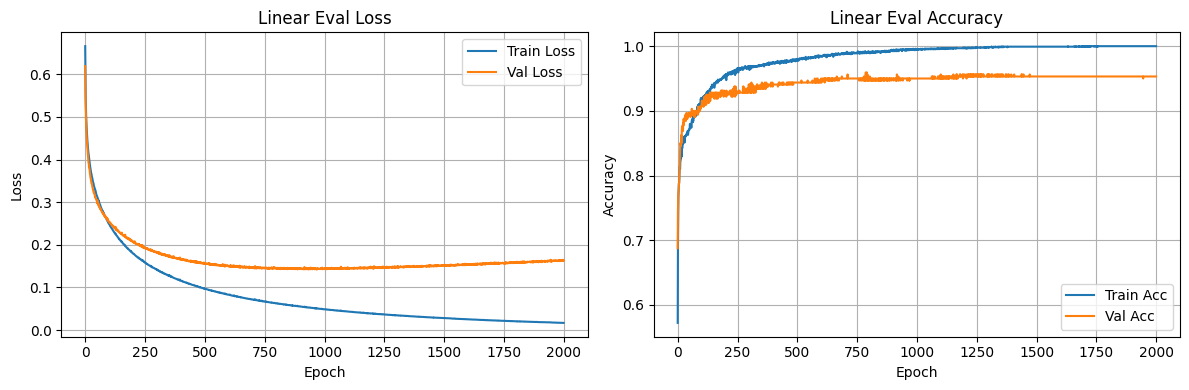

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.plot(lin_val_losses, label='Val Loss')
plt.title('Linear Eval Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.plot(lin_val_accs, label='Val Acc')
plt.title('Linear Eval Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


****Testing****

In [17]:
classifier.eval()
test_labels_all, test_probs_all = [], []
test_preds_all = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all = np.concatenate(test_preds_all)

print("\nTest Classification Report:")
print(classification_report(test_labels_all, test_preds_all, target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Test Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.94      0.95      0.94       706
   Others_augmented       0.96      0.95      0.95       890

           accuracy                           0.95      1596
          macro avg       0.95      0.95      0.95      1596
       weighted avg       0.95      0.95      0.95      1596



****ROC curve****

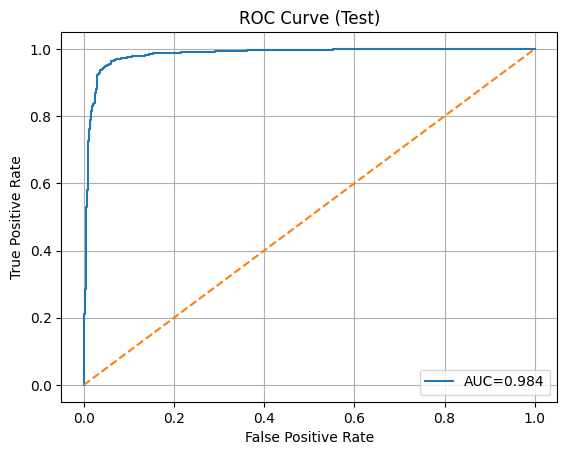

In [18]:
fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.grid(True); plt.legend(); plt.show()


Computing t-SNE on TEST features...


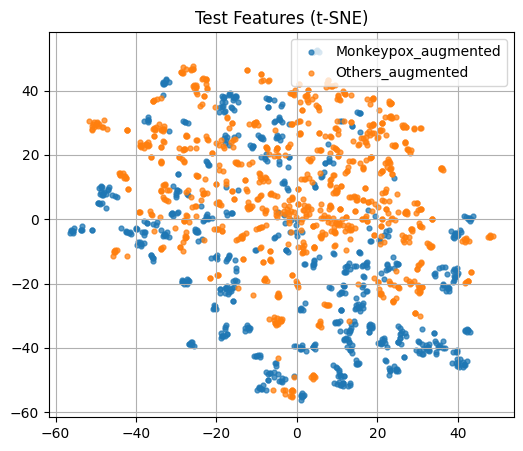

In [19]:
# t-SNE on TEST features (visual check of separability)
print("Computing t-SNE on TEST features...")
test_features, test_labels_for_vis = extract_features(test_loader, encoder_linear)
tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_features)
plt.figure(figsize=(6,5))
for c in np.unique(test_labels_for_vis):
    idx = test_labels_for_vis == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, label=IDX_TO_CLASS[c], alpha=0.75)
plt.legend(); plt.title("Test Features (t-SNE)"); plt.grid(True); plt.show()